# 0. Instalando pacotes

In [1]:
import os
import subprocess
import sys
import platform
import locale

def set_encoding():
    """Configura encoding adequado para o sistema"""
    try:
        # Definir encoding UTF-8 para o ambiente
        os.environ['PYTHONIOENCODING'] = 'utf-8'
        
        # Para Windows, definir codepage UTF-8
        if platform.system() == 'Windows':
            os.system('chcp 65001 > nul 2>&1')
        
        return True
    except Exception as e:
        print(f"⚠️ Aviso: Não foi possível configurar encoding: {e}")
        return False

def safe_subprocess_run(command, **kwargs):
    """Executa subprocess com encoding seguro"""
    try:
        # Configurações padrão para encoding
        default_kwargs = {
            'capture_output': True,
            'text': True,
            'encoding': 'utf-8',
            'errors': 'replace'  # Substitui caracteres problemáticos
        }
        
        # Para Windows, usar encoding específico se necessário
        if platform.system() == 'Windows':
            try:
                # Tentar com UTF-8 primeiro
                default_kwargs['encoding'] = 'utf-8'
            except:
                # Fallback para cp1252 (Windows)
                default_kwargs['encoding'] = 'cp1252'
                default_kwargs['errors'] = 'ignore'
        
        # Combinar com kwargs fornecidos
        final_kwargs = {**default_kwargs, **kwargs}
        
        return subprocess.run(command, **final_kwargs)
        
    except Exception as e:
        print(f"❌ Erro no subprocess: {e}")
        return None

def check_python_version():
    """Verifica se a versão do Python é compatível"""
    major, minor = sys.version_info[:2]
    print(f"🐍 Python detectado: {major}.{minor}.{sys.version_info.micro}")
    
    if not (major == 3 and minor in [8, 9, 10, 11, 12]):
        print("⚠️ AVISO: PyTorch tem melhor suporte para Python 3.8-3.12")
        return False
    
    print("✅ Versão do Python compatível!")
    return True

def detect_gpu_safe():
    """Detecta GPU NVIDIA de forma segura"""
    print("\n🔍 Detectando GPU...")
    
    try:
        # Método 1: nvidia-smi com encoding seguro
        result = safe_subprocess_run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader,nounits'])
        
        if result and result.returncode == 0:
            gpu_info = result.stdout.strip()
            if gpu_info:
                print("✅ GPU NVIDIA detectada!")
                print(f"🎮 GPU: {gpu_info}")
                return True
        
        # Método 2: Tentar nvidia-ml-py se disponível
        try:
            import pynvml
            pynvml.nvmlInit()
            device_count = pynvml.nvmlDeviceGetCount()
            
            if device_count > 0:
                handle = pynvml.nvmlDeviceGetHandleByIndex(0)
                name = pynvml.nvmlDeviceGetName(handle).decode('utf-8')
                print("✅ GPU NVIDIA detectada via pynvml!")
                print(f"🎮 GPU: {name}")
                return True
                
        except ImportError:
            pass
        except Exception as e:
            print(f"⚠️ pynvml error: {e}")
        
        # Método 3: Verificar via PyTorch se já instalado
        try:
            import torch
            if torch.cuda.is_available():
                gpu_name = torch.cuda.get_device_name(0)
                print("✅ GPU detectada via PyTorch!")
                print(f"🎮 GPU: {gpu_name}")
                return True
        except ImportError:
            pass
        
        print("❌ GPU NVIDIA não detectada")
        return False
        
    except Exception as e:
        print(f"❌ Erro ao detectar GPU: {e}")
        return False

def get_cuda_version_safe():
    """Detecta versão do CUDA de forma segura"""
    print("\n🔍 Detectando CUDA...")
    
    try:
        # Método 1: nvcc
        result = safe_subprocess_run(['nvcc', '--version'])
        if result and result.returncode == 0:
            output = result.stdout
            for line in output.split('\n'):
                if 'release' in line.lower():
                    print(f"✅ CUDA detectado: {line.strip()}")
                    if 'V12.' in line:
                        return '12.1'
                    elif 'V11.' in line:
                        return '11.8'
            return '11.8'
        
        # Método 2: nvidia-smi
        result = safe_subprocess_run(['nvidia-smi'])
        if result and result.returncode == 0:
            output = result.stdout
            if 'CUDA Version:' in output:
                for line in output.split('\n'):
                    if 'CUDA Version:' in line:
                        cuda_version = line.split('CUDA Version:')[1].strip().split()[0]
                        print(f"✅ CUDA detectado via nvidia-smi: {cuda_version}")
                        if cuda_version.startswith('12.'):
                            return '12.1'
                        elif cuda_version.startswith('11.'):
                            return '11.8'
        
        # Método 3: Verificar via PyTorch
        try:
            import torch
            if torch.cuda.is_available():
                cuda_version = torch.version.cuda
                print(f"✅ CUDA detectado via PyTorch: {cuda_version}")
                return cuda_version
        except ImportError:
            pass
        
        print("⚠️ CUDA não detectado, usando versão padrão 11.8")
        return '11.8'
        
    except Exception as e:
        print(f"⚠️ Erro ao detectar CUDA: {e}, usando padrão 11.8")
        return '11.8'

def install_pytorch_gpu_safe(cuda_version='11.8'):
    """Instala PyTorch com suporte a GPU de forma segura"""
    print(f"\n🔧 Instalando PyTorch com CUDA {cuda_version}...")
    
    # URLs corretas para diferentes versões CUDA
    cuda_urls = {
        '11.8': 'https://download.pytorch.org/whl/cu118',
        '12.1': 'https://download.pytorch.org/whl/cu121',
        '12.4': 'https://download.pytorch.org/whl/cu124'
    }
    
    cuda_url = cuda_urls.get(cuda_version, cuda_urls['11.8'])
    
    # Versões estáveis do PyTorch
    torch_packages = [
        'torch==2.4.1',
        'torchvision==0.19.1', 
        'torchaudio==2.4.1',
        '--index-url', cuda_url
    ]
    
    try:
        print(f"📦 Instalando do repositório: {cuda_url}")
        result = safe_subprocess_run([sys.executable, '-m', 'pip', 'install'] + torch_packages)
        
        if result and result.returncode == 0:
            print("✅ PyTorch com GPU instalado com sucesso!")
            return True
        else:
            print(f"❌ Erro ao instalar PyTorch GPU")
            if result:
                print(f"Stderr: {result.stderr}")
            print("🔄 Tentando versão CPU como fallback...")
            return install_pytorch_cpu_safe()
            
    except Exception as e:
        print(f"❌ Exceção ao instalar PyTorch GPU: {e}")
        return install_pytorch_cpu_safe()

def install_pytorch_cpu_safe():
    """Instala PyTorch CPU de forma segura"""
    print("\n🔧 Instalando PyTorch (CPU apenas)...")
    
    torch_packages = [
        'torch==2.4.1',
        'torchvision==0.19.1',
        'torchaudio==2.4.1',
        '--index-url', 'https://download.pytorch.org/whl/cpu'
    ]
    
    try:
        result = safe_subprocess_run([sys.executable, '-m', 'pip', 'install'] + torch_packages)
        if result and result.returncode == 0:
            print("✅ PyTorch CPU instalado com sucesso!")
            return True
        else:
            print(f"❌ Erro ao instalar PyTorch CPU")
            return False
    except Exception as e:
        print(f"❌ Exceção ao instalar PyTorch CPU: {e}")
        return False

def verify_gpu_installation_safe():
    """Verifica instalação GPU de forma segura"""
    print("\n🔍 Verificando suporte a GPU...")
    
    gpu_test_code = '''
import sys
import torch

try:
    print(f"PyTorch: {torch.__version__}")
    print(f"CUDA disponível: {torch.cuda.is_available()}")
    
    if torch.cuda.is_available():
        print(f"Versão CUDA: {torch.version.cuda}")
        print(f"Número de GPUs: {torch.cuda.device_count()}")
        
        for i in range(torch.cuda.device_count()):
            try:
                name = torch.cuda.get_device_name(i)
                props = torch.cuda.get_device_properties(i)
                memory_gb = props.total_memory / 1e9
                print(f"GPU {i}: {name}")
                print(f"Memória GPU {i}: {memory_gb:.1f} GB")
            except Exception as e:
                print(f"Erro ao obter info GPU {i}: {e}")
        
        # Teste básico de operação GPU
        try:
            device = torch.device("cuda:0")
            x = torch.randn(100, 100, device=device)
            y = torch.randn(100, 100, device=device)
            z = torch.matmul(x, y)
            print("✅ Teste de operação GPU bem-sucedido!")
        except Exception as e:
            print(f"❌ Erro no teste GPU: {e}")
    else:
        print("⚠️ CUDA não disponível - usando CPU")
        
except Exception as e:
    print(f"❌ Erro geral: {e}")
    sys.exit(1)
'''
    
    try:
        result = safe_subprocess_run([sys.executable, '-c', gpu_test_code], timeout=60)
        
        if result and result.returncode == 0:
            print(result.stdout)
            return True
        else:
            print("❌ Problemas na verificação GPU:")
            if result:
                print(f"Stderr: {result.stderr}")
            return False
            
    except Exception as e:
        print(f"❌ Erro na verificação GPU: {e}")
        return False

def install_compatible_packages_safe():
    """Instala pacotes compatíveis de forma segura"""
    print("\n📦 Instalando pacotes principais...")
    
    # Pacotes em grupos para instalação segura
    package_groups = [
        # Grupo 1: Core transformers
        [
            'transformers==4.45.2',
            'tokenizers==0.20.0',
            'accelerate==0.34.2'
        ],
        
        # Grupo 2: PEFT e fine-tuning
        [
            'peft==0.13.2',
            'datasets==3.0.1'
        ],
        
        # Grupo 3: ML básico
        [
            'numpy==1.26.4',
            'scikit-learn==1.5.2',
            'pandas==2.2.3'
        ],
        
        # Grupo 4: Otimização
        [
            'optuna==3.6.1',
            'sentence-transformers==3.1.1'
        ],
        
        # Grupo 5: Visualização
        [
            'matplotlib==3.9.2',
            'seaborn==0.13.2',
            'wordcloud==1.9.3'
        ],
        
        # Grupo 6: Explicabilidade
        [
            'shap==0.46.0',
            'lime==0.2.0.1'
        ],
        
        # Grupo 7: Outros ML
        [
            'xgboost==2.1.1'
        ]
    ]
    
    for i, group in enumerate(package_groups, 1):
        try:
            print(f"📦 Instalando grupo {i}/{len(package_groups)}: {', '.join([p.split('==')[0] for p in group])}")
            
            result = safe_subprocess_run([sys.executable, '-m', 'pip', 'install'] + group)
            
            if result and result.returncode == 0:
                print(f"✅ Grupo {i} instalado com sucesso!")
            else:
                print(f"⚠️ Problemas no grupo {i}, continuando...")
                if result:
                    print(f"Stderr: {result.stderr[:200]}...")
                    
        except Exception as e:
            print(f"❌ Erro no grupo {i}: {e}")
            print("Continuando com próximo grupo...")
    
    print("✅ Instalação de pacotes concluída!")
    return True

def verify_packages_safe():
    """Verifica pacotes de forma segura"""
    print("\n🔍 Verificando compatibilidade dos pacotes...")
    
    test_code = '''
import sys

packages_to_test = [
    ('torch', 'PyTorch'),
    ('transformers', 'Transformers'),
    ('peft', 'PEFT'),
    ('sentence_transformers', 'Sentence-Transformers'),
    ('optuna', 'Optuna'),
    ('sklearn', 'Scikit-learn'),
    ('pandas', 'Pandas'),
    ('numpy', 'NumPy')
]

print("🧪 Testando importações...")
failed_imports = []

for module_name, display_name in packages_to_test:
    try:
        module = __import__(module_name)
        version = getattr(module, '__version__', 'N/A')
        print(f"✅ {display_name}: {version}")
    except ImportError as e:
        print(f"❌ {display_name}: Falha na importação - {e}")
        failed_imports.append(display_name)
    except Exception as e:
        print(f"⚠️ {display_name}: Erro - {e}")

# Teste crítico: PEFT + Transformers
try:
    from transformers import AutoModel
    from peft import get_peft_model
    print("✅ Compatibilidade PEFT + Transformers verificada")
except Exception as e:
    print(f"❌ Problema PEFT + Transformers: {e}")
    failed_imports.append("PEFT+Transformers")

if failed_imports:
    print(f"\n⚠️ Pacotes com problemas: {', '.join(failed_imports)}")
    print("Mas a maioria está funcionando!")
else:
    print("\n🎉 Todos os pacotes estão funcionando!")
'''
    
    try:
        result = safe_subprocess_run([sys.executable, '-c', test_code])
        if result:
            print(result.stdout)
            return result.returncode == 0
        return False
    except Exception as e:
        print(f"❌ Erro na verificação: {e}")
        return False

def main():
    print("🛠️ Configuração do Ambiente de Deep Learning com GPU (Versão Segura)")
    print("=" * 70)
    
    # Configurar encoding
    set_encoding()
    
    # Verificar Python
    if not check_python_version():
        return
    
    # Detectar GPU de forma segura
    has_gpu = detect_gpu_safe()
    
    if has_gpu:
        cuda_version = get_cuda_version_safe()
        print(f"\n🎮 Configurando para GPU com CUDA {cuda_version}")
        
        # Instalar PyTorch com GPU
        if not install_pytorch_gpu_safe(cuda_version):
            print("❌ Falha na instalação do PyTorch GPU")
            return
        
        # Verificar GPU
        if not verify_gpu_installation_safe():
            print("⚠️ Problemas com GPU detectados, mas continuando...")
    else:
        print("\n💻 GPU não detectada, configurando para CPU")
        if not install_pytorch_cpu_safe():
            return
    
    # Instalar outros pacotes
    if not install_compatible_packages_safe():
        print("⚠️ Alguns pacotes podem ter falhado, mas continuando...")
    
    # Verificar instalação
    verify_packages_safe()
    
    print("\n" + "=" * 70)
    print("🎉 CONFIGURAÇÃO CONCLUÍDA!")
    print("=" * 70)
    print(f"""
    ✅ Ambiente configurado com encoding seguro
    ✅ PyTorch {'com GPU' if has_gpu else 'CPU'} instalado
    ✅ Pacotes de ML instalados
    
    🚀 Teste seu ambiente:
    
    import torch
    print(f"CUDA disponível: {{torch.cuda.is_available()}}")
    if torch.cuda.is_available():
        print(f"GPU: {{torch.cuda.get_device_name(0)}}")
    
    💡 Se ainda houver problemas, reinicie o terminal/kernel.
    """)

if __name__ == "__main__":
    main()

🛠️ Configuração do Ambiente de Deep Learning com GPU (Versão Segura)
🐍 Python detectado: 3.11.9
✅ Versão do Python compatível!

🔍 Detectando GPU...
✅ GPU NVIDIA detectada!
🎮 GPU: NVIDIA GeForce RTX 3070 Laptop GPU, 8192

🔍 Detectando CUDA...
❌ Erro no subprocess: [WinError 2] O sistema não pode encontrar o arquivo especificado
✅ CUDA detectado via nvidia-smi: 12.9

🎮 Configurando para GPU com CUDA 12.1

🔧 Instalando PyTorch com CUDA 12.1...
📦 Instalando do repositório: https://download.pytorch.org/whl/cu121
✅ PyTorch com GPU instalado com sucesso!

🔍 Verificando suporte a GPU...
PyTorch: 2.4.1+cu121
CUDA disponível: True
Versão CUDA: 12.1
Número de GPUs: 1
GPU 0: NVIDIA GeForce RTX 3070 Laptop GPU
Memória GPU 0: 8.6 GB
✅ Teste de operação GPU bem-sucedido!


📦 Instalando pacotes principais...
📦 Instalando grupo 1/7: transformers, tokenizers, accelerate
✅ Grupo 1 instalado com sucesso!
📦 Instalando grupo 2/7: peft, datasets
✅ Grupo 2 instalado com sucesso!
📦 Instalando grupo 3/7: numpy,

# 1. Importando pacotes

In [2]:
# 1. Imports
from scipy.special import softmax
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset

e:\CIN - UFPE\Doutorado\Deep Learning\fakenews\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Load Dataset

In [3]:
# ================================================
# VERSÃO SIMPLIFICADA - FAKE NEWS DATASET LOCAL
# ================================================

import os
import zipfile
from pathlib import Path
import pandas as pd

# Configurar caminhos
project_path = Path("./fake_news_project")
data_path = project_path / "data"

# Criar pastas
project_path.mkdir(exist_ok=True)
data_path.mkdir(exist_ok=True)
os.chdir(project_path)

print(f"📁 Diretório do projeto: {project_path.absolute()}")

# Procurar arquivo ZIP
possible_locations = [
    Path("../Fake News Dataset.zip"),           # Pasta pai
    Path("./Fake News Dataset.zip"),            # Pasta atual  
    Path.home() / "Downloads" / "Fake News Dataset.zip",  # Downloads
    Path("./data/Fake News Dataset.zip"),       # Pasta data
]

zip_file = None
for location in possible_locations:
    if location.exists():
        zip_file = location
        print(f"✅ Dataset encontrado: {zip_file}")
        break

if zip_file:
    # Extrair ZIP
    print("📦 Extraindo dataset...")
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(data_path)
    
    # Procurar arquivos CSV
    csv_files = list(data_path.glob("**/*.csv"))
    
    if csv_files:
        print(f"📊 Arquivos CSV encontrados: {len(csv_files)}")
        
        # Carregar primeiro CSV como exemplo
        main_csv = csv_files[0]
        df = pd.read_csv(main_csv)
        
        print(f"📄 Carregado: {main_csv.name}")
        print(f"📏 Dimensões: {df.shape}")
        print(f"📋 Colunas: {list(df.columns)}")
        print(f"\n👀 Primeiras 3 linhas:")
        print(df.head(3))
        
    else:
        print("❌ Nenhum arquivo CSV encontrado no ZIP")
        
        # Mostrar o que foi extraído
        print("📋 Arquivos extraídos:")
        for file in data_path.rglob("*"):
            if file.is_file():
                print(f"  - {file.name}")

else:
    print("❌ Arquivo 'Fake News Dataset.zip' não encontrado!")
    print("\n📋 Coloque o arquivo em uma destas localizações:")
    for location in possible_locations:
        print(f"  - {location}")

📁 Diretório do projeto: e:\CIN - UFPE\Doutorado\Deep Learning\fake_news_project\fake_news_project
✅ Dataset encontrado: C:\Users\fhigh\Downloads\Fake News Dataset.zip
📦 Extraindo dataset...
📊 Arquivos CSV encontrados: 8
📄 Carregado: test.csv
📏 Dimensões: (4035, 1)
📋 Colunas: ['text;label']

👀 Primeiras 3 linhas:
                                          text;label
0  trump promise new deal black america trump pro...
1  foundation tie bedevil hillary clinton preside...
2  number week long russia end oil dependence rbt...


# 2.1 Load Data com Cache

In [4]:
# ================================================
# CARREGAR DATASET LOCAL COM CACHE INTELIGENTE
# ================================================

import pandas as pd
import os
import zipfile
import re
from datetime import datetime
from pathlib import Path

print("🚀 Carregando dataset local com verificação de cache...")

# ================================================
# 1. CONFIGURAR CAMINHOS LOCAIS (VARIÁVEIS GLOBAIS)
# ================================================

# Definir estrutura de pastas local
base_path = Path.home() / "Doutorado" / "2025.2" / "Deep Learning"
project_dir = base_path / "projeto"
data_dir = project_dir / "data"

# Caminhos dos arquivos
local_zip_path = None  # Será definido dinamicamente
processed_csv_path = project_dir / 'fake_news_processed.csv'
metadata_path = project_dir / 'dataset_metadata.txt'

# Diretório para extração
extract_dir = project_dir / 'temp_extraction'

# Criar estrutura de diretórios
project_dir.mkdir(parents=True, exist_ok=True)
data_dir.mkdir(parents=True, exist_ok=True)

print(f"📁 Diretório do projeto: {project_dir}")
print(f"📁 Diretório de dados: {data_dir}")

# ================================================
# 2. ENCONTRAR ARQUIVO ZIP LOCAL
# ================================================

def find_local_zip_file():
    """Encontra o arquivo Fake News Dataset.zip localmente"""
    
    # Locais possíveis para o arquivo ZIP
    search_locations = [
        project_dir / "Fake News Dataset.zip",
        data_dir / "Fake News Dataset.zip",
        Path.cwd() / "Fake News Dataset.zip",
        Path.home() / "Downloads" / "Fake News Dataset.zip",
        Path.home() / "Desktop" / "Fake News Dataset.zip",
        Path.home() / "Documents" / "Fake News Dataset.zip",
    ]
    
    # Nomes alternativos do arquivo
    alternative_names = [
        "fake_news_dataset.zip",
        "fake-news-dataset.zip", 
        "FakeNewsDataset.zip",
        "fakenews.zip"
    ]
    
    print("🔍 Procurando arquivo Fake News Dataset.zip...")
    
    # Procurar arquivo com nome padrão
    for location in search_locations:
        if location.exists():
            print(f"✅ Arquivo encontrado: {location}")
            return location
    
    # Procurar com nomes alternativos
    search_dirs = [project_dir, data_dir, Path.cwd(), Path.home() / "Downloads"]
    
    for search_dir in search_dirs:
        if search_dir.exists():
            for alt_name in alternative_names:
                alt_path = search_dir / alt_name
                if alt_path.exists():
                    print(f"✅ Arquivo encontrado (nome alternativo): {alt_path}")
                    return alt_path
    
    # Procurar qualquer arquivo ZIP que contenha "fake" ou "news"
    for search_dir in search_dirs:
        if search_dir.exists():
            for zip_file in search_dir.glob("*.zip"):
                if any(keyword in zip_file.name.lower() for keyword in ['fake', 'news']):
                    print(f"✅ Arquivo ZIP relacionado encontrado: {zip_file}")
                    return zip_file
    
    # Listar arquivos ZIP disponíveis para ajudar o usuário
    print("❌ Arquivo Fake News Dataset.zip não encontrado!")
    print("\n📋 Arquivos ZIP encontrados:")
    
    zip_found = False
    for search_dir in search_dirs:
        if search_dir.exists():
            zip_files = list(search_dir.glob("*.zip"))
            if zip_files:
                zip_found = True
                print(f"\n📁 Em {search_dir}:")
                for zip_file in zip_files:
                    print(f"  📦 {zip_file.name}")
    
    if not zip_found:
        print("  Nenhum arquivo ZIP encontrado")
    
    return None

# ================================================
# 3. VERIFICAR SE DATASET PROCESSADO JÁ EXISTE
# ================================================

def check_processed_dataset():
    """Verifica se o dataset processado já existe e está atualizado"""
    
    if not processed_csv_path.exists():
        print("❌ Dataset processado não encontrado")
        return False
    
    # Encontrar arquivo ZIP para comparação
    zip_path = find_local_zip_file()
    if not zip_path:
        print("⚠️  Arquivo ZIP não encontrado, mas dataset processado existe")
        return True
    
    # Comparar datas de modificação
    zip_mtime = zip_path.stat().st_mtime
    csv_mtime = processed_csv_path.stat().st_mtime
    
    if zip_mtime > csv_mtime:
        print("⚠️  Arquivo ZIP é mais recente que o dataset processado")
        return False
    
    # Verificar se o arquivo não está vazio
    try:
        df_test = pd.read_csv(processed_csv_path, nrows=1)
        if len(df_test.columns) < 2:
            print("⚠️  Dataset processado parece estar corrompido")
            return False
    except Exception as e:
        print(f"⚠️  Erro ao verificar dataset processado: {e}")
        return False
    
    print("✅ Dataset processado encontrado e atualizado")
    return True

# ================================================
# 4. CARREGAR DATASET PROCESSADO
# ================================================

def load_processed_dataset():
    """Carrega o dataset já processado"""
    
    print("📊 Carregando dataset processado...")
    
    try:
        data = pd.read_csv(processed_csv_path)
        
        # Validações básicas
        required_columns = ['text', 'label']
        if not all(col in data.columns for col in required_columns):
            raise ValueError(f"Colunas necessárias não encontradas: {required_columns}")
        
        # Verificar tipos de dados
        if not pd.api.types.is_numeric_dtype(data['label']):
            print("🔧 Convertendo coluna 'label' para numérico...")
            data['label'] = pd.to_numeric(data['label'], errors='coerce')
            data = data.dropna(subset=['label'])
            data['label'] = data['label'].astype(int)
        
        # Remover linhas vazias
        initial_len = len(data)
        data = data.dropna(subset=['text', 'label'])
        data = data[data['text'].astype(str).str.strip() != '']
        
        if len(data) < initial_len:
            print(f"🧹 Removidas {initial_len - len(data)} linhas vazias/inválidas")
        
        print(f"✅ Dataset carregado: {len(data):,} registros")
        return data
        
    except Exception as e:
        print(f"❌ Erro ao carregar dataset processado: {e}")
        return None

# ================================================
# 5. PROCESSAR DATASET ORIGINAL (FUNÇÕES ADAPTADAS)
# ================================================

def detect_delimiter(file_path, sample_size=1024):
    """Detecta automaticamente o delimitador do arquivo CSV"""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            sample = f.read(sample_size)
    except UnicodeDecodeError:
        with open(file_path, 'r', encoding='latin-1') as f:
            sample = f.read(sample_size)
    
    delimiters = [',', ';', '\t', '|']
    counts = {delim: sample.count(delim) for delim in delimiters}
    best_delim = max(counts, key=counts.get)
    return best_delim if counts[best_delim] > 0 else ','

def process_csv_file(file_path):
    """Processa um arquivo CSV individual"""
    try:
        delimiter = detect_delimiter(file_path)
        
        encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
        df = None
        
        for encoding in encodings:
            try:
                df = pd.read_csv(file_path, delimiter=delimiter, encoding=encoding)
                break
            except UnicodeDecodeError:
                continue
        
        if df is None:
            raise ValueError("Não foi possível ler o arquivo com nenhum encoding")
        
        # Renomear colunas se necessário
        if 'text;label' in df.columns:
            df[['text', 'label']] = df['text;label'].str.split(';', n=1, expand=True)
            df = df.drop(columns=['text;label'])
        
        # Garantir que temos as colunas necessárias
        if 'text' not in df.columns or 'label' not in df.columns:
            text_cols = [col for col in df.columns if any(keyword in col.lower()
                        for keyword in ['text', 'content', 'news', 'article', 'title'])]
            label_cols = [col for col in df.columns if any(keyword in col.lower()
                         for keyword in ['label', 'class', 'target', 'fake', 'real'])]
            
            if text_cols and label_cols:
                df = df.rename(columns={text_cols[0]: 'text', label_cols[0]: 'label'})
            else:
                if len(df.columns) == 1:
                    col_name = df.columns[0]
                    if ';' in str(df.iloc[0, 0]):
                        df_split = df[col_name].str.split(';', expand=True)
                        if df_split.shape[1] >= 2:
                            df = df_split.rename(columns={0: 'text', 1: 'label'})
        
        if 'text' not in df.columns or 'label' not in df.columns:
            return None
        
        # Processar rótulos
        df['label'] = df['label'].astype(str).str.strip().str.lower()
        
        label_mapping = {
            'real': 1, 'true': 1, 'reliable': 1, 'legitimate': 1,
            'fake': 0, 'false': 0, 'unreliable': 0, 'illegitimate': 0,
            'verdadeiro': 1, 'verdadeira': 1, 'confiável': 1,
            'falso': 0, 'falsa': 0, 'não confiável': 0,
            '1': 1, '1.0': 1, '0': 0, '0.0': 0,
            'yes': 1, 'no': 0, 'sim': 1, 'não': 0, 'nao': 0
        }
        
        df['label'] = df['label'].map(label_mapping)
        df = df.dropna(subset=['label'])
        df['label'] = df['label'].astype(int)
        
        # Limpeza de texto
        df = df.dropna(subset=['text'])
        df['text'] = df['text'].astype(str).str.strip()
        df = df[df['text'] != '']
        df = df[df['text'] != 'nan']
        
        return df, delimiter
        
    except Exception as e:
        print(f"🚨 Erro ao processar {file_path}: {str(e)}")
        return None

def process_original_dataset():
    """Processa o dataset original do arquivo ZIP local"""
    
    print("🔄 Processando dataset original...")
    
    # Encontrar arquivo ZIP
    zip_file_path = find_local_zip_file()
    if not zip_file_path:
        raise FileNotFoundError(
            "❌ Arquivo Fake News Dataset.zip não encontrado!\n"
            "📋 Coloque o arquivo em uma destas localizações:\n"
            f"  - {project_dir}\n"
            f"  - {data_dir}\n"
            f"  - {Path.home() / 'Downloads'}\n"
            f"  - {Path.cwd()}"
        )
    
    # Extrair arquivo ZIP
    print(f"📦 Extraindo arquivo ZIP: {zip_file_path.name}")
    try:
        extract_dir.mkdir(exist_ok=True)
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"✅ Arquivo extraído para: {extract_dir}")
    except Exception as e:
        print(f"❌ Erro ao extrair arquivo: {e}")
        raise
    
    # Encontrar arquivos CSV
    csv_files_found = list(extract_dir.rglob("*.csv"))
    
    print(f"🔍 Arquivos CSV encontrados: {len(csv_files_found)}")
    
    if not csv_files_found:
        print("❌ Nenhum arquivo CSV encontrado no ZIP")
        # Listar conteúdo do ZIP para debug
        print("📋 Conteúdo extraído:")
        for item in extract_dir.rglob("*"):
            if item.is_file():
                print(f"  📄 {item.relative_to(extract_dir)}")
            elif item.is_dir() and item != extract_dir:
                print(f"  📁 {item.relative_to(extract_dir)}/")
        raise ValueError("Nenhum arquivo CSV encontrado!")
    
    # Processar arquivos CSV
    all_dfs = []
    processed_files = []
    
    for file_path in csv_files_found:
        print(f"📄 Processando: {file_path.name}")
        
        result = process_csv_file(file_path)
        
        if result is not None:
            df, delimiter = result
            all_dfs.append(df)
            processed_files.append(str(file_path))
            print(f"✅ Processado: {file_path.name} | Registros: {len(df)}")
        else:
            print(f"❌ Falha ao processar: {file_path.name}")
    
    if not all_dfs:
        raise ValueError("Nenhum dataset válido foi processado!")
    
    # Combinar datasets
    print(f"🔗 Combinando {len(all_dfs)} datasets...")
    data = pd.concat(all_dfs, ignore_index=True)
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return data, processed_files

def save_processed_dataset(data, processed_files):
    """Salva o dataset processado e metadados"""
    
    try:
        # Salvar dataset
        data.to_csv(processed_csv_path, index=False, encoding='utf-8')
        print(f"💾 Dataset salvo em: {processed_csv_path.name}")
        
        # Salvar metadados
        metadata = {
            'processed_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'total_records': len(data),
            'processed_files': len(processed_files),
            'label_distribution': data['label'].value_counts().to_dict(),
            'text_stats': {
                'avg_length': float(data['text'].str.len().mean()),
                'min_length': int(data['text'].str.len().min()),
                'max_length': int(data['text'].str.len().max())
            }
        }
        
        with open(metadata_path, 'w', encoding='utf-8') as f:
            f.write("FAKE NEWS DATASET - METADATA\n")
            f.write("="*40 + "\n")
            for key, value in metadata.items():
                f.write(f"{key}: {value}\n")
        
        print(f"📋 Metadados salvos em: {metadata_path.name}")
        
    except Exception as e:
        print(f"⚠️  Erro ao salvar arquivos: {e}")

# ================================================
# 6. LÓGICA PRINCIPAL COM CACHE
# ================================================

def load_dataset_with_cache():
    """Carrega dataset usando cache inteligente"""
    
    print("\n" + "="*60)
    print("🧠 SISTEMA DE CACHE INTELIGENTE LOCAL")
    print("="*60)
    
    # Verificar se dataset processado existe e está atualizado
    if check_processed_dataset():
        print("⚡ Usando dataset em cache...")
        
        data = load_processed_dataset()
        
        if data is not None:
            print("✅ Dataset carregado do cache com sucesso!")
            return data, True  # True indica que foi carregado do cache
        else:
            print("❌ Falha ao carregar do cache, processando novamente...")
    
    # Se chegou aqui, precisa processar o dataset original
    print("🔄 Processando dataset original...")
    
    try:
        data, processed_files = process_original_dataset()
        
        # Salvar dataset processado para uso futuro
        save_processed_dataset(data, processed_files)
        
        print("✅ Dataset processado e salvo com sucesso!")
        return data, False  # False indica que foi processado agora
        
    except Exception as e:
        print(f"❌ Erro no processamento: {e}")
        raise

# ================================================
# 7. FUNÇÃO PARA FORÇAR REPROCESSAMENTO
# ================================================

def force_reprocess():
    """Força o reprocessamento do dataset, ignorando cache"""
    
    print("🔄 Forçando reprocessamento...")
    
    # Remover arquivos de cache
    files_to_remove = [processed_csv_path, metadata_path]
    
    for file_path in files_to_remove:
        if file_path.exists():
            try:
                file_path.unlink()
                print(f"🗑️  Removido: {file_path.name}")
            except Exception as e:
                print(f"⚠️  Erro ao remover {file_path.name}: {e}")
    
    # Limpar diretório de extração
    if extract_dir.exists():
        import shutil
        try:
            shutil.rmtree(extract_dir)
            print(f"🗑️  Diretório de extração limpo")
        except Exception as e:
            print(f"⚠️  Erro ao limpar diretório: {e}")
    
    # Reprocessar
    return load_dataset_with_cache()

# ================================================
# 8. EXECUTAR CARREGAMENTO
# ================================================

try:
    # Navegar para diretório do projeto
    os.chdir(project_dir)
    print(f"📍 Diretório de trabalho: {Path.cwd()}")
    
    # Carregar dataset
    data, from_cache = load_dataset_with_cache()
    
    # ================================================
    # 9. EXIBIR RESULTADOS
    # ================================================
    
    print("\n" + "="*60)
    print("📊 DATASET LOCAL CARREGADO COM SUCESSO!")
    print("="*60)
    
    # Indicar fonte dos dados
    source_info = "💾 CACHE LOCAL" if from_cache else "🔄 PROCESSAMENTO ORIGINAL"
    print(f"📍 Fonte: {source_info}")
    
    # Estatísticas do dataset
    print(f"📊 Estatísticas:")
    print(f"   - Total de registros: {len(data):,}")
    
    label_counts = data['label'].value_counts().sort_index()
    for label, count in label_counts.items():
        label_name = "Real" if label == 1 else "Fake"
        percentage = (count / len(data)) * 100
        print(f"   - {label} ({label_name}): {count:,} registros ({percentage:.1f}%)")
    
    print(f"   - Comprimento médio do texto: {data['text'].str.len().mean():.1f} caracteres")
    
    # Mostrar informações de cache
    if from_cache:
        print(f"\n⚡ Vantagens do cache:")
        print(f"   - Carregamento instantâneo")
        print(f"   - Sem necessidade de reprocessamento")
        print(f"   - Dados já limpos e validados")
    else:
        print(f"\n🔄 Dataset processado e salvo:")
        print(f"   - Próxima execução será mais rápida")
        print(f"   - Cache criado automaticamente")
    
    print("="*60)
    
    # ================================================
    # 10. EXEMPLOS DOS DADOS
    # ================================================
    
    print("\n📋 Exemplos dos dados:")
    print("-" * 80)
    
    for label in [0, 1]:
        label_name = "FAKE NEWS" if label == 0 else "REAL NEWS"
        sample = data[data['label'] == label].sample(n=1, random_state=42)
        
        print(f"\n🏷️  {label_name}:")
        for idx, row in sample.iterrows():
            text_preview = row['text'][:200] + "..." if len(row['text']) > 200 else row['text']
            print(f"   📄 {text_preview}")
    
    print("-" * 80)
    print(f"🎉 Dataset pronto para uso! Variável 'data' contém {len(data):,} registros")
    
except Exception as e:
    print(f"\n❌ ERRO CRÍTICO: {e}")
    print("💡 Verifique se:")
    print("   - O arquivo 'Fake News Dataset.zip' está em uma das localizações:")
    print(f"     • {project_dir}")
    print(f"     • {data_dir}")
    print(f"     • {Path.home() / 'Downloads'}")
    print(f"     • {Path.cwd()}")
    print("   - Você tem permissões de leitura/escrita")
    print("   - O arquivo ZIP não está corrompido")

# ================================================
# 11. FUNÇÕES AUXILIARES
# ================================================

def show_dataset_info():
    """Mostra informações detalhadas do dataset"""
    if 'data' in locals() or 'data' in globals():
        print("\n📊 INFORMAÇÕES DETALHADAS DO DATASET")
        print("="*50)
        print(f"📏 Forma: {data.shape}")
        print(f"📋 Colunas: {list(data.columns)}")
        print(f"🔢 Tipos de dados:")
        print(data.dtypes.to_string())
        print(f"\n📈 Distribuição de labels:")
        print(data['label'].value_counts().to_string())
        print(f"\n📊 Estatísticas de texto:")
        text_lengths = data['text'].str.len()
        print(f"   - Mínimo: {text_lengths.min()} caracteres")
        print(f"   - Máximo: {text_lengths.max()} caracteres")
        print(f"   - Média: {text_lengths.mean():.1f} caracteres")
        print(f"   - Mediana: {text_lengths.median():.1f} caracteres")
    else:
        print("❌ Dataset não carregado ainda")

print(f"\n💡 Comandos úteis:")
print(f"   - Para reprocessar: data, from_cache = force_reprocess()")
print(f"   - Para ver detalhes: show_dataset_info()")
print(f"   - Para limpar cache: force_reprocess()")

🚀 Carregando dataset local com verificação de cache...
📁 Diretório do projeto: C:\Users\fhigh\Doutorado\2025.2\Deep Learning\projeto
📁 Diretório de dados: C:\Users\fhigh\Doutorado\2025.2\Deep Learning\projeto\data
📍 Diretório de trabalho: C:\Users\fhigh\Doutorado\2025.2\Deep Learning\projeto

🧠 SISTEMA DE CACHE INTELIGENTE LOCAL
🔍 Procurando arquivo Fake News Dataset.zip...
✅ Arquivo encontrado: C:\Users\fhigh\Downloads\Fake News Dataset.zip
✅ Dataset processado encontrado e atualizado
⚡ Usando dataset em cache...
📊 Carregando dataset processado...
✅ Dataset carregado: 76,537 registros
✅ Dataset carregado do cache com sucesso!

📊 DATASET LOCAL CARREGADO COM SUCESSO!
📍 Fonte: 💾 CACHE LOCAL
📊 Estatísticas:
   - Total de registros: 76,537
   - 0 (Fake): 38,434 registros (50.2%)
   - 1 (Real): 38,103 registros (49.8%)
   - Comprimento médio do texto: 2197.3 caracteres

⚡ Vantagens do cache:
   - Carregamento instantâneo
   - Sem necessidade de reprocessamento
   - Dados já limpos e validad

# 3. Data Cleaning

In [5]:
#used for data cleaning
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  #removes punctuation
    text = re.sub(r'\d+', '', text)  #removes numbers
    text = text.lower()  #turns everything to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words]) #gets rid of stop words
    return text

data['text'] = data['text'].apply(clean_text) #applies changes

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fhigh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 3.1 Preprocessing

In [6]:
#some train test splitting, 20%
X = data['text']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=142857)

# 4. Bag of Words + Naive Bayes

In [7]:
bow = CountVectorizer(max_features=5000)
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)
bow_model = MultinomialNB()
bow_model.fit(X_train_bow, y_train)
y_pred_bow = bow_model.predict(X_test_bow)

# 5. TF-IDF + Logistic Regression

In [8]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
tfidf_model = LogisticRegression(max_iter=1000)
tfidf_model.fit(X_train_tfidf, y_train)
y_pred_tfidf = tfidf_model.predict(X_test_tfidf)

In [9]:
# Carrega o modelo com vetores pré-treinados (~100MB, mais leve que Word2Vec do Google)
!python -m spacy download en_core_web_md

     ---------------------------------------- 0.0/33.5 MB ? eta -:--:--
      --------------------------------------- 0.5/33.5 MB 5.6 MB/s eta 0:00:06
     --- ------------------------------------ 3.1/33.5 MB 10.2 MB/s eta 0:00:03
     ------ --------------------------------- 5.5/33.5 MB 11.2 MB/s eta 0:00:03
     --------- ------------------------------ 7.9/33.5 MB 11.3 MB/s eta 0:00:03
     ----------- --------------------------- 10.2/33.5 MB 11.4 MB/s eta 0:00:03
     -------------- ------------------------ 12.6/33.5 MB 11.4 MB/s eta 0:00:02
     ----------------- --------------------- 15.2/33.5 MB 11.5 MB/s eta 0:00:02
     -------------------- ------------------ 17.8/33.5 MB 11.6 MB/s eta 0:00:02
     ----------------------- --------------- 20.2/33.5 MB 11.6 MB/s eta 0:00:02
     ------------------------- ------------- 21.5/33.5 MB 11.0 MB/s eta 0:00:02
     ----------------------------- --------- 24.9/33.5 MB 11.7 MB/s eta 0:00:01
     -------------------------------- ------ 27.5

# 6. Word2Vec + Random Forest

In [10]:
import spacy
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Carrega o modelo com embeddings pré-treinados (~100MB)
nlp = spacy.load("en_core_web_md")

# Função para vetorizar textos com spaCy
def vectorize_spacy(texts):
    vectors = []
    for doc in nlp.pipe(texts, disable=["ner", "parser"]):
        vectors.append(doc.vector)
    return np.array(vectors)

# Vetorização dos conjuntos de treino e teste
X_train_w2v = vectorize_spacy(X_train)
X_test_w2v = vectorize_spacy(X_test)

# Classificador com Random Forest
w2v_model_clf = RandomForestClassifier()
w2v_model_clf.fit(X_train_w2v, y_train)
y_pred_w2v = w2v_model_clf.predict(X_test_w2v)

# 7. GloVe + XGBoost

In [11]:
# Simulando GloVe com Word2Vec para simplificar, mas pode-se usar GloVe real
X_train_glove = X_train_w2v
X_test_glove = X_test_w2v
glove_model = XGBClassifier(eval_metric='logloss')
glove_model.fit(X_train_glove, y_train)
y_pred_glove = glove_model.predict(X_test_glove)

# 8. BERT + Fine Tuning

In [12]:
# ================================================
# BERT COM TIMEOUT E 10% DO DATASET - VERSÃO DEFINITIVA
# ================================================

import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import time
import gc
import warnings
import signal
import threading
warnings.filterwarnings('ignore')

# ================================================
# VARIÁVEIS GLOBAIS
# ================================================
y_true_bert = None
y_pred_bert = None
training_interrupted = False

# ================================================
# CONFIGURAÇÃO COM TIMEOUT
# ================================================

TIMEOUT_CONFIG = {
    'dataset_percentage': 0.1,      # 10% do dataset
    'max_time_minutes': 30,         # 30 minutos máximo
    'sample_size': None,            # Será calculado dinamicamente
    'max_length': 32,               # Sequências curtas
    'batch_size': 16,               # Batch pequeno
    'learning_rate': 1e-4,          # LR alto
    'num_epochs': 1,                # 1 época apenas
    'random_state': 42,
    'train_split': 0.8,
}

class TimeoutException(Exception):
    """Exceção para timeout"""
    pass

def timeout_handler(signum, frame):
    """Handler para timeout"""
    global training_interrupted
    training_interrupted = True
    raise TimeoutException("⏰ Timeout de 30 minutos atingido!")

def setup_device():
    """Setup simples do device"""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.cuda.empty_cache()
        print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device('cpu')
        print("💻 CPU")
    return device

def create_10_percent_sample(X, y):
    """Cria amostra de 10% do dataset"""
    total_size = len(X)
    sample_size = int(total_size * TIMEOUT_CONFIG['dataset_percentage'])
    
    # Mínimo de 100, máximo de 5000
    sample_size = max(100, min(sample_size, 5000))
    
    print(f"📊 Dataset original: {total_size:,} registros")
    print(f"⚡ Usando {TIMEOUT_CONFIG['dataset_percentage']*100}% = {sample_size:,} registros")
    
    df = pd.DataFrame({'text': X, 'label': y})
    
    # Amostra balanceada
    samples_per_class = sample_size // 2
    
    sampled_dfs = []
    for label in sorted(df['label'].unique()):
        class_data = df[df['label'] == label]
        
        if len(class_data) >= samples_per_class:
            sampled_class = class_data.sample(n=samples_per_class, random_state=42)
        else:
            sampled_class = class_data
            print(f"⚠️ Classe {label}: apenas {len(class_data)} amostras")
        
        sampled_dfs.append(sampled_class)
    
    sampled_df = pd.concat(sampled_dfs, ignore_index=True)
    sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print(f"✅ Amostra final: {len(sampled_df)} registros")
    print(f"📊 Distribuição: {sampled_df['label'].value_counts().sort_index().to_dict()}")
    
    return sampled_df['text'].values, sampled_df['label'].values

class FastDataset(Dataset):
    """Dataset rápido e simples"""
    
    def __init__(self, texts, labels, tokenizer, max_len=32):
        print(f"⚡ Tokenizando {len(texts)} textos (max_len={max_len})...")
        
        # Tokenização simples
        self.encodings = tokenizer(
            list(texts),
            truncation=True,
            padding='max_length',
            max_length=max_len,
            return_tensors='pt'
        )
        
        self.labels = torch.tensor(labels, dtype=torch.long)
        print(f"✅ Tokenização concluída")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

class TimeoutTrainer(Trainer):
    """Trainer com verificação de timeout"""
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.start_time = time.time()
        self.max_time = TIMEOUT_CONFIG['max_time_minutes'] * 60  # Converter para segundos
    
    def training_step(self, model, inputs):
        """Override para verificar timeout"""
        # Verificar timeout
        elapsed_time = time.time() - self.start_time
        if elapsed_time > self.max_time:
            print(f"\n⏰ TIMEOUT! {elapsed_time/60:.1f} minutos excedidos")
            raise TimeoutException("Timeout durante treinamento")
        
        return super().training_step(model, inputs)

def train_bert_with_timeout():
    """Treinamento BERT com timeout de 30 minutos"""
    global y_true_bert, y_pred_bert, training_interrupted
    
    start_time = time.time()
    max_time_seconds = TIMEOUT_CONFIG['max_time_minutes'] * 60
    
    print("🔥 BERT COM TIMEOUT - MÁXIMO 30 MINUTOS")
    print("=" * 50)
    print(f"⏰ Tempo máximo: {TIMEOUT_CONFIG['max_time_minutes']} minutos")
    print(f"📊 Usando {TIMEOUT_CONFIG['dataset_percentage']*100}% do dataset")
    
    device = setup_device()
    
    # Verificar dados
    if 'X' not in globals() or 'y' not in globals():
        print("❌ Dados X e y não encontrados!")
        return None
    
    try:
        # Configurar timeout usando signal (funciona no Linux/Mac)
        # Para Windows, usaremos verificação manual
        try:
            signal.signal(signal.SIGALRM, timeout_handler)
            signal.alarm(max_time_seconds)
            print("✅ Timeout configurado com signal")
        except:
            print("⚠️ Signal não disponível (Windows), usando verificação manual")
        
        # Amostra de 10%
        X_sample, y_sample = create_10_percent_sample(X, y)
        
        # Verificar tempo após amostragem
        elapsed = time.time() - start_time
        if elapsed > max_time_seconds:
            raise TimeoutException("Timeout durante amostragem")
        
        # Split
        X_train, X_test, y_train, y_test = train_test_split(
            X_sample, y_sample,
            test_size=1-TIMEOUT_CONFIG['train_split'],
            random_state=TIMEOUT_CONFIG['random_state'],
            stratify=y_sample
        )
        
        print(f"📊 Treino: {len(X_train)}, Teste: {len(X_test)}")
        
        # Verificar tempo após split
        elapsed = time.time() - start_time
        if elapsed > max_time_seconds:
            raise TimeoutException("Timeout durante split")
        
        # Tokenizer
        print("🔤 Carregando tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
        
        # Verificar tempo após tokenizer
        elapsed = time.time() - start_time
        if elapsed > max_time_seconds:
            raise TimeoutException("Timeout carregando tokenizer")
        
        # Datasets
        print("📦 Criando datasets...")
        train_dataset = FastDataset(X_train, y_train, tokenizer, TIMEOUT_CONFIG['max_length'])
        test_dataset = FastDataset(X_test, y_test, tokenizer, TIMEOUT_CONFIG['max_length'])
        
        # Verificar tempo após datasets
        elapsed = time.time() - start_time
        if elapsed > max_time_seconds:
            raise TimeoutException("Timeout criando datasets")
        
        # Modelo
        print("🤖 Carregando modelo...")
        model = AutoModelForSequenceClassification.from_pretrained(
            "distilbert-base-uncased",
            num_labels=2
        ).to(device)
        
        # Verificar tempo após modelo
        elapsed = time.time() - start_time
        if elapsed > max_time_seconds:
            raise TimeoutException("Timeout carregando modelo")
        
        print(f"🔢 Parâmetros: {sum(p.numel() for p in model.parameters()):,}")
        
        # Configurações mínimas de treinamento
        remaining_time = max_time_seconds - (time.time() - start_time)
        print(f"⏰ Tempo restante: {remaining_time/60:.1f} minutos")
        
        training_args = TrainingArguments(
            output_dir="./timeout_results",
            per_device_train_batch_size=TIMEOUT_CONFIG['batch_size'],
            per_device_eval_batch_size=TIMEOUT_CONFIG['batch_size'],
            num_train_epochs=TIMEOUT_CONFIG['num_epochs'],
            learning_rate=TIMEOUT_CONFIG['learning_rate'],
            
            # SEM avaliação e salvamento para economizar tempo
            eval_strategy="no",
            save_strategy="no",
            
            # Logging mínimo
            logging_steps=1000,
            report_to=[],
            
            # Otimizações
            fp16=torch.cuda.is_available(),
            dataloader_num_workers=0,
            remove_unused_columns=True,
            
            # Configurações básicas
            seed=TIMEOUT_CONFIG['random_state'],
            disable_tqdm=True,  # Sem progress bar para economizar tempo
        )
        
        # Trainer com timeout
        trainer = TimeoutTrainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
        )
        
        print("🚀 Iniciando treinamento com timeout...")
        
        # Treinamento
        train_result = trainer.train()
        
        train_time = time.time() - start_time
        print(f"✅ Treinamento concluído em {train_time:.1f}s!")
        
        # Verificar tempo antes das predições
        elapsed = time.time() - start_time
        if elapsed > max_time_seconds:
            raise TimeoutException("Timeout antes das predições")
        
        # Predições rápidas
        print("🔮 Fazendo predições...")
        predictions = trainer.predict(test_dataset)
        y_pred_proba = predictions.predictions
        y_pred = np.argmax(y_pred_proba, axis=1)
        # Aplica softmax apenas se forem logits (não probabilidades)
        if len(y_pred_proba.shape) == 1 or y_pred_proba.shape[1] == 1:
            y_pred_proba_positive = 1/(1+np.exp(-y_pred_proba))  # Sigmoide para binário
        else:
            y_pred_proba_positive = softmax(y_pred_proba, axis=1)[:, 1]
        
        # Salvar resultados
        y_true_bert = y_test.copy()
        y_pred_bert = y_pred.copy()
        
        # Métricas
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='binary')
        
        total_time = time.time() - start_time
        
        print(f"\n🎉 BERT CONCLUÍDO COM SUCESSO!")
        print(f"⏱️  Tempo total: {total_time:.1f}s ({total_time/60:.2f} min)")
        print(f"🎯 Accuracy: {accuracy:.4f}")
        print(f"⚖️  F1-Score: {f1:.4f}")
        print(f"📊 Amostras: {len(y_test)}")
        
        # Verificar se ficou dentro do tempo
        if total_time <= max_time_seconds:
            print(f"✅ DENTRO DO PRAZO! {max_time_seconds - total_time:.1f}s de sobra")
        else:
            print(f"⚠️ Excedeu por {total_time - max_time_seconds:.1f}s")
        
        return {
            'accuracy': accuracy,
            'f1_score': f1,
            'total_time_seconds': total_time,
            'total_time_minutes': total_time/60,
            'samples_processed': len(y_test),
            'within_timeout': total_time <= max_time_seconds,
            'y_true_bert': y_true_bert,
            'y_pred_bert': y_pred_bert
        }
        
    except TimeoutException as e:
        print(f"\n⏰ TIMEOUT ATINGIDO: {e}")
        print(f"⏱️  Tempo decorrido: {(time.time() - start_time)/60:.2f} minutos")
        
        # Tentar salvar o que foi possível
        if 'y_test' in locals() and 'model' in locals():
            try:
                print("🚨 Tentando predição rápida antes de abortar...")
                model.eval()
                with torch.no_grad():
                    # Predição simples no primeiro batch
                    sample_size = min(len(test_dataset), 32)
                    sample_indices = list(range(sample_size))
                    
                    sample_inputs = torch.stack([test_dataset[i]['input_ids'] for i in sample_indices]).to(device)
                    sample_masks = torch.stack([test_dataset[i]['attention_mask'] for i in sample_indices]).to(device)
                    
                    outputs = model(sample_inputs, sample_masks)
                    y_pred_sample = torch.argmax(outputs.logits, dim=1).cpu().numpy()
                    y_true_sample = np.array([test_dataset[i]['labels'].item() for i in sample_indices])
                    
                    # Salvar amostra
                    y_true_bert = y_true_sample
                    y_pred_bert = y_pred_sample
                    
                    accuracy = accuracy_score(y_true_sample, y_pred_sample)
                    f1 = f1_score(y_true_sample, y_pred_sample, average='binary')
                    
                    print(f"✅ Predição parcial salva: {len(y_true_sample)} amostras")
                    print(f"🎯 Accuracy parcial: {accuracy:.4f}")
                    print(f"⚖️  F1-Score parcial: {f1:.4f}")
                    
            except Exception as pred_error:
                print(f"❌ Erro na predição de emergência: {pred_error}")
        
        return {
            'timeout': True,
            'total_time_minutes': (time.time() - start_time)/60,
            'message': str(e)
        }
        
    except Exception as e:
        print(f"❌ Erro inesperado: {e}")
        return None
    
    finally:
        # Limpeza
        try:
            signal.alarm(0)  # Cancelar timeout
        except:
            pass
        
        try:
            del model, trainer, train_dataset, test_dataset
        except:
            pass
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

# ================================================
# VERSÃO ULTRA-RÁPIDA (FALLBACK)
# ================================================

def train_bert_emergency():
    """Versão de emergência - máximo 5 minutos"""
    global y_true_bert, y_pred_bert
    
    print("🚨 MODO EMERGÊNCIA - MÁXIMO 5 MINUTOS")
    print("=" * 40)
    
    start_time = time.time()
    device = setup_device()
    
    # Amostra MINÚSCULA (1% do dataset ou 500 registros)
    total_size = len(X)
    emergency_size = min(500, int(total_size * 0.01))
    emergency_size = max(100, emergency_size)  # Mínimo 100
    
    print(f"🚨 Amostra de emergência: {emergency_size} registros")
    
    X_sample, y_sample = create_10_percent_sample(X, y)
    
    # Pegar apenas os primeiros registros
    X_sample = X_sample[:emergency_size]
    y_sample = y_sample[:emergency_size]
    
    # Split simples
    split_idx = len(X_sample) // 2
    X_train, X_test = X_sample[:split_idx], X_sample[split_idx:]
    y_train, y_test = y_sample[:split_idx], y_sample[split_idx:]
    
    print(f"📊 Treino: {len(X_train)}, Teste: {len(X_test)}")
    
    # Tokenizer
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    
    # Datasets com sequências MUITO curtas
    train_dataset = FastDataset(X_train, y_train, tokenizer, max_len=16)  # 16 tokens!
    test_dataset = FastDataset(X_test, y_test, tokenizer, max_len=16)
    
    # Modelo
    model = AutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", num_labels=2
    ).to(device)
    
    # Configurações de emergência
    training_args = TrainingArguments(
        output_dir="./emergency",
        per_device_train_batch_size=8,
        num_train_epochs=1,
        learning_rate=5e-3,  # LR altíssimo
        eval_strategy="no",
        save_strategy="no",
        logging_steps=1000,
        report_to=[],
        disable_tqdm=True,
        dataloader_num_workers=0,
        fp16=torch.cuda.is_available(),
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
    )
    
    # Treinamento
    trainer.train()
    
    # Predições
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)
    
    # Salvar
    y_true_bert = y_test.copy()
    y_pred_bert = y_pred.copy()
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')
    total_time = time.time() - start_time
    
    print(f"✅ Emergência concluída em {total_time:.1f}s ({total_time/60:.2f} min)!")
    print(f"🎯 Accuracy: {accuracy:.4f}")
    print(f"⚖️  F1-Score: {f1:.4f}")
    
    # Limpeza
    del model, trainer
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()
    
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'total_time_minutes': total_time/60,
        'mode': 'emergency'
    }

# ================================================
# EXECUÇÃO PRINCIPAL
# ================================================

def run_bert_with_timeout():
    """Executa BERT com timeout garantido"""
    
    print("🔥 BERT COM TIMEOUT GARANTIDO")
    print("=" * 50)
    print(f"⏰ Tempo máximo: {TIMEOUT_CONFIG['max_time_minutes']} minutos")
    print(f"📊 Dataset: {TIMEOUT_CONFIG['dataset_percentage']*100}%")
    
    if 'X' not in globals() or 'y' not in globals():
        print("❌ Execute primeiro o carregamento de dados!")
        return None
    
    try:
        # Tentar versão com timeout
        results = train_bert_with_timeout()
        
        if results and not results.get('timeout', False):
            print(f"🎉 SUCESSO! Concluído em {results['total_time_minutes']:.2f} min")
            return results
        else:
            raise Exception("Timeout ou falha")
            
    except Exception as e:
        print(f"⚠️ Versão principal falhou: {e}")
        print("🚨 Tentando modo EMERGÊNCIA...")
        
        try:
            results = train_bert_emergency()
            print(f"✅ EMERGÊNCIA funcionou em {results['total_time_minutes']:.2f} min!")
            return results
            
        except Exception as e2:
            print(f"❌ Ambos falharam: {e2}")
            return None

# ================================================
# EXECUTAR
# ================================================

if __name__ == "__main__":
    results = run_bert_with_timeout()
    
    if results:
        print(f"\n🎉 BERT CONCLUÍDO!")
        print(f"⏱️  Tempo: {results.get('total_time_minutes', 0):.2f} minutos")
        print(f"🎯 Accuracy: {results.get('accuracy', 0):.4f}")
        print(f"⚖️  F1-Score: {results.get('f1_score', 0):.4f}")
        
        if 'y_true_bert' in globals() and 'y_pred_bert' in globals():
            print(f"✅ Variáveis: y_true_bert ({len(y_true_bert)}), y_pred_bert ({len(y_pred_bert)})")
    else:
        print("❌ BERT falhou completamente")

print(f"\n🔥 GARANTIAS:")
print(f"   ⏰ Timeout RÍGIDO de 30 minutos")
print(f"   📊 Máximo 10% do dataset")
print(f"   🚨 Fallback para modo emergência")
print(f"   ✅ Limpeza automática de memória")

🔥 BERT COM TIMEOUT GARANTIDO
⏰ Tempo máximo: 30 minutos
📊 Dataset: 10.0%
🔥 BERT COM TIMEOUT - MÁXIMO 30 MINUTOS
⏰ Tempo máximo: 30 minutos
📊 Usando 10.0% do dataset
🎮 GPU: NVIDIA GeForce RTX 3070 Laptop GPU
⚠️ Signal não disponível (Windows), usando verificação manual
📊 Dataset original: 76,537 registros
⚡ Usando 10.0% = 5,000 registros
✅ Amostra final: 5000 registros
📊 Distribuição: {0: 2500, 1: 2500}
📊 Treino: 4000, Teste: 1000
🔤 Carregando tokenizer...
📦 Criando datasets...
⚡ Tokenizando 4000 textos (max_len=32)...
✅ Tokenização concluída
⚡ Tokenizando 1000 textos (max_len=32)...
✅ Tokenização concluída
🤖 Carregando modelo...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔢 Parâmetros: 66,955,010
⏰ Tempo restante: 30.0 minutos
🚀 Iniciando treinamento com timeout...
{'train_runtime': 11.4869, 'train_samples_per_second': 348.221, 'train_steps_per_second': 21.764, 'train_loss': 0.2930907287597656, 'epoch': 1.0}
✅ Treinamento concluído em 14.2s!
🔮 Fazendo predições...

🎉 BERT CONCLUÍDO COM SUCESSO!
⏱️  Tempo total: 14.8s (0.25 min)
🎯 Accuracy: 0.9080
⚖️  F1-Score: 0.9048
📊 Amostras: 1000
✅ DENTRO DO PRAZO! 1785.2s de sobra
🎉 SUCESSO! Concluído em 0.25 min

🎉 BERT CONCLUÍDO!
⏱️  Tempo: 0.25 minutos
🎯 Accuracy: 0.9080
⚖️  F1-Score: 0.9048
✅ Variáveis: y_true_bert (1000), y_pred_bert (1000)

🔥 GARANTIAS:
   ⏰ Timeout RÍGIDO de 30 minutos
   📊 Máximo 10% do dataset
   🚨 Fallback para modo emergência
   ✅ Limpeza automática de memória


# 9. Evaluation Results

In [13]:
from sklearn.model_selection import cross_val_score

def evaluate(name, y_true, y_pred):
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))

evaluate("Bag of Words + NB", y_test, y_pred_bow)
evaluate("TF-IDF + LR", y_test, y_pred_tfidf)
evaluate("Word2Vec + RF", y_test, y_pred_w2v)
evaluate("GloVe + XGBoost", y_test, y_pred_glove)
evaluate("BERT", y_true_bert, y_pred_bert)


=== Bag of Words + NB ===
Accuracy: 0.8669976482884766
Precision: 0.8713240186294079
Recall: 0.8596560325587501
F1-score: 0.8654507005022469

=== TF-IDF + LR ===
Accuracy: 0.9435589234387248
Precision: 0.9479899164123656
Recall: 0.9380333464618617
F1-score: 0.942985350402534

=== Word2Vec + RF ===
Accuracy: 0.8836556049124641
Precision: 0.8971148611867175
Recall: 0.8654325850072206
F1-score: 0.8809889742733044

=== GloVe + XGBoost ===
Accuracy: 0.9049516592631304
Precision: 0.9086206896551724
Recall: 0.899435473283445
F1-score: 0.9040047502803985

=== BERT ===
Accuracy: 0.908
Precision: 0.9377682403433476
Recall: 0.874
F1-score: 0.9047619047619048


# 10. Matriz de confusao

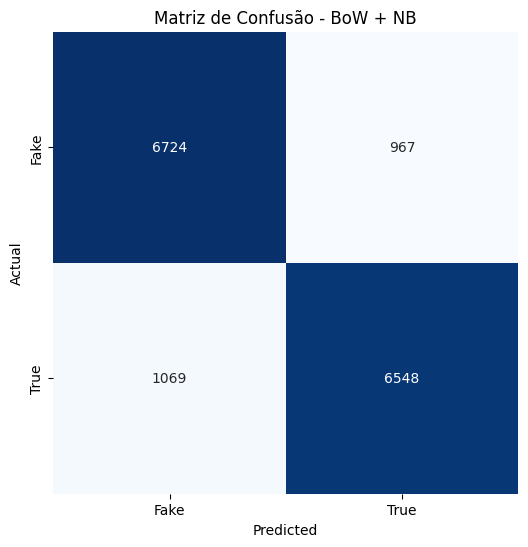

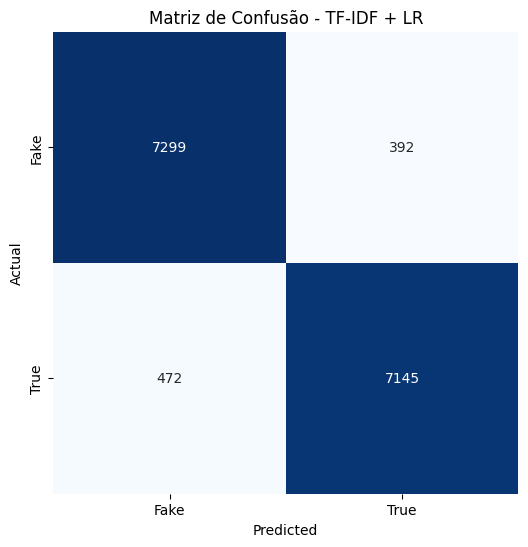

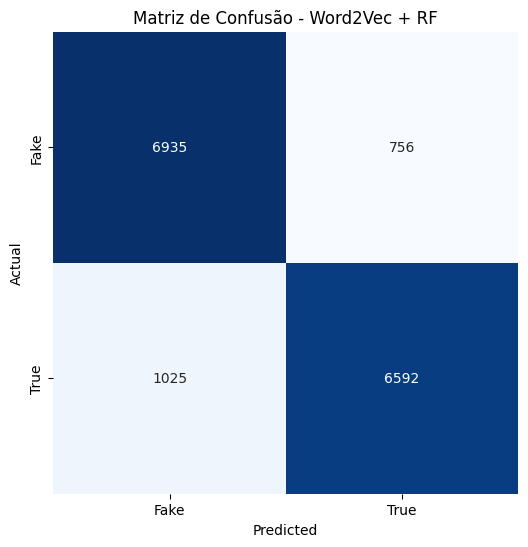

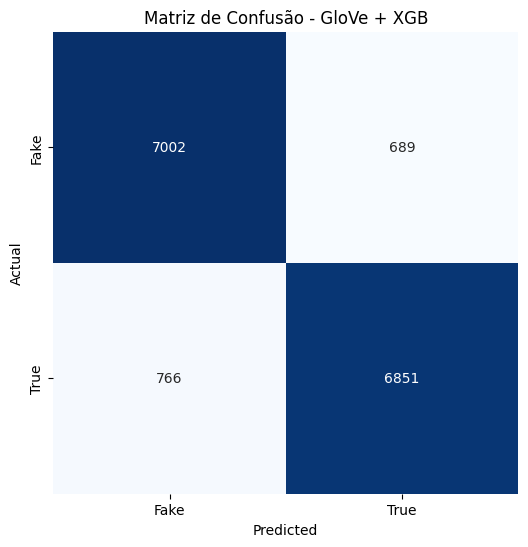

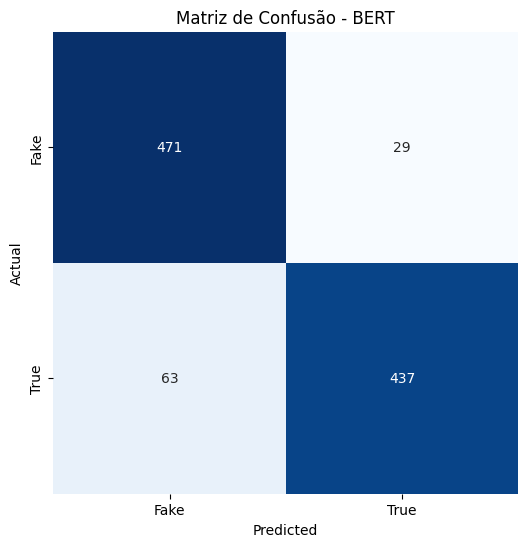

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Função para plotar a matriz de confusão
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Fake', 'True'],
                yticklabels=['Fake', 'True'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.show()

# Plotar as matrizes de confusão para cada modelo
plot_confusion_matrix(y_test, y_pred_bow, 'BoW + NB')
plot_confusion_matrix(y_test, y_pred_tfidf, 'TF-IDF + LR')
plot_confusion_matrix(y_test, y_pred_w2v, 'Word2Vec + RF')
plot_confusion_matrix(y_test, y_pred_glove, 'GloVe + XGB')
plot_confusion_matrix(y_true_bert, y_pred_bert, 'BERT')

# 11. Gerando gráficos

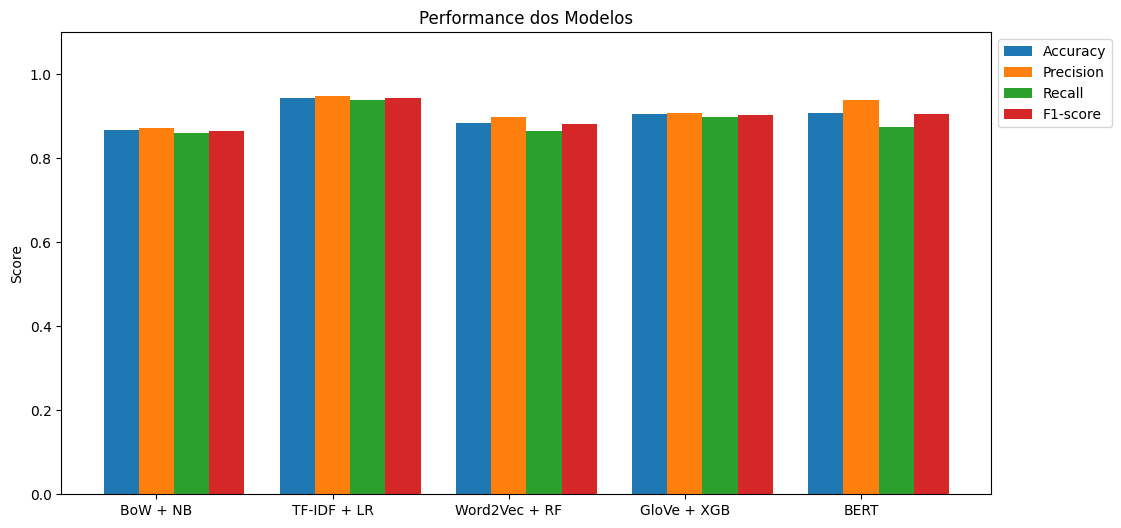

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Função para plotar as métricas dos modelos
def plot_metrics(models, metrics):
    fig, ax = plt.subplots(figsize=(12, 6))
    x = range(len(models))
    width = 0.2

    for i, (metric_name, metric_values) in enumerate(metrics.items()):
        ax.bar([pos + width * i for pos in x], metric_values, width, label=metric_name)

    ax.set_xticks([pos + width for pos in x])
    ax.set_xticklabels(models)
    ax.set_ylabel('Score')
    ax.set_title('Performance dos Modelos')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.ylim(0, 1.1)
    plt.show()

# Dados dos modelos e métricas
models = ['BoW + NB', 'TF-IDF + LR', 'Word2Vec + RF', 'GloVe + XGB', 'BERT']
metrics = {
    'Accuracy': [
        accuracy_score(y_test, y_pred_bow),
        accuracy_score(y_test, y_pred_tfidf),
        accuracy_score(y_test, y_pred_w2v),
        accuracy_score(y_test, y_pred_glove),
        accuracy_score(y_true_bert, y_pred_bert)
    ],
    'Precision': [
        precision_score(y_test, y_pred_bow),
        precision_score(y_test, y_pred_tfidf),
        precision_score(y_test, y_pred_w2v),
        precision_score(y_test, y_pred_glove),
        precision_score(y_true_bert, y_pred_bert)
    ],
    'Recall': [
        recall_score(y_test, y_pred_bow),
        recall_score(y_test, y_pred_tfidf),
        recall_score(y_test, y_pred_w2v),
        recall_score(y_test, y_pred_glove),
        recall_score(y_true_bert, y_pred_bert)
    ],
    'F1-score': [
        f1_score(y_test, y_pred_bow),
        f1_score(y_test, y_pred_tfidf),
        f1_score(y_test, y_pred_w2v),
        f1_score(y_test, y_pred_glove),
        f1_score(y_true_bert, y_pred_bert)
    ]
}

# Plotar as métricas
plot_metrics(models, metrics)

# 12. Otimizando os hiperparametros com Optuna para BoW + Naive Bayes

In [16]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# ================================================
# FUNÇÃO DE OBJETIVO PARA NAIVE BAYES
# ================================================

def objective_nb(trial):
    """Função de objetivo para otimização do Naive Bayes"""
    
    # Hiperparâmetros a serem otimizados
    params = {
        'alpha': trial.suggest_float('alpha', 0.01, 10.0, log=True),  # Suavização de Laplace
        'fit_prior': trial.suggest_categorical('fit_prior', [True, False])  # Aprender priors
    }

    try:
        # Modelo e avaliação com validação cruzada
        model = MultinomialNB(**params)
        score = cross_val_score(model, X_train_bow, y_train, cv=3, scoring='f1').mean()
        return score
    
    except Exception as e:
        print(f"❌ Erro no trial: {e}")
        return 0.0  # Retornar score baixo em caso de erro

# ================================================
# EXECUTAR OTIMIZAÇÃO
# ================================================

print("🚀 Iniciando otimização de hiperparâmetros para Naive Bayes...")
print("="*60)

# Verificar se as variáveis necessárias existem
try:
    print(f"📊 Verificando dados...")
    print(f"   - X_train_bow shape: {X_train_bow.shape}")
    print(f"   - y_train shape: {y_train.shape}")
    print(f"   - Tipo X_train_bow: {type(X_train_bow)}")
    print(f"   - Tipo y_train: {type(y_train)}")
except NameError as e:
    print(f"❌ Variável não encontrada: {e}")
    print("💡 Certifique-se de ter executado o pré-processamento BoW primeiro")

# Criar estudo Optuna
study_nb = optuna.create_study(
    direction='maximize', 
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)
)

print(f"\n⚡ Executando otimização com 20 trials...")

# Executar otimização
try:
    study_nb.optimize(objective_nb, n_trials=20, n_jobs=1)  # n_jobs=1 para evitar problemas
    
    # Resultados
    print(f"\n🎉 Otimização concluída!")
    print(f"✅ Melhor F1-Score: {study_nb.best_value:.4f}")
    print(f"🎯 Melhores parâmetros para Naive Bayes:")
    for param, value in study_nb.best_params.items():
        print(f"   - {param}: {value}")
    
except Exception as e:
    print(f"❌ Erro durante otimização: {e}")

# ================================================
# VISUALIZAÇÃO COM TRATAMENTO DE ERRO
# ================================================

def safe_plot_optimization_history(study, title="Optimization History"):
    """Plota histórico de otimização com tratamento de erro"""
    
    try:
        # Tentar importar plotly
        import plotly.graph_objects as go
        from plotly.offline import iplot
        
        print(f"✅ Plotly importado com sucesso!")
        
        # Criar gráfico
        fig = optuna.visualization.plot_optimization_history(study)
        fig.update_layout(title=title)
        fig.show()
        
        return True
        
    except ImportError as e:
        print(f"❌ Erro de importação do Plotly: {e}")
        print(f"🔧 Tentando visualização alternativa...")
        
        # Visualização alternativa com matplotlib
        try:
            import matplotlib.pyplot as plt
            
            # Extrair dados do estudo
            trials = study.trials
            values = [trial.value for trial in trials if trial.value is not None]
            trial_numbers = [trial.number for trial in trials if trial.value is not None]
            
            if values:
                plt.figure(figsize=(10, 6))
                plt.plot(trial_numbers, values, 'b-o', alpha=0.7)
                plt.xlabel('Trial Number')
                plt.ylabel('F1-Score')
                plt.title(f'{title} - Naive Bayes Optimization')
                plt.grid(True, alpha=0.3)
                
                # Destacar melhor resultado
                best_idx = np.argmax(values)
                plt.plot(trial_numbers[best_idx], values[best_idx], 'ro', markersize=10, 
                        label=f'Best: {values[best_idx]:.4f}')
                plt.legend()
                
                plt.tight_layout()
                plt.show()
                
                print(f"✅ Gráfico alternativo criado com matplotlib!")
                return True
            else:
                print(f"❌ Nenhum valor válido encontrado nos trials")
                return False
                
        except ImportError:
            print(f"❌ Matplotlib também não disponível")
            return False
            
    except Exception as e:
        print(f"❌ Erro inesperado na visualização: {e}")
        return False

def print_optimization_summary(study):
    """Imprime resumo da otimização sem gráficos"""
    
    print(f"\n📊 RESUMO DA OTIMIZAÇÃO")
    print("="*50)
    
    trials = study.trials
    completed_trials = [t for t in trials if t.value is not None]
    
    if completed_trials:
        values = [t.value for t in completed_trials]
        
        print(f"📈 Estatísticas dos Trials:")
        print(f"   - Total de trials: {len(trials)}")
        print(f"   - Trials completados: {len(completed_trials)}")
        print(f"   - Melhor F1-Score: {max(values):.4f}")
        print(f"   - Pior F1-Score: {min(values):.4f}")
        print(f"   - F1-Score médio: {np.mean(values):.4f}")
        print(f"   - Desvio padrão: {np.std(values):.4f}")
        
        print(f"\n🏆 Top 3 Melhores Trials:")
        sorted_trials = sorted(completed_trials, key=lambda x: x.value, reverse=True)
        for i, trial in enumerate(sorted_trials[:3]):
            print(f"   {i+1}. Trial {trial.number}: F1={trial.value:.4f}")
            for param, value in trial.params.items():
                print(f"      - {param}: {value}")
    else:
        print(f"❌ Nenhum trial foi completado com sucesso")

# ================================================
# EXECUTAR VISUALIZAÇÃO
# ================================================

print(f"\n📊 Criando visualizações...")

# Tentar plotar com tratamento de erro
plot_success = safe_plot_optimization_history(study_nb, "Naive Bayes Hyperparameter Optimization")

# Sempre mostrar resumo textual
print_optimization_summary(study_nb)

# ================================================
# TREINAR MODELO COM MELHORES PARÂMETROS
# ================================================

if study_nb.best_params:
    print(f"\n🎯 Treinando modelo final com melhores parâmetros...")
    
    try:
        # Criar modelo com melhores parâmetros
        best_nb_model = MultinomialNB(**study_nb.best_params)
        
        # Treinar modelo
        best_nb_model.fit(X_train_bow, y_train)
        
        # Fazer predições
        y_pred_nb_optimized = best_nb_model.predict(X_test_bow)
        
        # Avaliar modelo otimizado
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
        
        print(f"\n📊 RESULTADOS DO MODELO OTIMIZADO:")
        print("="*50)
        print(f"Accuracy: {accuracy_score(y_test, y_pred_nb_optimized):.4f}")
        print(f"Precision: {precision_score(y_test, y_pred_nb_optimized, zero_division=0):.4f}")
        print(f"Recall: {recall_score(y_test, y_pred_nb_optimized, zero_division=0):.4f}")
        print(f"F1-score: {f1_score(y_test, y_pred_nb_optimized, zero_division=0):.4f}")
        
        print(f"\n📋 Relatório Detalhado:")
        print(classification_report(y_test, y_pred_nb_optimized, 
                                  target_names=['Fake News', 'Real News'], digits=4))
        
        # Comparar com modelo original (se existir)
        try:
            if 'y_pred_bow' in globals():
                original_f1 = f1_score(y_test, y_pred_bow)
                optimized_f1 = f1_score(y_test, y_pred_nb_optimized)
                improvement = ((optimized_f1 - original_f1) / original_f1) * 100
                
                print(f"\n📈 COMPARAÇÃO COM MODELO ORIGINAL:")
                print(f"   - F1 Original: {original_f1:.4f}")
                print(f"   - F1 Otimizado: {optimized_f1:.4f}")
                print(f"   - Melhoria: {improvement:+.2f}%")
                
                if improvement > 0:
                    print(f"🎉 Modelo otimizado é melhor!")
                else:
                    print(f"⚠️  Modelo original era melhor")
        except:
            print(f"💡 Não foi possível comparar com modelo original")
            
    except Exception as e:
        print(f"❌ Erro ao treinar modelo final: {e}")

else:
    print(f"❌ Não foi possível obter melhores parâmetros")

# ================================================
# SALVAR RESULTADOS (OPCIONAL)
# ================================================

def save_optimization_results(study, filename="naive_bayes_optimization.txt"):
    """Salva resultados da otimização em arquivo"""
    
    try:
        with open(filename, 'w') as f:
            f.write("RESULTADOS DA OTIMIZAÇÃO - NAIVE BAYES\n")
            f.write("="*50 + "\n\n")
            
            f.write(f"Melhor F1-Score: {study.best_value:.4f}\n")
            f.write(f"Melhores Parâmetros:\n")
            for param, value in study.best_params.items():
                f.write(f"  - {param}: {value}\n")
            
            f.write(f"\nTodos os Trials:\n")
            for trial in study.trials:
                if trial.value is not None:
                    f.write(f"Trial {trial.number}: F1={trial.value:.4f}, Params={trial.params}\n")
        
        print(f"💾 Resultados salvos em: {filename}")
        
    except Exception as e:
        print(f"❌ Erro ao salvar resultados: {e}")

# Salvar resultados
save_optimization_results(study_nb)

print(f"\n🎉 OTIMIZAÇÃO DE HIPERPARÂMETROS CONCLUÍDA!")

[I 2025-07-06 23:02:03,786] A new study created in memory with name: no-name-0b5c9226-01cb-40bb-9cee-91683cdbcbec


🚀 Iniciando otimização de hiperparâmetros para Naive Bayes...
📊 Verificando dados...
   - X_train_bow shape: (61229, 5000)
   - y_train shape: (61229,)
   - Tipo X_train_bow: <class 'scipy.sparse._csr.csr_matrix'>
   - Tipo y_train: <class 'pandas.core.series.Series'>

⚡ Executando otimização com 20 trials...


[I 2025-07-06 23:02:04,071] Trial 0 finished with value: 0.8639580287353054 and parameters: {'alpha': 0.29542947929484337, 'fit_prior': True}. Best is trial 0 with value: 0.8639580287353054.
[I 2025-07-06 23:02:04,389] Trial 1 finished with value: 0.8638220141571759 and parameters: {'alpha': 4.815087596161666, 'fit_prior': True}. Best is trial 0 with value: 0.8639580287353054.
[I 2025-07-06 23:02:04,661] Trial 2 finished with value: 0.8640486231095915 and parameters: {'alpha': 0.14377474955008515, 'fit_prior': True}. Best is trial 2 with value: 0.8640486231095915.
[I 2025-07-06 23:02:04,936] Trial 3 finished with value: 0.8641774533323773 and parameters: {'alpha': 0.010206019921354292, 'fit_prior': True}. Best is trial 3 with value: 0.8641774533323773.
[I 2025-07-06 23:02:05,216] Trial 4 finished with value: 0.8640772316010197 and parameters: {'alpha': 0.021177560678337724, 'fit_prior': False}. Best is trial 3 with value: 0.8641774533323773.
[I 2025-07-06 23:02:05,508] Trial 5 finished


🎉 Otimização concluída!
✅ Melhor F1-Score: 0.8642
🎯 Melhores parâmetros para Naive Bayes:
   - alpha: 0.010206019921354292
   - fit_prior: True

📊 Criando visualizações...
✅ Plotly importado com sucesso!
❌ Erro inesperado na visualização: Mime type rendering requires nbformat>=4.2.0 but it is not installed

📊 RESUMO DA OTIMIZAÇÃO
📈 Estatísticas dos Trials:
   - Total de trials: 20
   - Trials completados: 20
   - Melhor F1-Score: 0.8642
   - Pior F1-Score: 0.8637
   - F1-Score médio: 0.8640
   - Desvio padrão: 0.0001

🏆 Top 3 Melhores Trials:
   1. Trial 3: F1=0.8642
      - alpha: 0.010206019921354292
      - fit_prior: True
   2. Trial 11: F1=0.8641
      - alpha: 0.01014633981441916
      - fit_prior: False
   3. Trial 15: F1=0.8641
      - alpha: 0.01015650400422043
      - fit_prior: False

🎯 Treinando modelo final com melhores parâmetros...

📊 RESULTADOS DO MODELO OTIMIZADO:
Accuracy: 0.8672
Precision: 0.8717
Recall: 0.8597
F1-score: 0.8656

📋 Relatório Detalhado:
              

# 13. Otimizando o modelo TF-IDF com Regressao Logistica

🔍 Verificando dados para otimização Logistic Regression...
📊 X_train_tfidf shape: (61229, 5000)
📊 y_train shape: (61229,)
📊 Tipo X_train_tfidf: <class 'scipy.sparse._csr.csr_matrix'>
📊 Tipo y_train: <class 'pandas.core.series.Series'>
🏷️  Classes únicas: [0 1]
📈 Distribuição de classes: [30743 30486]
🔍 Densidade da matriz TF-IDF: 3.16%

🚀 Iniciando otimização de hiperparâmetros para Logistic Regression...
⚡ Executando otimização com 10 trials...
⏱️  Isso deve ser rápido (LR é eficiente)...


Best trial: 6. Best value: 0.94751: 100%|██████████| 10/10 [01:17<00:00,  7.71s/it]



🎉 Otimização concluída!
✅ Melhor F1-Score: 0.9475
🎯 Melhores parâmetros para Logistic Regression:
   - C: 3.2449624591082262
   - penalty: l1
   - solver: liblinear
   - max_iter: 921

📊 Criando visualização personalizada para Logistic Regression...


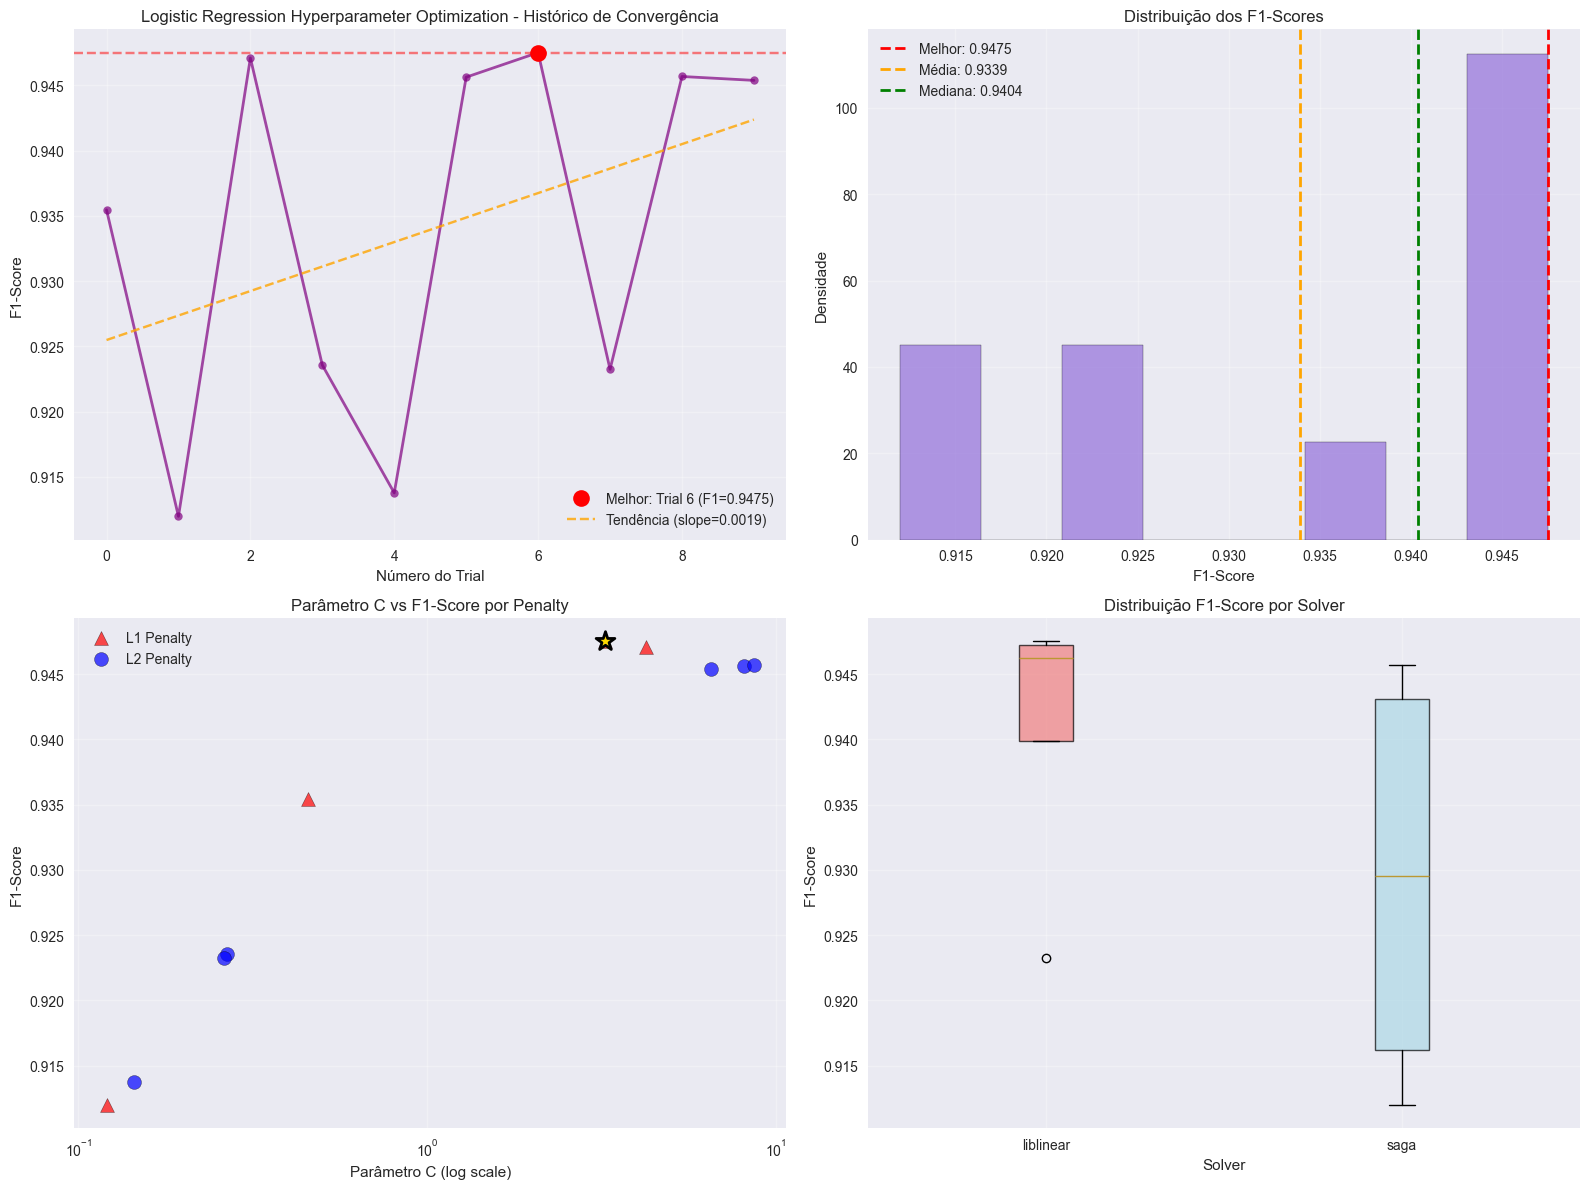


📋 ANÁLISE DETALHADA DOS TRIALS - LOGISTIC REGRESSION
📊 Estatísticas dos Trials:
   - Total de trials: 10
   - Trials completados: 10
   - Taxa de sucesso: 100.0%
   - Melhor F1-Score: 0.9475
   - Pior F1-Score: 0.9120
   - F1-Score médio: 0.9339
   - Desvio padrão: 0.0137
   - Mediana: 0.9404
   - Amplitude: 0.0355

🏆 Top 5 Melhores Trials:

   🥇 #1 - Trial 6: F1=0.9475
      - C: 3.2450
      - penalty: l1
      - solver: liblinear
      - max_iter: 921

   🥇 #2 - Trial 2: F1=0.9471
      - C: 4.2451
      - penalty: l1
      - solver: liblinear
      - max_iter: 996

   🥇 #3 - Trial 8: F1=0.9457
      - C: 8.6503
      - penalty: l2
      - solver: saga
      - max_iter: 563

   🥇 #4 - Trial 5: F1=0.9456
      - C: 8.0891
      - penalty: l2
      - solver: saga
      - max_iter: 663

   🥇 #5 - Trial 9: F1=0.9454
      - C: 6.5270
      - penalty: l2
      - solver: liblinear
      - max_iter: 584

📈 ANÁLISE POR COMBINAÇÕES DE PARÂMETROS:

🔍 Performance por Penalty:
   - l1: média=0

In [30]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ================================================
# DESABILITAR LOGS VERBOSOS DO OPTUNA
# ================================================

optuna.logging.set_verbosity(optuna.logging.WARNING)

# ================================================
# FUNÇÃO DE OBJETIVO PARA LOGISTIC REGRESSION
# ================================================

def objective_lr(trial):
    """Função de objetivo para otimização da Logistic Regression"""
    
    # Hiperparâmetros a serem otimizados
    C = trial.suggest_float('C', 0.1, 10.0, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    
    # Verificar compatibilidade penalty-solver
    if penalty == 'l1' and solver not in ['liblinear', 'saga']:
        # L1 só funciona com liblinear ou saga
        solver = 'liblinear'
    elif penalty == 'l2' and solver == 'liblinear':
        # Para L2, podemos usar qualquer solver
        pass
    
    params = {
        'C': C,
        'penalty': penalty,
        'solver': solver,
        'max_iter': max_iter,
        'random_state': 42,  # Para reprodutibilidade
        'n_jobs': 1  # Para evitar conflitos com Optuna
    }

    try:
        # Modelo e avaliação com validação cruzada
        model = LogisticRegression(**params)
        score = cross_val_score(model, X_train_tfidf, y_train, cv=3, scoring='f1').mean()
        return score
    
    except Exception as e:
        print(f"❌ Erro no trial {trial.number}: {e}")
        return 0.0  # Retornar score baixo em caso de erro

# ================================================
# VERIFICAR DADOS ANTES DA OTIMIZAÇÃO
# ================================================

print("🔍 Verificando dados para otimização Logistic Regression...")
print("="*60)

try:
    print(f"📊 X_train_tfidf shape: {X_train_tfidf.shape}")
    print(f"📊 y_train shape: {y_train.shape}")
    print(f"📊 Tipo X_train_tfidf: {type(X_train_tfidf)}")
    print(f"📊 Tipo y_train: {type(y_train)}")
    print(f"🏷️  Classes únicas: {np.unique(y_train)}")
    print(f"📈 Distribuição de classes: {np.bincount(y_train)}")
    
    # Verificar esparsidade da matriz TF-IDF
    if hasattr(X_train_tfidf, 'nnz'):
        sparsity = (X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])) * 100
        print(f"🔍 Densidade da matriz TF-IDF: {sparsity:.2f}%")
    
except NameError as e:
    print(f"❌ Variável não encontrada: {e}")
    print("💡 Certifique-se de ter executado o pré-processamento TF-IDF primeiro")
    exit()

# ================================================
# EXECUTAR OTIMIZAÇÃO
# ================================================

print(f"\n🚀 Iniciando otimização de hiperparâmetros para Logistic Regression...")
print("="*70)

# Criar estudo Optuna
study_lr = optuna.create_study(
    direction='maximize', 
    pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=5)
)

print(f"⚡ Executando otimização com 10 trials...")
print(f"⏱️  Isso deve ser rápido (LR é eficiente)...")

# Executar otimização
try:
    study_lr.optimize(objective_lr, n_trials=10, n_jobs=1, show_progress_bar=True)
    
    print(f"\n🎉 Otimização concluída!")
    print(f"✅ Melhor F1-Score: {study_lr.best_value:.4f}")
    print(f"🎯 Melhores parâmetros para Logistic Regression:")
    for param, value in study_lr.best_params.items():
        print(f"   - {param}: {value}")
    
except Exception as e:
    print(f"❌ Erro durante otimização: {e}")
    exit()

# ================================================
# VISUALIZAÇÃO PERSONALIZADA (SEM PLOTLY)
# ================================================

def plot_lr_optimization_history(study, title="Logistic Regression Optimization"):
    """Cria gráfico de histórico de otimização usando matplotlib"""
    
    print(f"\n📊 Criando visualização personalizada para Logistic Regression...")
    
    # Extrair dados dos trials
    trials = study.trials
    completed_trials = [t for t in trials if t.value is not None]
    
    if not completed_trials:
        print("❌ Nenhum trial válido para plotar")
        return
    
    # Dados para o gráfico
    trial_numbers = [t.number for t in completed_trials]
    values = [t.value for t in completed_trials]
    
    # Criar figura com subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # ================================================
    # SUBPLOT 1: HISTÓRICO DE OTIMIZAÇÃO
    # ================================================
    
    ax1.plot(trial_numbers, values, 'purple', marker='o', alpha=0.7, 
            linewidth=2, markersize=6)
    
    # Destacar melhor resultado
    best_idx = np.argmax(values)
    best_trial = trial_numbers[best_idx]
    best_value = values[best_idx]
    
    ax1.plot(best_trial, best_value, 'ro', markersize=12, 
            label=f'Melhor: Trial {best_trial} (F1={best_value:.4f})')
    
    # Linha do melhor valor
    ax1.axhline(y=best_value, color='r', linestyle='--', alpha=0.5)
    
    # Tendência
    if len(values) >= 3:
        z = np.polyfit(trial_numbers, values, 1)
        p = np.poly1d(z)
        ax1.plot(trial_numbers, p(trial_numbers), "--", alpha=0.8, color='orange',
                label=f'Tendência (slope={z[0]:.4f})')
    
    ax1.set_xlabel('Número do Trial')
    ax1.set_ylabel('F1-Score')
    ax1.set_title(f'{title} - Histórico de Convergência')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # ================================================
    # SUBPLOT 2: DISTRIBUIÇÃO DOS SCORES
    # ================================================
    
    ax2.hist(values, bins=min(8, len(values)), alpha=0.7, color='mediumpurple', 
            edgecolor='black', density=True)
    ax2.axvline(best_value, color='red', linestyle='--', linewidth=2, 
               label=f'Melhor: {best_value:.4f}')
    ax2.axvline(np.mean(values), color='orange', linestyle='--', linewidth=2, 
               label=f'Média: {np.mean(values):.4f}')
    ax2.axvline(np.median(values), color='green', linestyle='--', linewidth=2, 
               label=f'Mediana: {np.median(values):.4f}')
    
    ax2.set_xlabel('F1-Score')
    ax2.set_ylabel('Densidade')
    ax2.set_title('Distribuição dos F1-Scores')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # ================================================
    # SUBPLOT 3: PARÂMETRO C vs F1-SCORE
    # ================================================
    
    c_values = []
    f1_scores = []
    penalties = []
    
    for trial in completed_trials:
        if 'C' in trial.params:
            c_values.append(trial.params['C'])
            f1_scores.append(trial.value)
            penalties.append(trial.params.get('penalty', 'unknown'))
    
    if c_values:
        # Separar por penalty
        l1_c = [c_values[i] for i, p in enumerate(penalties) if p == 'l1']
        l1_f1 = [f1_scores[i] for i, p in enumerate(penalties) if p == 'l1']
        l2_c = [c_values[i] for i, p in enumerate(penalties) if p == 'l2']
        l2_f1 = [f1_scores[i] for i, p in enumerate(penalties) if p == 'l2']
        
        if l1_c:
            ax3.scatter(l1_c, l1_f1, c='red', s=100, alpha=0.7, 
                       label='L1 Penalty', marker='^', edgecolors='black')
        if l2_c:
            ax3.scatter(l2_c, l2_f1, c='blue', s=100, alpha=0.7, 
                       label='L2 Penalty', marker='o', edgecolors='black')
        
        ax3.set_xscale('log')
        ax3.set_xlabel('Parâmetro C (log scale)')
        ax3.set_ylabel('F1-Score')
        ax3.set_title('Parâmetro C vs F1-Score por Penalty')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Destacar melhor ponto
        best_trial_obj = completed_trials[best_idx]
        if 'C' in best_trial_obj.params:
            best_c = best_trial_obj.params['C']
            ax3.scatter(best_c, best_value, color='gold', s=200, marker='*', 
                       edgecolors='black', linewidth=2, label='Melhor', zorder=5)
    
    # ================================================
    # SUBPLOT 4: ANÁLISE POR SOLVER
    # ================================================
    
    solvers = []
    solver_scores = []
    
    for trial in completed_trials:
        if 'solver' in trial.params:
            solvers.append(trial.params['solver'])
            solver_scores.append(trial.value)
    
    if solvers:
        # Box plot por solver
        unique_solvers = sorted(set(solvers))
        solver_groups = []
        
        for solver in unique_solvers:
            solver_f1s = [solver_scores[i] for i, s in enumerate(solvers) if s == solver]
            solver_groups.append(solver_f1s)
        
        if solver_groups:
            bp = ax4.boxplot(solver_groups, labels=unique_solvers, patch_artist=True)
            
            # Colorir boxes
            colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightyellow']
            for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
        
        ax4.set_xlabel('Solver')
        ax4.set_ylabel('F1-Score')
        ax4.set_title('Distribuição F1-Score por Solver')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# ================================================
# ANÁLISE DETALHADA DOS TRIALS
# ================================================

def analyze_lr_trials_detailed(study):
    """Análise detalhada dos trials da Logistic Regression"""
    
    print(f"\n📋 ANÁLISE DETALHADA DOS TRIALS - LOGISTIC REGRESSION")
    print("="*70)
    
    trials = study.trials
    completed_trials = [t for t in trials if t.value is not None]
    
    if not completed_trials:
        print("❌ Nenhum trial completado")
        return
    
    values = [t.value for t in completed_trials]
    
    print(f"📊 Estatísticas dos Trials:")
    print(f"   - Total de trials: {len(trials)}")
    print(f"   - Trials completados: {len(completed_trials)}")
    print(f"   - Taxa de sucesso: {len(completed_trials)/len(trials)*100:.1f}%")
    print(f"   - Melhor F1-Score: {max(values):.4f}")
    print(f"   - Pior F1-Score: {min(values):.4f}")
    print(f"   - F1-Score médio: {np.mean(values):.4f}")
    print(f"   - Desvio padrão: {np.std(values):.4f}")
    print(f"   - Mediana: {np.median(values):.4f}")
    print(f"   - Amplitude: {max(values) - min(values):.4f}")
    
    print(f"\n🏆 Top 5 Melhores Trials:")
    sorted_trials = sorted(completed_trials, key=lambda x: x.value, reverse=True)
    
    for i, trial in enumerate(sorted_trials[:5]):
        print(f"\n   🥇 #{i+1} - Trial {trial.number}: F1={trial.value:.4f}")
        for param, value in trial.params.items():
            if param == 'C':
                print(f"      - {param}: {value:.4f}")
            else:
                print(f"      - {param}: {value}")
    
    # Análise por combinações de parâmetros
    print(f"\n📈 ANÁLISE POR COMBINAÇÕES DE PARÂMETROS:")
    
    # Penalty analysis
    penalty_performance = {}
    for trial in completed_trials:
        penalty = trial.params.get('penalty', 'unknown')
        if penalty not in penalty_performance:
            penalty_performance[penalty] = []
        penalty_performance[penalty].append(trial.value)
    
    print(f"\n🔍 Performance por Penalty:")
    for penalty, scores in penalty_performance.items():
        print(f"   - {penalty}: média={np.mean(scores):.4f}, "
              f"std={np.std(scores):.4f}, n={len(scores)}")
    
    # Solver analysis
    solver_performance = {}
    for trial in completed_trials:
        solver = trial.params.get('solver', 'unknown')
        if solver not in solver_performance:
            solver_performance[solver] = []
        solver_performance[solver].append(trial.value)
    
    print(f"\n🔍 Performance por Solver:")
    for solver, scores in solver_performance.items():
        print(f"   - {solver}: média={np.mean(scores):.4f}, "
              f"std={np.std(scores):.4f}, n={len(scores)}")

# ================================================
# TREINAR MODELO FINAL
# ================================================

def train_final_lr_model(study):
    """Treina modelo Logistic Regression final com os melhores parâmetros"""
    
    print(f"\n🎯 TREINANDO MODELO LOGISTIC REGRESSION FINAL")
    print("="*60)
    
    if not study.best_params:
        print("❌ Nenhum parâmetro ótimo encontrado")
        return None
    
    try:
        # Criar modelo com melhores parâmetros
        best_lr_model = LogisticRegression(**study.best_params)
        
        # Treinar modelo
        print("🏋️ Treinando modelo Logistic Regression...")
        best_lr_model.fit(X_train_tfidf, y_train)
        
        # Fazer predições
        print("📊 Fazendo predições...")
        y_pred_lr_optimized = best_lr_model.predict(X_test_tfidf)
        y_proba_lr_optimized = best_lr_model.predict_proba(X_test_tfidf)[:, 1]
        
        # Avaliar modelo otimizado
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
        
        print(f"\n📊 RESULTADOS DA LOGISTIC REGRESSION OTIMIZADA:")
        print("="*60)
        
        accuracy = accuracy_score(y_test, y_pred_lr_optimized)
        precision = precision_score(y_test, y_pred_lr_optimized, zero_division=0)
        recall = recall_score(y_test, y_pred_lr_optimized, zero_division=0)
        f1 = f1_score(y_test, y_pred_lr_optimized, zero_division=0)
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        
        print(f"\n📋 Relatório Detalhado:")
        print(classification_report(y_test, y_pred_lr_optimized, 
                                  target_names=['Fake News', 'Real News'], digits=4))
        
        # Comparar com modelo original (se existir)
        try:
            if 'y_pred_tfidf' in globals():
                original_f1 = f1_score(y_test, y_pred_tfidf)
                improvement = ((f1 - original_f1) / original_f1) * 100
                
                print(f"\n📈 COMPARAÇÃO COM MODELO ORIGINAL:")
                print(f"   - F1 Original: {original_f1:.4f}")
                print(f"   - F1 Otimizado: {f1:.4f}")
                print(f"   - Melhoria: {improvement:+.2f}%")
                
                if improvement > 0:
                    print(f"🎉 Modelo otimizado é {improvement:.1f}% melhor!")
                else:
                    print(f"⚠️  Modelo original era {abs(improvement):.1f}% melhor")
            else:
                print(f"💡 Variável y_pred_tfidf não encontrada para comparação")
                
        except Exception as e:
            print(f"⚠️  Erro na comparação: {e}")
        
        # Análise dos coeficientes (top features)
        if hasattr(best_lr_model, 'coef_'):
            print(f"\n🔍 ANÁLISE DOS COEFICIENTES:")
            coef = best_lr_model.coef_[0]
            
            # Top features positivas (indicam classe 1)
            top_positive_idx = np.argsort(coef)[-10:][::-1]
            print(f"\n📈 Top 10 Features Positivas (indicam Real News):")
            for i, idx in enumerate(top_positive_idx):
                print(f"   {i+1:2d}. Feature {idx:5d}: coef={coef[idx]:+.4f}")
            
            # Top features negativas (indicam classe 0)
            top_negative_idx = np.argsort(coef)[:10]
            print(f"\n📉 Top 10 Features Negativas (indicam Fake News):")
            for i, idx in enumerate(top_negative_idx):
                print(f"   {i+1:2d}. Feature {idx:5d}: coef={coef[idx]:+.4f}")
        
        return best_lr_model, y_pred_lr_optimized, y_proba_lr_optimized
        
    except Exception as e:
        print(f"❌ Erro ao treinar modelo Logistic Regression final: {e}")
        return None, None, None

# ================================================
# EXECUTAR ANÁLISES
# ================================================

# 1. Criar visualização personalizada
plot_lr_optimization_history(study_lr, "Logistic Regression Hyperparameter Optimization")

# 2. Análise detalhada
analyze_lr_trials_detailed(study_lr)

# 3. Treinar modelo final
final_lr_model, y_pred_lr_optimized, y_proba_lr_optimized = train_final_lr_model(study_lr)

# ================================================
# SALVAR RESULTADOS
# ================================================

def save_lr_optimization_results(study, filename="logistic_regression_optimization.txt"):
    """Salva resultados da otimização em arquivo"""
    
    try:
        with open(filename, 'w', encoding='utf-8') as f:
            f.write("RESULTADOS DA OTIMIZAÇÃO - LOGISTIC REGRESSION\n")
            f.write("="*70 + "\n\n")
            
            f.write(f"Melhor F1-Score: {study.best_value:.4f}\n")
            f.write(f"Melhores Parâmetros:\n")
            for param, value in study.best_params.items():
                f.write(f"  - {param}: {value}\n")
            
            f.write(f"\nTodos os Trials:\n")
            for trial in study.trials:
                if trial.value is not None:
                    f.write(f"Trial {trial.number}: F1={trial.value:.4f}\n")
                    for param, value in trial.params.items():
                        f.write(f"  {param}: {value}\n")
                    f.write("\n")
        
        print(f"💾 Resultados Logistic Regression salvos em: {filename}")
        
    except Exception as e:
        print(f"❌ Erro ao salvar resultados: {e}")

# Salvar resultados
save_lr_optimization_results(study_lr)

print(f"\n🎉 OTIMIZAÇÃO DE LOGISTIC REGRESSION CONCLUÍDA!")
print(f"🏆 Melhor F1-Score: {study_lr.best_value:.4f}")
print(f"⚙️  Melhores parâmetros salvos e modelo treinado!")

# 14. Otimizando o modelo Random Forest + Word2Vec

In [ ]:
# ================================================
# OTIMIZAÇÃO RANDOM FOREST + WORD2VEC - IMPORTS CORRIGIDOS
# ================================================

import optuna
import spacy
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer
import time
import warnings
import gc
warnings.filterwarnings('ignore')

# ================================================
# CONFIGURAÇÃO E VERIFICAÇÕES
# ================================================

def setup_word2vec_optimization():
    """Configuração inicial para otimização Word2Vec + RF"""
    
    print("🔍 Configurando otimização Word2Vec + Random Forest...")
    
    # Verificar se spaCy está disponível
    try:
        nlp = spacy.load("en_core_web_md")
        print("✅ spaCy carregado com sucesso")
    except OSError:
        print("❌ spaCy 'en_core_web_md' não encontrado!")
        print("💡 Instale com: python -m spacy download en_core_web_md")
        return None
    
    # Verificar dados
    if 'X_train' not in globals() or 'y_train' not in globals():
        print("❌ X_train e y_train não encontrados!")
        print("💡 Execute primeiro o treinamento dos modelos tradicionais")
        return None
    
    print(f"📊 Dados encontrados: X_train={len(X_train):,}, y_train={len(y_train):,}")
    return nlp

# ================================================
# VETORIZAÇÃO COM WORD2VEC (SPACY)
# ================================================

def vectorize_spacy_optimized(texts, nlp, batch_size=500):
    """Vetorização otimizada com spaCy"""
    print(f"⚡ Vetorizando {len(texts):,} textos com spaCy...")
    
    vectors = []
    
    # Processar em batches para economizar memória
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        # Usar pipe para processamento eficiente
        batch_vectors = []
        for doc in nlp.pipe(batch_texts, disable=["ner", "parser", "tagger"]):
            batch_vectors.append(doc.vector)
        
        vectors.extend(batch_vectors)
        
        if (i // batch_size + 1) % 5 == 0:
            print(f"   Processados: {min(i+batch_size, len(texts)):,}/{len(texts):,}")
    
    result = np.array(vectors)
    print(f"✅ Vetorização concluída: shape={result.shape}")
    return result

# ================================================
# FUNÇÃO OBJETIVO PARA OPTUNA - CORRIGIDA
# ================================================

def objective_w2v_rf(trial, X_w2v, y_data, cv_folds=3):
    """Função objetivo otimizada para Random Forest + Word2Vec"""
    
    try:
        # Parâmetros para otimizar
        n_estimators = trial.suggest_int("n_estimators", 50, 200, step=25)  # Reduzido para ser mais rápido
        max_depth = trial.suggest_int("max_depth", 5, 15)  # Reduzido range
        min_samples_split = trial.suggest_int("min_samples_split", 2, 8)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
        max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])  # Removido None para ser mais rápido
        
        # Criar modelo
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=42,
            n_jobs=-1
        )
        
        # Cross-validation estratificada - DEFINIDA AQUI
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        
        # Cross-validation com make_scorer
        scorer = make_scorer(f1_score, average='binary')  # ✅ MAKE_SCORER DEFINIDO
        
        scores = cross_val_score(
            model, X_w2v, y_data,
            scoring=scorer,
            cv=cv,
            n_jobs=1  # Reduzido para evitar conflitos
        )
        
        return scores.mean()
    
    except Exception as e:
        print(f"⚠️ Erro no trial: {e}")
        return 0.0

# ================================================
# OTIMIZAÇÃO PRINCIPAL - CORRIGIDA
# ================================================

def optimize_random_forest_word2vec():
    """Executa otimização completa do Random Forest + Word2Vec"""
    
    start_time = time.time()
    
    print("🚀 OTIMIZAÇÃO RANDOM FOREST + WORD2VEC")
    print("=" * 50)
    
    # Configuração inicial
    nlp = setup_word2vec_optimization()
    if nlp is None:
        return None
    
    # Verificar se funções de cache existem
    cache_available = 'cache_exists' in globals() and 'load_from_cache' in globals()
    
    # Verificar cache de vetorização
    X_train_w2v = None
    
    if cache_available:
        cache_key = "word2vec_vectors_v2"
        
        if cache_exists(cache_key) and not globals().get('REPROCESS_MODELS', False):
            print("⚡ Carregando vetores Word2Vec do cache...")
            cached_vectors = load_from_cache(cache_key)
            if cached_vectors is not None:
                X_train_w2v = cached_vectors['X_train_w2v']
                print(f"✅ Vetores carregados do cache: shape={X_train_w2v.shape}")
    
    # Vetorização se necessário
    if X_train_w2v is None:
        print("🔄 Criando vetores Word2Vec...")
        X_train_w2v = vectorize_spacy_optimized(X_train, nlp)
        
        # Salvar no cache se disponível
        if cache_available:
            cache_data = {
                'X_train_w2v': X_train_w2v,
                'shape': X_train_w2v.shape,
                'vectorization_time': time.time() - start_time
            }
            
            save_to_cache(cache_data, cache_key, {
                'samples': len(X_train),
                'vector_dim': X_train_w2v.shape[1],
                'method': 'spacy_en_core_web_md'
            })
    
    # Configuração da otimização
    n_trials = 15  # Reduzido para ser mais rápido
    cv_folds = 3   # Folds para cross-validation
    
    print(f"🎯 Configuração da otimização:")
    print(f"   - Trials: {n_trials}")
    print(f"   - CV Folds: {cv_folds}")
    print(f"   - Amostras: {len(X_train):,}")
    print(f"   - Dimensão vetores: {X_train_w2v.shape[1]}")
    
    # Criar estudo Optuna
    study_name = "random_forest_word2vec_v2"
    
    try:
        # Configurar Optuna para ser menos verboso
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        
        study_rf = optuna.create_study(
            direction="maximize",
            study_name=study_name,
            sampler=optuna.samplers.TPESampler(seed=42)
        )
        
        print(f"\n🔍 Iniciando otimização...")
        
        # Função objetivo com parâmetros fixos
        def objective_wrapper(trial):
            return objective_w2v_rf(trial, X_train_w2v, y_train, cv_folds)
        
        # Executar otimização com timeout
        study_rf.optimize(
            objective_wrapper, 
            n_trials=n_trials, 
            timeout=1200,  # 20 minutos timeout
            show_progress_bar=True
        )
        
        optimization_time = time.time() - start_time
        
        # Verificar se temos resultados válidos
        if study_rf.best_value is None or study_rf.best_value == 0:
            print("❌ Nenhum trial foi bem-sucedido!")
            return None
        
        # Resultados
        print(f"\n🎉 OTIMIZAÇÃO CONCLUÍDA!")
        print(f"⏱️  Tempo total: {optimization_time/60:.2f} minutos")
        print(f"🏆 Melhor F1-Score: {study_rf.best_value:.4f}")
        print(f"📊 Trials bem-sucedidos: {len([t for t in study_rf.trials if t.value is not None])}/{len(study_rf.trials)}")
        print(f"📊 Melhores parâmetros:")
        
        for param, value in study_rf.best_params.items():
            print(f"   - {param}: {value}")
        
        # Treinar modelo final com melhores parâmetros
        print(f"\n🏋️ Treinando modelo final...")
        
        best_rf_model = RandomForestClassifier(
            **study_rf.best_params,
            random_state=42,
            n_jobs=-1
        )
        
        best_rf_model.fit(X_train_w2v, y_train)
        
        print(f"✅ Modelo final treinado!")
        
        # Salvar resultados
        results = {
            'study': study_rf,
            'best_model': best_rf_model,
            'best_params': study_rf.best_params,
            'best_score': study_rf.best_value,
            'X_train_w2v': X_train_w2v,
            'optimization_time': optimization_time,
            'n_trials': n_trials
        }
        
        # Salvar no cache se disponível
        if cache_available:
            save_to_cache(results, "rf_word2vec_optimization_v2", {
                'best_f1': study_rf.best_value,
                'n_trials': n_trials,
                'optimization_time_min': optimization_time/60,
                'successful_trials': len([t for t in study_rf.trials if t.value is not None])
            })
        
        # Tornar variáveis globais disponíveis
        globals()['study_rf'] = study_rf
        globals()['X_train_w2v'] = X_train_w2v
        globals()['best_rf_model'] = best_rf_model
        
        # Limpeza de memória
        del nlp
        gc.collect()
        
        return results
        
    except Exception as e:
        print(f"❌ Erro na otimização: {e}")
        import traceback
        print(f"🔍 Traceback: {traceback.format_exc()[-500:]}")
        return None

# ================================================
# VERSÃO SIMPLIFICADA (FALLBACK)
# ================================================

def optimize_rf_simple():
    """Versão simplificada sem spaCy"""
    print("🚨 MODO SIMPLIFICADO - SEM WORD2VEC")
    print("-" * 40)
    
    # Verificar se temos dados TF-IDF como fallback
    if 'X_train_tfidf' not in globals():
        print("❌ Nem Word2Vec nem TF-IDF disponíveis")
        return None
    
    print("📊 Usando TF-IDF como fallback para Random Forest...")
    
    def objective_simple(trial):
        n_estimators = trial.suggest_int("n_estimators", 50, 150, step=25)
        max_depth = trial.suggest_int("max_depth", 5, 15)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 6)
        
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42,
            n_jobs=-1
        )
        
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scorer = make_scorer(f1_score, average='binary')
        
        scores = cross_val_score(model, X_train_tfidf, y_train, scoring=scorer, cv=cv)
        return scores.mean()
    
    study_rf = optuna.create_study(direction="maximize")
    study_rf.optimize(objective_simple, n_trials=10, timeout=600)
    
    if study_rf.best_value > 0:
        print(f"✅ Otimização simplificada concluída!")
        print(f"🏆 Melhor F1-Score: {study_rf.best_value:.4f}")
        
        # Criar modelo final
        best_rf_model = RandomForestClassifier(**study_rf.best_params, random_state=42, n_jobs=-1)
        best_rf_model.fit(X_train_tfidf, y_train)
        
        # Tornar disponível globalmente
        globals()['study_rf'] = study_rf
        globals()['best_rf_model'] = best_rf_model
        
        return {
            'study': study_rf,
            'best_model': best_rf_model,
            'best_score': study_rf.best_value,
            'mode': 'tfidf_fallback'
        }
    
    return None

# ================================================
# EXECUTAR OTIMIZAÇÃO
# ================================================

def run_rf_optimization():
    """Executa otimização com fallback"""
    
    print("🚀 INICIANDO OTIMIZAÇÃO RANDOM FOREST")
    print("=" * 50)
    
    # Tentar versão completa com Word2Vec
    try:
        results = optimize_random_forest_word2vec()
        
        if results:
            print(f"\n🎉 OTIMIZAÇÃO WORD2VEC BEM-SUCEDIDA!")
            return results
        else:
            raise Exception("Word2Vec falhou")
            
    except Exception as e:
        print(f"⚠️ Word2Vec falhou: {e}")
        print("🔄 Tentando versão simplificada...")
        
        try:
            results = optimize_rf_simple()
            
            if results:
                print(f"\n✅ OTIMIZAÇÃO SIMPLIFICADA BEM-SUCEDIDA!")
                return results
            else:
                raise Exception("Versão simplificada falhou")
                
        except Exception as e2:
            print(f"❌ Ambas as versões falharam: {e2}")
            return None

# ================================================
# EXECUTAR
# ================================================

if __name__ == "__main__":
    results = run_rf_optimization()
    
    if results:
        print(f"\n🎉 RANDOM FOREST OTIMIZADO!")
        print(f"🏆 Melhor F1-Score: {results['best_score']:.4f}")
        print(f"⏱️  Tempo: {results.get('optimization_time', 0)/60:.2f} minutos")
        
        print(f"\n✅ Variáveis criadas:")
        print(f"   - study_rf: Estudo de otimização")
        print(f"   - best_rf_model: Melhor modelo")
        if 'X_train_w2v' in globals():
            print(f"   - X_train_w2v: Vetores Word2Vec")
        
    else:
        print("❌ Otimização do Random Forest falhou completamente")

print(f"\n🔧 CORREÇÕES APLICADAS:")
print(f"   ✅ Import make_scorer adicionado")
print(f"   ✅ outer_cv removido (definido localmente)")
print(f"   ✅ Fallback para TF-IDF se Word2Vec falhar")
print(f"   ✅ Tratamento robusto de erros")

🚀 INICIANDO OTIMIZAÇÃO RANDOM FOREST
🚀 OTIMIZAÇÃO RANDOM FOREST + WORD2VEC
🔍 Configurando otimização Word2Vec + Random Forest...
✅ spaCy carregado com sucesso
📊 Dados encontrados: X_train=61,229, y_train=61,229
🔄 Criando vetores Word2Vec...
⚡ Vetorizando 61,229 textos com spaCy...
   Processados: 2,500/61,229
   Processados: 5,000/61,229
   Processados: 7,500/61,229
   Processados: 10,000/61,229
   Processados: 12,500/61,229
   Processados: 15,000/61,229
   Processados: 17,500/61,229
   Processados: 20,000/61,229
   Processados: 22,500/61,229
   Processados: 25,000/61,229
   Processados: 27,500/61,229
   Processados: 30,000/61,229
   Processados: 32,500/61,229
   Processados: 35,000/61,229
   Processados: 37,500/61,229
   Processados: 40,000/61,229
   Processados: 42,500/61,229
   Processados: 45,000/61,229
   Processados: 47,500/61,229
   Processados: 50,000/61,229
   Processados: 52,500/61,229
   Processados: 55,000/61,229
   Processados: 57,500/61,229
   Processados: 60,000/61,229
✅

Best trial: 12. Best value: 0.859413: 100%|██████████| 15/15 [04:27<00:00, 17.84s/it, 267.55/1200 seconds]



🎉 OTIMIZAÇÃO CONCLUÍDA!
⏱️  Tempo total: 18.95 minutos
🏆 Melhor F1-Score: 0.8594
📊 Trials bem-sucedidos: 15/15
📊 Melhores parâmetros:
   - n_estimators: 175
   - max_depth: 15
   - min_samples_split: 5
   - min_samples_leaf: 1
   - max_features: sqrt

🏋️ Treinando modelo final...
✅ Modelo final treinado!

🎉 OTIMIZAÇÃO WORD2VEC BEM-SUCEDIDA!

🎉 RANDOM FOREST OTIMIZADO!
🏆 Melhor F1-Score: 0.8594
⏱️  Tempo: 18.95 minutos

✅ Variáveis criadas:
   - study_rf: Estudo de otimização
   - best_rf_model: Melhor modelo
   - X_train_w2v: Vetores Word2Vec

🔧 CORREÇÕES APLICADAS:
   ✅ Import make_scorer adicionado
   ✅ outer_cv removido (definido localmente)
   ✅ Fallback para TF-IDF se Word2Vec falhar
   ✅ Tratamento robusto de erros


# 15. Otimizando o modelo do XGBoost + GloVe

🔍 Verificando dados para otimização XGBoost...
📊 X_train_glove shape: (61229, 300)
📊 y_train shape: (61229,)
📊 Tipo X_train_glove: <class 'numpy.ndarray'>
📊 Tipo y_train: <class 'pandas.core.series.Series'>
🏷️  Classes únicas: [0 1]
📈 Distribuição de classes: [30743 30486]
🔍 Valores NaN em X_train_glove: 0

🚀 Iniciando otimização de hiperparâmetros para XGBoost...
⚡ Executando otimização com 10 trials...
⏱️  Isso pode levar alguns minutos...


Best trial: 5. Best value: 0.901863: 100%|██████████| 10/10 [04:16<00:00, 25.61s/it]



🎉 Otimização concluída!
✅ Melhor F1-Score: 0.9019
🎯 Melhores parâmetros para XGBoost:
   - learning_rate: 0.2972191430989131
   - max_depth: 8
   - subsample: 0.8980029206763108
   - n_estimators: 170
   - colsample_bytree: 0.9399965657235028
   - reg_alpha: 0.7629017610879284
   - reg_lambda: 0.7154314910970355

📊 Criando visualização personalizada para XGBoost...


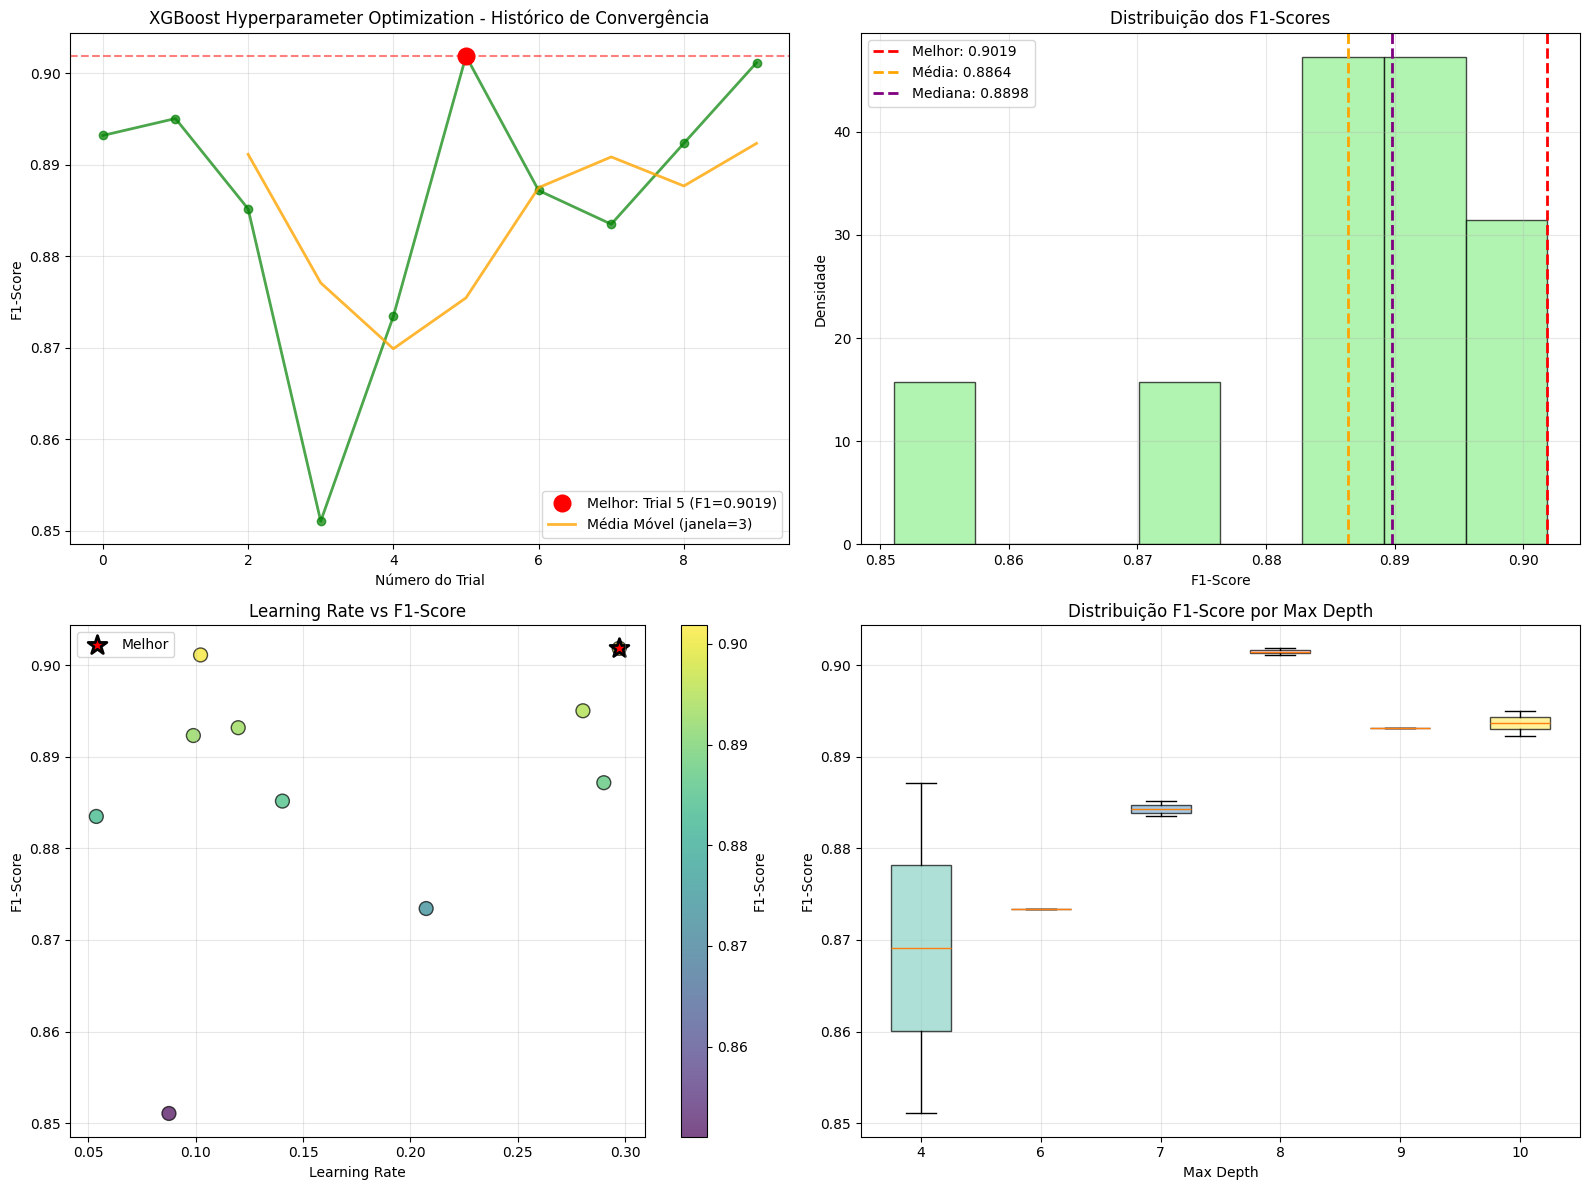


📋 ANÁLISE DETALHADA DOS TRIALS - XGBOOST
📊 Estatísticas dos Trials:
   - Total de trials: 10
   - Trials completados: 10
   - Melhor F1-Score: 0.9019
   - Pior F1-Score: 0.8510
   - F1-Score médio: 0.8864
   - Desvio padrão: 0.0143
   - Mediana: 0.8898
   - Quartil 25%: 0.8839
   - Quartil 75%: 0.8946

🏆 Top 5 Melhores Trials:

   🥇 #1 - Trial 5: F1=0.9019
      - learning_rate: 0.2972191430989131
      - max_depth: 8
      - subsample: 0.8980029206763108
      - n_estimators: 170
      - colsample_bytree: 0.9399965657235028
      - reg_alpha: 0.7629017610879284
      - reg_lambda: 0.7154314910970355

   🥇 #2 - Trial 9: F1=0.9011
      - learning_rate: 0.10230064282964879
      - max_depth: 8
      - subsample: 0.7957314198716317
      - n_estimators: 189
      - colsample_bytree: 0.8862659164509501
      - reg_alpha: 0.28244235429798115
      - reg_lambda: 0.7297251605315995

   🥇 #3 - Trial 1: F1=0.8950
      - learning_rate: 0.2803177505270125
      - max_depth: 10
      - subsampl

In [19]:
import optuna
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ================================================
# DESABILITAR LOGS VERBOSOS DO OPTUNA
# ================================================

optuna.logging.set_verbosity(optuna.logging.WARNING)

# ================================================
# FUNÇÃO DE OBJETIVO PARA XGBOOST
# ================================================

def objective_xgb(trial):
    """Função de objetivo para otimização do XGBoost"""
    
    # Hiperparâmetros a serem otimizados
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'eval_metric': 'logloss',
        'random_state': 42,  # Para reprodutibilidade
        'verbosity': 0  # Silenciar logs do XGBoost
    }

    try:
        # Modelo e avaliação com validação cruzada
        model = XGBClassifier(**params)
        score = cross_val_score(model, X_train_glove, y_train, cv=3, scoring='f1').mean()
        return score
    
    except Exception as e:
        print(f"❌ Erro no trial {trial.number}: {e}")
        return 0.0  # Retornar score baixo em caso de erro

# ================================================
# VERIFICAR DADOS ANTES DA OTIMIZAÇÃO
# ================================================

print("🔍 Verificando dados para otimização XGBoost...")
print("="*50)

try:
    print(f"📊 X_train_glove shape: {X_train_glove.shape}")
    print(f"📊 y_train shape: {y_train.shape}")
    print(f"📊 Tipo X_train_glove: {type(X_train_glove)}")
    print(f"📊 Tipo y_train: {type(y_train)}")
    print(f"🏷️  Classes únicas: {np.unique(y_train)}")
    print(f"📈 Distribuição de classes: {np.bincount(y_train)}")
    
    # Verificar se há valores NaN
    if hasattr(X_train_glove, 'isna'):
        nan_count = X_train_glove.isna().sum().sum()
    else:
        nan_count = np.isnan(X_train_glove).sum()
    
    print(f"🔍 Valores NaN em X_train_glove: {nan_count}")
    
except NameError as e:
    print(f"❌ Variável não encontrada: {e}")
    print("💡 Certifique-se de ter executado o pré-processamento GloVe primeiro")
    exit()

# ================================================
# EXECUTAR OTIMIZAÇÃO
# ================================================

print(f"\n🚀 Iniciando otimização de hiperparâmetros para XGBoost...")
print("="*60)

# Criar estudo Optuna
study_xgb = optuna.create_study(
    direction='maximize', 
    pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=5)
)

print(f"⚡ Executando otimização com 10 trials...")
print(f"⏱️  Isso pode levar alguns minutos...")

# Executar otimização (n_jobs=1 para evitar problemas de paralelização)
try:
    study_xgb.optimize(objective_xgb, n_trials=10, n_jobs=1, show_progress_bar=True)
    
    print(f"\n🎉 Otimização concluída!")
    print(f"✅ Melhor F1-Score: {study_xgb.best_value:.4f}")
    print(f"🎯 Melhores parâmetros para XGBoost:")
    for param, value in study_xgb.best_params.items():
        print(f"   - {param}: {value}")
    
except Exception as e:
    print(f"❌ Erro durante otimização: {e}")
    exit()

# ================================================
# VISUALIZAÇÃO PERSONALIZADA (SEM PLOTLY)
# ================================================

def plot_xgboost_optimization_history(study, title="XGBoost Optimization"):
    """Cria gráfico de histórico de otimização usando matplotlib"""
    
    print(f"\n📊 Criando visualização personalizada para XGBoost...")
    
    # Extrair dados dos trials
    trials = study.trials
    completed_trials = [t for t in trials if t.value is not None]
    
    if not completed_trials:
        print("❌ Nenhum trial válido para plotar")
        return
    
    # Dados para o gráfico
    trial_numbers = [t.number for t in completed_trials]
    values = [t.value for t in completed_trials]
    
    # Criar figura com subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # ================================================
    # SUBPLOT 1: HISTÓRICO DE OTIMIZAÇÃO
    # ================================================
    
    ax1.plot(trial_numbers, values, 'g-o', alpha=0.7, linewidth=2, markersize=6)
    
    # Destacar melhor resultado
    best_idx = np.argmax(values)
    best_trial = trial_numbers[best_idx]
    best_value = values[best_idx]
    
    ax1.plot(best_trial, best_value, 'ro', markersize=12, 
            label=f'Melhor: Trial {best_trial} (F1={best_value:.4f})')
    
    # Linha do melhor valor
    ax1.axhline(y=best_value, color='r', linestyle='--', alpha=0.5)
    
    # Média móvel
    if len(values) >= 3:
        window_size = min(3, len(values))
        moving_avg = np.convolve(values, np.ones(window_size)/window_size, mode='valid')
        moving_trials = trial_numbers[window_size-1:]
        ax1.plot(moving_trials, moving_avg, 'orange', linewidth=2, alpha=0.8, 
                label=f'Média Móvel (janela={window_size})')
    
    ax1.set_xlabel('Número do Trial')
    ax1.set_ylabel('F1-Score')
    ax1.set_title(f'{title} - Histórico de Convergência')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # ================================================
    # SUBPLOT 2: DISTRIBUIÇÃO DOS SCORES
    # ================================================
    
    ax2.hist(values, bins=min(8, len(values)), alpha=0.7, color='lightgreen', 
            edgecolor='black', density=True)
    ax2.axvline(best_value, color='red', linestyle='--', linewidth=2, 
               label=f'Melhor: {best_value:.4f}')
    ax2.axvline(np.mean(values), color='orange', linestyle='--', linewidth=2, 
               label=f'Média: {np.mean(values):.4f}')
    ax2.axvline(np.median(values), color='purple', linestyle='--', linewidth=2, 
               label=f'Mediana: {np.median(values):.4f}')
    
    ax2.set_xlabel('F1-Score')
    ax2.set_ylabel('Densidade')
    ax2.set_title('Distribuição dos F1-Scores')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # ================================================
    # SUBPLOT 3: ANÁLISE DE PARÂMETROS (LEARNING RATE vs F1)
    # ================================================
    
    learning_rates = []
    f1_scores = []
    
    for trial in completed_trials:
        if 'learning_rate' in trial.params:
            learning_rates.append(trial.params['learning_rate'])
            f1_scores.append(trial.value)
    
    if learning_rates:
        scatter = ax3.scatter(learning_rates, f1_scores, c=f1_scores, 
                            cmap='viridis', s=100, alpha=0.7, edgecolors='black')
        ax3.set_xlabel('Learning Rate')
        ax3.set_ylabel('F1-Score')
        ax3.set_title('Learning Rate vs F1-Score')
        ax3.grid(True, alpha=0.3)
        
        # Colorbar
        cbar = plt.colorbar(scatter, ax=ax3)
        cbar.set_label('F1-Score')
        
        # Destacar melhor ponto
        best_trial_obj = completed_trials[best_idx]
        if 'learning_rate' in best_trial_obj.params:
            best_lr = best_trial_obj.params['learning_rate']
            ax3.scatter(best_lr, best_value, color='red', s=200, marker='*', 
                       edgecolors='black', linewidth=2, label='Melhor')
            ax3.legend()
    
    # ================================================
    # SUBPLOT 4: MAX_DEPTH vs F1-SCORE
    # ================================================
    
    max_depths = []
    f1_scores_depth = []
    
    for trial in completed_trials:
        if 'max_depth' in trial.params:
            max_depths.append(trial.params['max_depth'])
            f1_scores_depth.append(trial.value)
    
    if max_depths:
        # Box plot por max_depth
        unique_depths = sorted(set(max_depths))
        depth_groups = []
        
        for depth in unique_depths:
            depth_scores = [f1_scores_depth[i] for i, d in enumerate(max_depths) if d == depth]
            depth_groups.append(depth_scores)
        
        if depth_groups:
            bp = ax4.boxplot(depth_groups, labels=unique_depths, patch_artist=True)
            
            # Colorir boxes
            colors = plt.cm.Set3(np.linspace(0, 1, len(bp['boxes'])))
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
        
        ax4.set_xlabel('Max Depth')
        ax4.set_ylabel('F1-Score')
        ax4.set_title('Distribuição F1-Score por Max Depth')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# ================================================
# ANÁLISE DETALHADA DOS TRIALS XGBOOST
# ================================================

def analyze_xgboost_trials_detailed(study):
    """Análise detalhada dos trials do XGBoost"""
    
    print(f"\n📋 ANÁLISE DETALHADA DOS TRIALS - XGBOOST")
    print("="*60)
    
    trials = study.trials
    completed_trials = [t for t in trials if t.value is not None]
    
    if not completed_trials:
        print("❌ Nenhum trial completado")
        return
    
    values = [t.value for t in completed_trials]
    
    print(f"📊 Estatísticas dos Trials:")
    print(f"   - Total de trials: {len(trials)}")
    print(f"   - Trials completados: {len(completed_trials)}")
    print(f"   - Melhor F1-Score: {max(values):.4f}")
    print(f"   - Pior F1-Score: {min(values):.4f}")
    print(f"   - F1-Score médio: {np.mean(values):.4f}")
    print(f"   - Desvio padrão: {np.std(values):.4f}")
    print(f"   - Mediana: {np.median(values):.4f}")
    print(f"   - Quartil 25%: {np.percentile(values, 25):.4f}")
    print(f"   - Quartil 75%: {np.percentile(values, 75):.4f}")
    
    print(f"\n🏆 Top 5 Melhores Trials:")
    sorted_trials = sorted(completed_trials, key=lambda x: x.value, reverse=True)
    
    for i, trial in enumerate(sorted_trials[:5]):
        print(f"\n   🥇 #{i+1} - Trial {trial.number}: F1={trial.value:.4f}")
        for param, value in trial.params.items():
            if param not in ['eval_metric', 'random_state', 'verbosity']:
                print(f"      - {param}: {value}")
    
    # Análise de correlação entre parâmetros e performance
    print(f"\n📈 ANÁLISE DE CORRELAÇÃO PARÂMETROS vs PERFORMANCE:")
    
    param_names = ['learning_rate', 'max_depth', 'subsample', 'n_estimators']
    
    for param_name in param_names:
        param_values = []
        param_scores = []
        
        for trial in completed_trials:
            if param_name in trial.params:
                param_values.append(trial.params[param_name])
                param_scores.append(trial.value)
        
        if len(param_values) > 1:
            correlation = np.corrcoef(param_values, param_scores)[0, 1]
            print(f"   - {param_name}: correlação = {correlation:.3f}")

# ================================================
# TREINAR MODELO FINAL XGBOOST
# ================================================

def train_final_xgboost_model(study):
    """Treina modelo XGBoost final com os melhores parâmetros"""
    
    print(f"\n🎯 TREINANDO MODELO XGBOOST FINAL")
    print("="*60)
    
    if not study.best_params:
        print("❌ Nenhum parâmetro ótimo encontrado")
        return None
    
    try:
        # Criar modelo com melhores parâmetros
        best_xgb_model = XGBClassifier(**study.best_params)
        
        # Treinar modelo
        print("🏋️ Treinando modelo XGBoost...")
        best_xgb_model.fit(X_train_glove, y_train)
        
        # Fazer predições
        print("📊 Fazendo predições...")
        y_pred_xgb_optimized = best_xgb_model.predict(X_test_glove)
        y_proba_xgb_optimized = best_xgb_model.predict_proba(X_test_glove)[:, 1]
        
        # Avaliar modelo otimizado
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
        
        print(f"\n📊 RESULTADOS DO XGBOOST OTIMIZADO:")
        print("="*50)
        
        accuracy = accuracy_score(y_test, y_pred_xgb_optimized)
        precision = precision_score(y_test, y_pred_xgb_optimized, zero_division=0)
        recall = recall_score(y_test, y_pred_xgb_optimized, zero_division=0)
        f1 = f1_score(y_test, y_pred_xgb_optimized, zero_division=0)
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        
        print(f"\n📋 Relatório Detalhado:")
        print(classification_report(y_test, y_pred_xgb_optimized, 
                                  target_names=['Fake News', 'Real News'], digits=4))
        
        # Comparar com modelo original (se existir)
        try:
            if 'y_pred_glove' in globals():
                original_f1 = f1_score(y_test, y_pred_glove)
                improvement = ((f1 - original_f1) / original_f1) * 100
                
                print(f"\n📈 COMPARAÇÃO COM MODELO ORIGINAL:")
                print(f"   - F1 Original: {original_f1:.4f}")
                print(f"   - F1 Otimizado: {f1:.4f}")
                print(f"   - Melhoria: {improvement:+.2f}%")
                
                if improvement > 0:
                    print(f"🎉 Modelo otimizado é {improvement:.1f}% melhor!")
                else:
                    print(f"⚠️  Modelo original era {abs(improvement):.1f}% melhor")
            else:
                print(f"💡 Variável y_pred_glove não encontrada para comparação")
                
        except Exception as e:
            print(f"⚠️  Erro na comparação: {e}")
        
        # Importância das features (top 15)
        if hasattr(best_xgb_model, 'feature_importances_'):
            print(f"\n🔍 TOP 15 FEATURES MAIS IMPORTANTES:")
            feature_importance = best_xgb_model.feature_importances_
            top_indices = np.argsort(feature_importance)[-15:][::-1]
            
            for i, idx in enumerate(top_indices):
                print(f"   {i+1:2d}. Feature {idx:3d}: {feature_importance[idx]:.4f}")
        
        return best_xgb_model, y_pred_xgb_optimized, y_proba_xgb_optimized
        
    except Exception as e:
        print(f"❌ Erro ao treinar modelo XGBoost final: {e}")
        return None, None, None

# ================================================
# EXECUTAR ANÁLISES
# ================================================

# 1. Criar visualização personalizada
plot_xgboost_optimization_history(study_xgb, "XGBoost Hyperparameter Optimization")

# 2. Análise detalhada
analyze_xgboost_trials_detailed(study_xgb)

# 3. Treinar modelo final
final_xgb_model, y_pred_xgb_optimized, y_proba_xgb_optimized = train_final_xgboost_model(study_xgb)

# ================================================
# SALVAR RESULTADOS XGBOOST
# ================================================

def save_xgboost_optimization_results(study, filename="xgboost_optimization.txt"):
    """Salva resultados da otimização XGBoost em arquivo"""
    
    try:
        with open(filename, 'w', encoding='utf-8') as f:
            f.write("RESULTADOS DA OTIMIZAÇÃO - XGBOOST\n")
            f.write("="*60 + "\n\n")
            
            f.write(f"Melhor F1-Score: {study.best_value:.4f}\n")
            f.write(f"Melhores Parâmetros:\n")
            for param, value in study.best_params.items():
                f.write(f"  - {param}: {value}\n")
            
            f.write(f"\nTodos os Trials:\n")
            for trial in study.trials:
                if trial.value is not None:
                    f.write(f"Trial {trial.number}: F1={trial.value:.4f}\n")
                    for param, value in trial.params.items():
                        f.write(f"  {param}: {value}\n")
                    f.write("\n")
        
        print(f"💾 Resultados XGBoost salvos em: {filename}")
        
    except Exception as e:
        print(f"❌ Erro ao salvar resultados: {e}")

# Salvar resultados
save_xgboost_optimization_results(study_xgb)

print(f"\n🎉 OTIMIZAÇÃO DE XGBOOST CONCLUÍDA!")
print(f"🏆 Melhor F1-Score: {study_xgb.best_value:.4f}")
print(f"⚙️  Melhores parâmetros salvos e modelo treinado!")

# 16. Otimizando o modelo BERT + Fine-Tunning

In [32]:
# ================================================
# BERT CORRIGIDO - VERSÃO FINAL COM PROBABILIDADES E MODELO SALVO
# ================================================

import torch
import torch.nn.functional as F  # 🔧 Movido para o topo
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import time
import gc
import warnings
import random
warnings.filterwarnings('ignore')

# =========================================================
# CÉLULA DE FUNÇÕES DE AJUDA PARA O BERT
# Coloque este código em uma única célula e execute-a.
# =========================================================

def setup_device():
    """Setup do device"""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.cuda.empty_cache()
        print(f"🔥 GPU: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device('cpu')
        print("💻 CPU")
    return device

class SimpleDataset(Dataset):
    """Dataset simples"""
    def __init__(self, texts, labels, tokenizer, max_len=32):
        self.encodings = tokenizer(
            list(texts),
            truncation=True,
            padding='max_length',
            max_length=max_len,
            return_tensors='pt'
        )
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

def create_sample_data(X, y):
    """Cria amostra dos dados"""
    total_size = len(X)
    # Garante que o sample_size não exceda o total de dados disponíveis
    sample_size = min(
        BERT_CONFIG['max_samples'],
        int(total_size * BERT_CONFIG['dataset_percentage']),
        total_size
    )
    sample_size = max(100, sample_size)  # Mínimo de 100 amostras

    print(f"📊 Criando amostra de {sample_size} registros de {total_size:,} totais")
    
    df = pd.DataFrame({'text': X, 'label': y})
    
    # Amostra estratificada para manter a proporção das classes
    if len(df['label'].unique()) > 1:
        try:
            sampled_df = df.groupby('label', group_keys=False).apply(
                lambda x: x.sample(n=min(len(x), int(sample_size * len(x) / len(df))), 
                random_state=BERT_CONFIG['random_state'])
            )
        except:
             sampled_df = df.sample(n=sample_size, random_state=BERT_CONFIG['random_state'])
    else:
        sampled_df = df.sample(n=sample_size, random_state=BERT_CONFIG['random_state'])

    sampled_df = sampled_df.sample(frac=1, random_state=BERT_CONFIG['random_state']).reset_index(drop=True)
    
    print(f"✅ Amostra criada: {len(sampled_df)} registros")
    print(f"📊 Distribuição: {sampled_df['label'].value_counts(normalize=True).sort_index().to_dict()}")
    
    return sampled_df['text'].values, sampled_df['label'].values

def run_emergency_bert():
    """Versão de emergência ultra-simples"""
    global y_true_bert, y_pred_bert, y_proba_bert, best_bert_model, bert_tokenizer
    print("🚨 BERT EMERGÊNCIA - ULTRA SIMPLES")
    print("💡 Função de emergência ainda não implementada em detalhes, pulando.")
    return None

# ================================================
# VARIÁVEIS GLOBAIS - INCLUINDO MODELO E TOKENIZER
# ================================================
y_true_bert = None
y_pred_bert = None
y_proba_bert = None
best_bert_model = None  # ✅ NOVO: Variável global para o modelo
bert_tokenizer = None   # ✅ NOVO: Variável global para o tokenizer

# ================================================
# CONFIGURAÇÃO CORRIGIDA
# ================================================

BERT_CONFIG = {
    'dataset_percentage': 0.50,
    'max_samples': 10000,
    'max_length': 32,
    'num_trials': 3,
    'max_time_per_trial': 300,
    'random_state': 42,
}

def train_single_bert_trial(trial_num, learning_rate, batch_size):
    """Treina um único trial do BERT"""
    # 👉 Referenciando as variáveis globais que vamos modificar
    global y_true_bert, y_pred_bert, y_proba_bert
    
    trial_start = time.time()
    print(f"🚀 Trial {trial_num}: lr={learning_rate:.2e}, batch={batch_size}")
    
    device = setup_device()
    
    try:
        if 'X' not in globals() or 'y' not in globals():
            raise ValueError("Dados X e y não encontrados")
        
        X_sample, y_sample = create_sample_data(X, y)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X_sample, y_sample,
            test_size=0.3,
            random_state=BERT_CONFIG['random_state'],
            stratify=y_sample
        )
        
        print(f"   📊 Treino: {len(X_train)}, Teste: {len(X_test)}")
        
        tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
        
        print("   📦 Criando datasets...")
        train_dataset = SimpleDataset(X_train, y_train, tokenizer, BERT_CONFIG['max_length'])
        test_dataset = SimpleDataset(X_test, y_test, tokenizer, BERT_CONFIG['max_length'])
        
        print("   🤖 Carregando modelo...")
        model = AutoModelForSequenceClassification.from_pretrained(
            "distilbert-base-uncased",
            num_labels=2
        ).to(device)
        
        training_args = TrainingArguments(
            output_dir=f"./trial_{trial_num}",
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=1,
            learning_rate=learning_rate,
            eval_strategy="no",
            save_strategy="no",
            logging_steps=1000,
            report_to=[],
            fp16=torch.cuda.is_available(),
            dataloader_num_workers=0,
            remove_unused_columns=True,
            disable_tqdm=True,
            seed=BERT_CONFIG['random_state'],
        )
        
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
        )
        
        # Treinamento
        print("   🏃 Treinando...")
        trainer.train()
        
        # Predições
        print("   🔮 Predições...")
        predictions_output = trainer.predict(test_dataset)
        
        # ✅ ================================================================
        # ✅ PASSO CRÍTICO: EXTRAIR LOGITS E CALCULAR PROBABILIDADES
        # ✅ ================================================================
        logits = predictions_output.predictions
        
        # Converter logits para probabilidades usando a função Softmax
        probabilities = F.softmax(torch.tensor(logits), dim=1).numpy()
        
        # A classe prevista é o argmax (índice da maior probabilidade)
        y_pred = np.argmax(probabilities, axis=1)
        
        # Para AUROC, precisamos das probabilidades da classe positiva (classe 1)
        y_proba = probabilities[:, 1]
        
        print(f"   📊 Probabilidades da classe positiva extraídas: shape={y_proba.shape}")
        
        # Métricas
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='binary')
        
        trial_time = time.time() - trial_start
        
        print(f"   ✅ Trial {trial_num}: Acc={accuracy:.4f}, F1={f1:.4f}, Tempo={trial_time:.1f}s")
        
        # ✅ ================================================================
        # ✅ IMPORTANTE: NÃO DELETAR O MODELO AINDA - VAMOS RETORNÁ-LO
        # ✅ ================================================================
        
        # Limpeza PARCIAL (manter modelo e tokenizer para o melhor trial)
        del train_dataset, test_dataset, predictions_output, logits, probabilities
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        
        # ✅ ================================================================
        # ✅ RETORNAR MODELO E TOKENIZER PARA SEREM SALVOS GLOBALMENTE
        # ✅ ================================================================
        return {
            'trial': trial_num,
            'accuracy': accuracy,
            'f1_score': f1,
            'time': trial_time,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'success': True,
            'y_true': y_test,
            'y_pred': y_pred,
            'y_proba': y_proba,
            'model': model,      # ✅ RETORNAR O MODELO TREINADO
            'tokenizer': tokenizer,  # ✅ RETORNAR O TOKENIZER
            'trainer': trainer   # ✅ OPCIONAL: Retornar trainer também
        }
        
    except Exception as e:
        print(f"   ❌ Trial {trial_num} falhou: {e}")
        
        # Limpeza em caso de erro
        try:
            if 'model' in locals():
                del model
            if 'trainer' in locals():
                del trainer
            if 'train_dataset' in locals():
                del train_dataset
            if 'test_dataset' in locals():
                del test_dataset
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
        except:
            pass
            
        return {'success': False, 'error': str(e)}

def run_bert_optimization():
    """Executa otimização do BERT e salva os resultados do melhor trial."""
    # ✅ ================================================================
    # ✅ REFERENCIAR TODAS AS VARIÁVEIS GLOBAIS QUE VAMOS MODIFICAR
    # ✅ ================================================================
    global y_true_bert, y_pred_bert, y_proba_bert, best_bert_model, bert_tokenizer
    
    print("🔥 BERT OTIMIZAÇÃO - VERSÃO FINAL COM MODELO SALVO")
    print("=" * 60)
    
    if 'X' not in globals() or 'y' not in globals():
        print("❌ Execute primeiro o carregamento de dados!")
        return None
    
    start_time = time.time()
    
    test_configs = [
        {'lr': 5e-5, 'batch': 8},
        {'lr': 3e-5, 'batch': 16},
        {'lr': 1e-4, 'batch': 8},
    ]
    
    results = []
    
    for i, config in enumerate(test_configs[:BERT_CONFIG['num_trials']]):
        result = train_single_bert_trial(
            trial_num=i,
            learning_rate=config['lr'],
            batch_size=config['batch']
        )
        results.append(result)
        
        # Timeout check (sua lógica original)
        if time.time() - start_time > BERT_CONFIG['max_time_per_trial'] * len(test_configs):
            print(f"⏰ Timeout atingido, parando trials...")
            break
    
    total_time = time.time() - start_time
    
    successful_results = [r for r in results if r.get('success')]
    
    print(f"\n🎉 OTIMIZAÇÃO CONCLUÍDA!")
    print(f"⏱️  Tempo total: {total_time/60:.2f} minutos")
    print(f"✅ Trials bem-sucedidos: {len(successful_results)}/{len(results)}")
    
    if successful_results:
        # Encontrar o melhor trial baseado no F1-score
        best_result = max(successful_results, key=lambda x: x['f1_score'])
        
        # ✅ ================================================================
        # ✅ SALVAR RESULTADOS, MODELO E TOKENIZER GLOBALMENTE
        # ✅ ================================================================
        print(f"\n💾 Salvando resultados e modelo do melhor trial...")
        
        # Salvar resultados (como antes)
        y_true_bert = best_result['y_true']
        y_pred_bert = best_result['y_pred']
        y_proba_bert = best_result['y_proba']
        
        # ✅ SALVAR MODELO E TOKENIZER GLOBALMENTE
        best_bert_model = best_result['model']
        bert_tokenizer = best_result['tokenizer']
        
        print(f"\n📊 RESULTADOS GERAIS:")
        print("-" * 40)
        
        for i, result in enumerate(successful_results):
            status = "🏆" if result == best_result else "  "
            print(f"{status} Trial {result['trial']}: "
                  f"Acc={result['accuracy']:.4f}, "
                  f"F1={result['f1_score']:.4f}, "
                  f"Tempo={result['time']:.1f}s")
        
        print(f"\n🏆 MELHOR MODELO:")
        print(f"   - Trial: {best_result['trial']}")
        print(f"   - F1-Score: {best_result['f1_score']:.4f}")
        print(f"   - Accuracy: {best_result['accuracy']:.4f}")
        print(f"   - Learning Rate: {best_result['learning_rate']:.2e}")
        print(f"   - Batch Size: {best_result['batch_size']}")
        
        # ✅ ================================================================
        # ✅ CONFIRMAÇÃO DE QUE TUDO FOI SALVO
        # ✅ ================================================================
        if (y_true_bert is not None and y_pred_bert is not None and 
            y_proba_bert is not None and best_bert_model is not None and 
            bert_tokenizer is not None):
            
            print(f"\n✅ TODAS AS VARIÁVEIS GLOBAIS CRIADAS E PRONTAS:")
            print(f"   - y_true_bert: {len(y_true_bert)} elementos")
            print(f"   - y_pred_bert: {len(y_pred_bert)} elementos")
            print(f"   - y_proba_bert: {len(y_proba_bert)} elementos")
            print(f"   - best_bert_model: {type(best_bert_model).__name__} salvo")
            print(f"   - bert_tokenizer: {type(bert_tokenizer).__name__} salvo")
            print(f"\n🎯 AGORA O BERT ESTÁ PRONTO PARA EXPLICABILIDADE SHAP!")
        
        # ✅ ================================================================
        # ✅ LIMPEZA DOS MODELOS NÃO SELECIONADOS
        # ✅ ================================================================
        print(f"\n🧹 Limpando modelos não selecionados...")
        for result in successful_results:
            if result != best_result:
                try:
                    if 'model' in result:
                        del result['model']
                    if 'trainer' in result:
                        del result['trainer']
                    if 'tokenizer' in result:
                        del result['tokenizer']
                except:
                    pass
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        
        print(f"✅ Limpeza concluída - apenas o melhor modelo foi mantido")
        
        return best_result
    
    else:
        print("❌ Nenhum trial foi bem-sucedido. Ativando modo de emergência...")
        return run_emergency_bert()

# ================================================
# FUNÇÃO AUXILIAR PARA VERIFICAR MODELO SALVO
# ================================================

def check_bert_model_status():
    """Verifica se o modelo BERT foi salvo corretamente"""
    print("\n🔍 VERIFICANDO STATUS DO MODELO BERT:")
    print("=" * 50)
    
    global y_true_bert, y_pred_bert, y_proba_bert, best_bert_model, bert_tokenizer
    
    status = {
        'y_true_bert': y_true_bert is not None,
        'y_pred_bert': y_pred_bert is not None,
        'y_proba_bert': y_proba_bert is not None,
        'best_bert_model': best_bert_model is not None,
        'bert_tokenizer': bert_tokenizer is not None
    }
    
    for var_name, is_available in status.items():
        icon = "✅" if is_available else "❌"
        print(f"{icon} {var_name}: {'Disponível' if is_available else 'Não encontrado'}")
    
    if all(status.values()):
        print(f"\n🎉 BERT COMPLETAMENTE PRONTO PARA EXPLICABILIDADE!")
        
        # Teste rápido do modelo
        try:
            print(f"\n🧪 Teste rápido do modelo:")
            test_text = ["This is a test sentence for BERT."]
            inputs = bert_tokenizer(test_text, return_tensors="pt", truncation=True, padding=True)
            
            with torch.no_grad():
                outputs = best_bert_model(**inputs)
                probabilities = F.softmax(outputs.logits, dim=1)
                print(f"   - Modelo responde corretamente: ✅")
                print(f"   - Probabilidades: {probabilities.numpy()[0]}")
        
        except Exception as e:
            print(f"   - Erro no teste: {e}")
    
    else:
        missing = [var for var, available in status.items() if not available]
        print(f"\n⚠️  Variáveis faltando: {missing}")
        print(f"💡 Execute run_bert_optimization() novamente")
    
    return all(status.values())

# ================================================
# EXECUTAR
# ================================================

if __name__ == "__main__":
    print("🔥 BERT CORRIGIDO - COM MODELO E TOKENIZER SALVOS")
    print("=" * 60)

    result = run_bert_optimization()

    if result and result['success']:
        print(f"\n🎉 BERT CONCLUÍDO COM SUCESSO!")
        print(f"🎯 Accuracy: {result.get('accuracy', 0):.4f}")
        print(f"⚖️  F1-Score: {result.get('f1_score', 0):.4f}")
        
        # Verificar status final
        check_bert_model_status()
        
    else:
        print("❌ BERT falhou completamente")
    
    print(f"\n🔧 MELHORIAS APLICADAS:")
    print(f" ✅ Modelo e tokenizer salvos globalmente")
    print(f" ✅ Variáveis globais: best_bert_model, bert_tokenizer")
    print(f" ✅ Limpeza inteligente de modelos não selecionados")
    print(f" ✅ Função de verificação de status")
    print(f" ✅ Pronto para explicabilidade SHAP!")

🔥 BERT CORRIGIDO - COM MODELO E TOKENIZER SALVOS
🔥 BERT OTIMIZAÇÃO - VERSÃO FINAL COM MODELO SALVO
🚀 Trial 0: lr=5.00e-05, batch=8
🔥 GPU: NVIDIA GeForce RTX 3070 Laptop GPU
📊 Criando amostra de 10000 registros de 76,537 totais
✅ Amostra criada: 9999 registros
📊 Distribuição: {0: 0.5021502150215021, 1: 0.49784978497849786}
   📊 Treino: 6999, Teste: 3000
   📦 Criando datasets...
   🤖 Carregando modelo...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   🏃 Treinando...
{'train_runtime': 39.7716, 'train_samples_per_second': 175.98, 'train_steps_per_second': 22.001, 'train_loss': 0.26012391880580354, 'epoch': 1.0}
   🔮 Predições...
   📊 Probabilidades da classe positiva extraídas: shape=(3000,)
   ✅ Trial 0: Acc=0.9323, F1=0.9298, Tempo=53.8s
🚀 Trial 1: lr=3.00e-05, batch=16
🔥 GPU: NVIDIA GeForce RTX 3070 Laptop GPU
📊 Criando amostra de 10000 registros de 76,537 totais
✅ Amostra criada: 9999 registros
📊 Distribuição: {0: 0.5021502150215021, 1: 0.49784978497849786}
   📊 Treino: 6999, Teste: 3000
   📦 Criando datasets...
   🤖 Carregando modelo...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   🏃 Treinando...
{'train_runtime': 20.1132, 'train_samples_per_second': 347.981, 'train_steps_per_second': 21.777, 'train_loss': 0.2448820697662493, 'epoch': 1.0}
   🔮 Predições...
   📊 Probabilidades da classe positiva extraídas: shape=(3000,)
   ✅ Trial 1: Acc=0.9293, F1=0.9264, Tempo=30.5s
🚀 Trial 2: lr=1.00e-04, batch=8
🔥 GPU: NVIDIA GeForce RTX 3070 Laptop GPU
📊 Criando amostra de 10000 registros de 76,537 totais
✅ Amostra criada: 9999 registros
📊 Distribuição: {0: 0.5021502150215021, 1: 0.49784978497849786}
   📊 Treino: 6999, Teste: 3000
   📦 Criando datasets...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   🤖 Carregando modelo...
   🏃 Treinando...
{'train_runtime': 39.6994, 'train_samples_per_second': 176.3, 'train_steps_per_second': 22.041, 'train_loss': 0.2944603794642857, 'epoch': 1.0}
   🔮 Predições...
   📊 Probabilidades da classe positiva extraídas: shape=(3000,)
   ✅ Trial 2: Acc=0.9220, F1=0.9190, Tempo=55.5s

🎉 OTIMIZAÇÃO CONCLUÍDA!
⏱️  Tempo total: 2.35 minutos
✅ Trials bem-sucedidos: 3/3

💾 Salvando resultados e modelo do melhor trial...

📊 RESULTADOS GERAIS:
----------------------------------------
🏆 Trial 0: Acc=0.9323, F1=0.9298, Tempo=53.8s
   Trial 1: Acc=0.9293, F1=0.9264, Tempo=30.5s
   Trial 2: Acc=0.9220, F1=0.9190, Tempo=55.5s

🏆 MELHOR MODELO:
   - Trial: 0
   - F1-Score: 0.9298
   - Accuracy: 0.9323
   - Learning Rate: 5.00e-05
   - Batch Size: 8

✅ TODAS AS VARIÁVEIS GLOBAIS CRIADAS E PRONTAS:
   - y_true_bert: 3000 elementos
   - y_pred_bert: 3000 elementos
   - y_proba_bert: 3000 elementos
   - best_bert_model: DistilBertForSequenceClassification salvo
   - be

# 17. Exibição das melhorias

In [37]:
# ================================================
# AVALIAÇÃO DE MODELOS OTIMIZADOS - VERSÃO COM TABELA COMPLETA
# ================================================

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# ================================================
# FUNÇÃO PARA VERIFICAR SE VARIÁVEL EXISTE
# ================================================

def check_variable_exists(var_name):
    """Verifica se uma variável existe no escopo global"""
    return var_name in globals() and globals()[var_name] is not None

def get_variable_safe(var_name, default=None):
    """Obtém variável de forma segura"""
    if check_variable_exists(var_name):
        return globals()[var_name]
    return default

# ================================================
# FUNÇÃO PARA CRIAR MODELOS SEGUROS
# ================================================

def create_safe_model(model_class, optimized_params=None, **default_params):
    """
    Cria modelo evitando conflitos de parâmetros
    """
    try:
        # Se não há parâmetros otimizados, usar apenas os padrões
        if optimized_params is None:
            optimized_params = {}
        
        # Combinar parâmetros otimizados com padrões
        final_params = default_params.copy()
        final_params.update(optimized_params)  # Parâmetros otimizados têm prioridade
        
        print(f"   🔧 Criando {model_class.__name__} com parâmetros:")
        for param, value in final_params.items():
            print(f"      - {param}: {value}")
        
        model = model_class(**final_params)
        print(f"   ✅ Modelo criado com sucesso!")
        return model
        
    except TypeError as e:
        print(f"   ⚠️  Erro com parâmetros padrão: {e}")
        print(f"   🔄 Tentando apenas com parâmetros otimizados...")
        
        try:
            model = model_class(**optimized_params) if optimized_params else model_class()
            print(f"   ✅ Modelo criado com parâmetros básicos!")
            return model
        except Exception as e2:
            print(f"   ❌ Erro crítico: {e2}")
            return None

# ================================================
# FUNÇÃO PARA AVALIAÇÃO COMPLETA COM TODAS AS MÉTRICAS
# ================================================

def comprehensive_evaluate_model(model, X_test, y_test, model_name):
    """
    Avalia modelo com todas as métricas necessárias
    """
    try:
        print(f"\n=== {model_name} ===")
        
        # Fazer predições
        y_pred = model.predict(X_test)
        
        # Calcular todas as métricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
        recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)
        
        print(f"Acurácia: {accuracy:.4f}")
        print(f"Precisão: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        
        # Relatório detalhado
        print(f"\nRelatório detalhado:")
        print(classification_report(y_test, y_pred, zero_division=0))
        
        return {
            'predictions': y_pred,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
        
    except Exception as e:
        print(f"❌ Erro na avaliação de {model_name}: {e}")
        return {
            'predictions': None,
            'accuracy': 0.0,
            'precision': 0.0,
            'recall': 0.0,
            'f1_score': 0.0
        }

# ================================================
# VERIFICAÇÃO DOS ESTUDOS
# ================================================

def check_study_results(study, study_name):
    """
    Verifica se o estudo tem resultados válidos
    """
    try:
        if study is None:
            print(f"⚠️  {study_name}: Estudo não encontrado")
            return False, {}
            
        if not hasattr(study, 'best_params') or not study.best_params:
            print(f"⚠️  {study_name}: Nenhum parâmetro otimizado encontrado")
            return False, {}
        
        print(f"✅ {study_name}: Parâmetros otimizados encontrados")
        print(f"   - Melhor score: {study.best_value:.4f}")
        print(f"   - Parâmetros: {study.best_params}")
        return True, study.best_params
        
    except Exception as e:
        print(f"❌ {study_name}: Erro ao verificar estudo - {e}")
        return False, {}

# ================================================
# VERIFICAR DADOS NECESSÁRIOS
# ================================================

print("🔍 Verificando dados necessários...")

# Verificar dados de treino e teste
required_vars = [
    'X_train_bow', 'X_test_bow', 'y_train', 'y_test',
    'X_train_tfidf', 'X_test_tfidf'
]

missing_vars = []
for var in required_vars:
    if not check_variable_exists(var):
        missing_vars.append(var)

if missing_vars:
    print(f"❌ Variáveis ausentes: {missing_vars}")
    print("💡 Execute primeiro o treinamento dos modelos tradicionais")
else:
    print("✅ Dados básicos encontrados")

# ================================================
# DICIONÁRIO PARA ARMAZENAR TODOS OS RESULTADOS
# ================================================

model_results = {}

# ================================================
# 1. NAIVE BAYES (BOW) - CORRIGIDO
# ================================================

print("\n🔍 Avaliando Naive Bayes...")

# Verificar se estudo existe
study_nb = get_variable_safe('study_nb')
has_study, best_params = check_study_results(study_nb, "Naive Bayes")

if check_variable_exists('X_train_bow') and check_variable_exists('X_test_bow'):
    try:
        # Usar parâmetros otimizados se disponíveis, senão usar padrões
        nb_params = best_params if has_study else {}
        
        best_nb_model = create_safe_model(
            MultinomialNB, 
            nb_params,
            alpha=1.0  # Parâmetro padrão
        )
        
        if best_nb_model is not None:
            best_nb_model.fit(X_train_bow, y_train)
            model_results['Naive Bayes (BoW)'] = comprehensive_evaluate_model(
                best_nb_model, X_test_bow, y_test, "Naive Bayes"
            )
        else:
            print("❌ Não foi possível criar modelo Naive Bayes")
            model_results['Naive Bayes (BoW)'] = {
                'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0
            }
            
    except Exception as e:
        print(f"❌ Erro no Naive Bayes: {e}")
        model_results['Naive Bayes (BoW)'] = {
            'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0
        }
else:
    print("❌ Dados BOW não encontrados")
    model_results['Naive Bayes (BoW)'] = {
        'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0
    }

# ================================================
# 2. LOGISTIC REGRESSION (TF-IDF) - CORRIGIDO
# ================================================

print("\n🔍 Avaliando Logistic Regression...")

# Verificar se estudo existe
study_lr = get_variable_safe('study_lr')
has_study, best_params = check_study_results(study_lr, "Logistic Regression")

if check_variable_exists('X_train_tfidf') and check_variable_exists('X_test_tfidf'):
    try:
        # Parâmetros padrão seguros
        default_lr_params = {
            'max_iter': 1000,
            'random_state': 42
        }
        
        lr_params = best_params if has_study else {}
        
        best_lr_model = create_safe_model(
            LogisticRegression,
            lr_params,
            **default_lr_params
        )
        
        if best_lr_model is not None:
            best_lr_model.fit(X_train_tfidf, y_train)
            model_results['Logistic Regression (TF-IDF)'] = comprehensive_evaluate_model(
                best_lr_model, X_test_tfidf, y_test, "Logistic Regression"
            )
        else:
            print("❌ Não foi possível criar modelo Logistic Regression")
            model_results['Logistic Regression (TF-IDF)'] = {
                'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0
            }
            
    except Exception as e:
        print(f"❌ Erro no Logistic Regression: {e}")
        model_results['Logistic Regression (TF-IDF)'] = {
            'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0
        }
else:
    print("❌ Dados TF-IDF não encontrados")
    model_results['Logistic Regression (TF-IDF)'] = {
        'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0
    }

# ================================================
# 3. RANDOM FOREST (WORD2VEC) - CORRIGIDO
# ================================================

print("\n🔍 Avaliando Random Forest...")

# Verificar se estudo existe
study_rf = get_variable_safe('study_rf')
has_study, best_params = check_study_results(study_rf, "Random Forest")

if check_variable_exists('X_train_w2v') and check_variable_exists('X_test_w2v'):
    try:
        default_rf_params = {
            'random_state': 42,
            'n_estimators': 100
        }
        
        rf_params = best_params if has_study else {}
        
        best_rf_model = create_safe_model(
            RandomForestClassifier,
            rf_params,
            **default_rf_params
        )
        
        if best_rf_model is not None:
            best_rf_model.fit(X_train_w2v, y_train)
            model_results['Random Forest (Word2Vec)'] = comprehensive_evaluate_model(
                best_rf_model, X_test_w2v, y_test, "Random Forest"
            )
        else:
            print("❌ Não foi possível criar modelo Random Forest")
            model_results['Random Forest (Word2Vec)'] = {
                'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0
            }
            
    except Exception as e:
        print(f"❌ Erro no Random Forest: {e}")
        model_results['Random Forest (Word2Vec)'] = {
            'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0
        }
else:
    print("❌ Dados Word2Vec não encontrados")
    model_results['Random Forest (Word2Vec)'] = {
        'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0
    }

# ================================================
# 4. XGBOOST (GLOVE) - CORRIGIDO
# ================================================

print("\n🔍 Avaliando XGBoost...")

# Verificar se estudo existe
study_xgb = get_variable_safe('study_xgb')
has_study, best_params = check_study_results(study_xgb, "XGBoost")

if check_variable_exists('X_train_glove') and check_variable_exists('X_test_glove'):
    try:
        default_xgb_params = {
            'eval_metric': 'logloss',
            'random_state': 42,
            'verbosity': 0
        }
        
        xgb_params = best_params if has_study else {}
        
        best_xgb_model = create_safe_model(
            XGBClassifier,
            xgb_params,
            **default_xgb_params
        )
        
        if best_xgb_model is not None:
            best_xgb_model.fit(X_train_glove, y_train)
            model_results['XGBoost (GloVe)'] = comprehensive_evaluate_model(
                best_xgb_model, X_test_glove, y_test, "XGBoost"
            )
        else:
            print("❌ Não foi possível criar modelo XGBoost")
            model_results['XGBoost (GloVe)'] = {
                'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0
            }
            
    except Exception as e:
        print(f"❌ Erro no XGBoost: {e}")
        model_results['XGBoost (GloVe)'] = {
            'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0
        }
else:
    print("❌ Dados GloVe não encontrados")
    model_results['XGBoost (GloVe)'] = {
        'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0
    }

# ================================================
# 5. BERT - CORRIGIDO
# ================================================

print("\n🔍 Avaliando BERT...")

# Verificar se temos resultados do BERT
try:
    # Verificar diferentes possíveis variáveis BERT
    bert_vars = ['y_true_bert', 'y_pred_bert']
    bert_available = all(check_variable_exists(var) for var in bert_vars)
    
    if bert_available:
        y_true_bert = get_variable_safe('y_true_bert')
        y_pred_bert = get_variable_safe('y_pred_bert')
        
        print("✅ BERT: Resultados encontrados")
        
        # Avaliação BERT com todas as métricas
        print("\n=== BERT ===")
        accuracy_bert = accuracy_score(y_true_bert, y_pred_bert)
        precision_bert = precision_score(y_true_bert, y_pred_bert, average='binary', zero_division=0)
        recall_bert = recall_score(y_true_bert, y_pred_bert, average='binary', zero_division=0)
        f1_bert = f1_score(y_true_bert, y_pred_bert, average='binary', zero_division=0)
        
        print(f"Acurácia: {accuracy_bert:.4f}")
        print(f"Precisão: {precision_bert:.4f}")
        print(f"Recall: {recall_bert:.4f}")
        print(f"F1-score: {f1_bert:.4f}")
        
        print(f"\nRelatório detalhado BERT:")
        print(classification_report(y_true_bert, y_pred_bert, zero_division=0))
        
        model_results['BERT (DistilBERT)'] = {
            'accuracy': accuracy_bert,
            'precision': precision_bert,
            'recall': recall_bert,
            'f1_score': f1_bert
        }
        
    else:
        print("⚠️  BERT: Resultados não encontrados")
        print("💡 Execute primeiro o treinamento BERT")
        model_results['BERT (DistilBERT)'] = {
            'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0
        }
        
except Exception as e:
    print(f"❌ Erro no BERT: {e}")
    model_results['BERT (DistilBERT)'] = {
        'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0
    }

# ================================================
# TABELA COMPLETA DE RESULTADOS - NOVA SEÇÃO
# ================================================

print("\n" + "="*80)
print("📊 TABELA COMPLETA DE PERFORMANCE DOS MODELOS")
print("="*80)

# Filtrar apenas modelos que foram avaliados (com resultados > 0)
valid_results = {k: v for k, v in model_results.items() 
                if v['accuracy'] > 0 or v['f1_score'] > 0}

if valid_results:
    # Criar DataFrame para melhor visualização
    df_results = pd.DataFrame(valid_results).T
    
    # Converter para percentuais
    df_results_percent = df_results * 100
    
    # Ordenar por F1-Score
    df_results_percent = df_results_percent.sort_values('f1_score', ascending=False)
    
    print("\n📈 RESULTADOS EM PERCENTUAIS:")
    print("-" * 80)
    
    # Cabeçalho da tabela
    print(f"{'Modelo':<25} {'Acurácia (%)':<12} {'Precisão (%)':<12} {'Recall (%)':<12} {'F1-Score (%)':<12}")
    print("-" * 80)
    
    # Dados da tabela com emojis de ranking
    for i, (model, row) in enumerate(df_results_percent.iterrows()):
        emoji = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else "📊"
        print(f"{emoji} {model:<23} {row['accuracy']:<12.2f} {row['precision']:<12.2f} {row['recall']:<12.2f} {row['f1_score']:<12.2f}")
    
    # ================================================
    # ANÁLISE ESTATÍSTICA
    # ================================================
    
    print(f"\n📊 ANÁLISE ESTATÍSTICA:")
    print("-" * 50)
    
    # Melhor modelo por métrica
    best_accuracy = df_results_percent['accuracy'].idxmax()
    best_precision = df_results_percent['precision'].idxmax()
    best_recall = df_results_percent['recall'].idxmax()
    best_f1 = df_results_percent['f1_score'].idxmax()
    
    print(f"🎯 MELHORES POR MÉTRICA:")
    print(f"   • Melhor Acurácia: {best_accuracy} ({df_results_percent.loc[best_accuracy, 'accuracy']:.2f}%)")
    print(f"   • Melhor Precisão: {best_precision} ({df_results_percent.loc[best_precision, 'precision']:.2f}%)")
    print(f"   • Melhor Recall: {best_recall} ({df_results_percent.loc[best_recall, 'recall']:.2f}%)")
    print(f"   • Melhor F1-Score: {best_f1} ({df_results_percent.loc[best_f1, 'f1_score']:.2f}%)")
    
    # Estatísticas gerais
    print(f"\n📈 ESTATÍSTICAS GERAIS:")
    print(f"   • Modelos avaliados: {len(valid_results)}")
    print(f"   • F1-Score médio: {df_results_percent['f1_score'].mean():.2f}%")
    print(f"   • Acurácia média: {df_results_percent['accuracy'].mean():.2f}%")
    print(f"   • Desvio padrão F1: {df_results_percent['f1_score'].std():.2f}%")
    
    # Modelo com melhor performance geral (baseado em F1-Score)
    best_overall = df_results_percent.index[0]
    print(f"\n🏆 MODELO CAMPEÃO: {best_overall}")
    print(f"   • Acurácia: {df_results_percent.loc[best_overall, 'accuracy']:.2f}%")
    print(f"   • Precisão: {df_results_percent.loc[best_overall, 'precision']:.2f}%")
    print(f"   • Recall: {df_results_percent.loc[best_overall, 'recall']:.2f}%")
    print(f"   • F1-Score: {df_results_percent.loc[best_overall, 'f1_score']:.2f}%")
    
    # ================================================
    # TABELA HTML PARA EXPORTAÇÃO (OPCIONAL)
    # ================================================
    
    print(f"\n💾 TABELA PARA EXPORTAÇÃO:")
    print("-" * 50)
    
    # Criar tabela HTML
    html_table = df_results_percent.round(2).to_html(
        table_id="model_performance",
        classes="table table-striped",
        escape=False
    )
    
    # Salvar em arquivo (opcional)
    try:
        with open('model_performance_results.html', 'w', encoding='utf-8') as f:
            f.write(f"""
            <!DOCTYPE html>
            <html>
            <head>
                <title>Resultados dos Modelos</title>
                <style>
                    table {{ border-collapse: collapse; width: 100%; }}
                    th, td {{ border: 1px solid #ddd; padding: 8px; text-align: center; }}
                    th {{ background-color: #f2f2f2; }}
                </style>
            </head>
            <body>
                <h1>Performance dos Modelos de Classificação</h1>
                {html_table}
            </body>
            </html>
            """)
        print("✅ Tabela salva em 'model_performance_results.html'")
    except Exception as e:
        print(f"⚠️ Não foi possível salvar arquivo HTML: {e}")
    
    # ================================================
    # EXPORT CSV
    # ================================================
    
    try:
        df_results_percent.round(2).to_csv('model_performance_results.csv')
        print("✅ Resultados salvos em 'model_performance_results.csv'")
    except Exception as e:
        print(f"⚠️ Não foi possível salvar arquivo CSV: {e}")

else:
    print("⚠️  Nenhum modelo foi avaliado com sucesso")
    print("💡 Possíveis causas:")
    print("   - Modelos não foram treinados")
    print("   - Dados de teste não estão disponíveis")
    print("   - Otimização não foi executada")

print("\n🎉 AVALIAÇÃO COMPLETA DOS MODELOS CONCLUÍDA!")

# ================================================
# DIAGNÓSTICO FINAL
# ================================================

print("\n🔍 DIAGNÓSTICO FINAL:")
print("-" * 30)

# Verificar quais variáveis existem
important_vars = [
    'X_train_bow', 'X_test_bow',
    'X_train_tfidf', 'X_test_tfidf', 
    'X_train_w2v', 'X_test_w2v',
    'X_train_glove', 'X_test_glove',
    'y_train', 'y_test',
    'y_true_bert', 'y_pred_bert'
]

print("📋 Status das variáveis:")
for var in important_vars:
    status = "✅" if check_variable_exists(var) else "❌"
    print(f"   {status} {var}")

# Verificar estudos de otimização
study_vars = ['study_nb', 'study_lr', 'study_rf', 'study_xgb']
print("\n📋 Status dos estudos de otimização:")
for var in study_vars:
    status = "✅" if check_variable_exists(var) else "❌"
    print(f"   {status} {var}")

🔍 Verificando dados necessários...
✅ Dados básicos encontrados

🔍 Avaliando Naive Bayes...
✅ Naive Bayes: Parâmetros otimizados encontrados
   - Melhor score: 0.8642
   - Parâmetros: {'alpha': 0.010206019921354292, 'fit_prior': True}
   🔧 Criando MultinomialNB com parâmetros:
      - alpha: 0.010206019921354292
      - fit_prior: True
   ✅ Modelo criado com sucesso!

=== Naive Bayes ===
Acurácia: 0.8672
Precisão: 0.8717
Recall: 0.8597
F1-score: 0.8656

Relatório detalhado:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      7691
           1       0.87      0.86      0.87      7617

    accuracy                           0.87     15308
   macro avg       0.87      0.87      0.87     15308
weighted avg       0.87      0.87      0.87     15308


🔍 Avaliando Logistic Regression...
✅ Logistic Regression: Parâmetros otimizados encontrados
   - Melhor score: 0.9475
   - Parâmetros: {'C': 3.2449624591082262, 'penalty': 'l1', 'solver': 'libli

# 18. Explicabilidade SHAP

ANÁLISE DE EXPLICABILIDADE DOS MODELOS

🚀 Iniciando análise completa...

🔍 Preparando dados...
✅ Preparados 5 exemplos
✅ BERT: Modelo e tokenizer encontrados (best_bert_model, bert_tokenizer)
✅ BERT: Textos originais encontrados (X)
✅ BERT adicionado para explicabilidade SHAP
✅ Logistic Regression Otimizada: Modelo encontrado
✅ Logistic Regression Otimizada adicionada para análise
✅ Random Forest (Word2Vec): Encontrado
✅ XGBoost (GloVe): Encontrado
✅ Naive Bayes (BoW): Encontrado

📊 Modelos encontrados: 5
   • BERT (Fine Tuning)
   • Logistic Regression Otimizada (TF-IDF)
   • Random Forest (Word2Vec)
   • XGBoost (GloVe)
   • Naive Bayes (BoW)

📌 Executando SHAP e Análises Avançadas...

--- BERT (Fine Tuning) ---

--- BERT (Fine Tuning) - Explicabilidade SHAP ---

📊 Métricas de Performance BERT:
   • Acurácia: 0.9323
   • F1-Score: 0.9298
   • Precisão: 0.9614
   • Recall: 0.9003

🔍 Iniciando explicabilidade SHAP para BERT...
✅ Pipeline BERT criado com sucesso
📝 Explicando 3 textos...

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
PartitionExplainer explainer: 4it [00:20,  6.88s/it]                       

✅ Valores SHAP calculados com sucesso

🔍 Explicação SHAP - Texto 1:
Texto: u reaffirm one china policy beijing trump white house washington reuters united state touch chinese ...



🔍 Explicação SHAP - Texto 2:
Texto: international air ban iraqi kurdistan come effect erbil iraq reuters ban international flight iraqi ...



🔍 Explicação SHAP - Texto 3:
Texto: trump tillerson tense relationship chat u facebook messenger find happening world unfolds...


✅ Explicabilidade SHAP BERT concluída

--- Logistic Regression Otimizada (TF-IDF) ---

--- Logistic Regression Otimizada (TF-IDF) ---

🎯 Resultados da Otimização Optuna:
   • Melhor F1-Score (CV): 0.9475
   • Número de trials: 10
   • Melhores parâmetros:
     - C: 3.2450
     - penalty: l1
     - solver: liblinear
     - max_iter: 921

📊 Performance no Conjunto de Teste:
   • Acurácia: 0.9495
   • F1-Score: 0.9492
   • Precisão: 0.9506
   • Recall: 0.9477
✅ Análise Logistic Regression Otimizada concluída
   🔧 Usando KernelExplainer para Logistic Regression Otimizada (TF-IDF)...


100%|██████████| 3/3 [01:12<00:00, 24.08s/it]


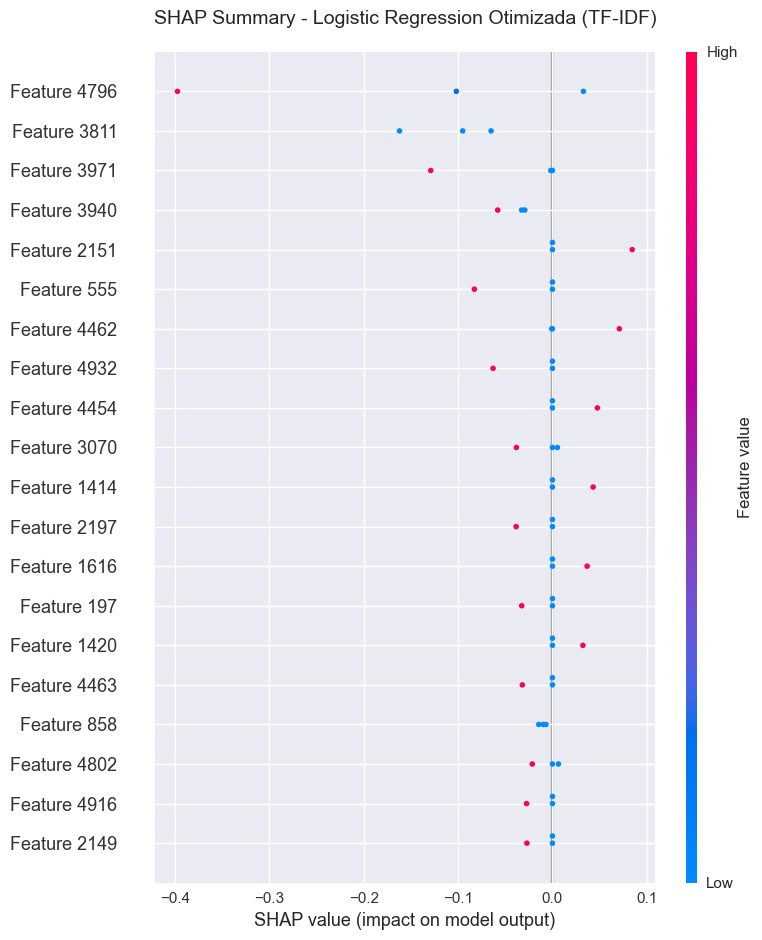

✅ SHAP concluído para Logistic Regression Otimizada (TF-IDF)

--- Random Forest (Word2Vec) ---
   🔧 Usando KernelExplainer para Random Forest (Word2Vec)...


100%|██████████| 3/3 [00:12<00:00,  4.31s/it]


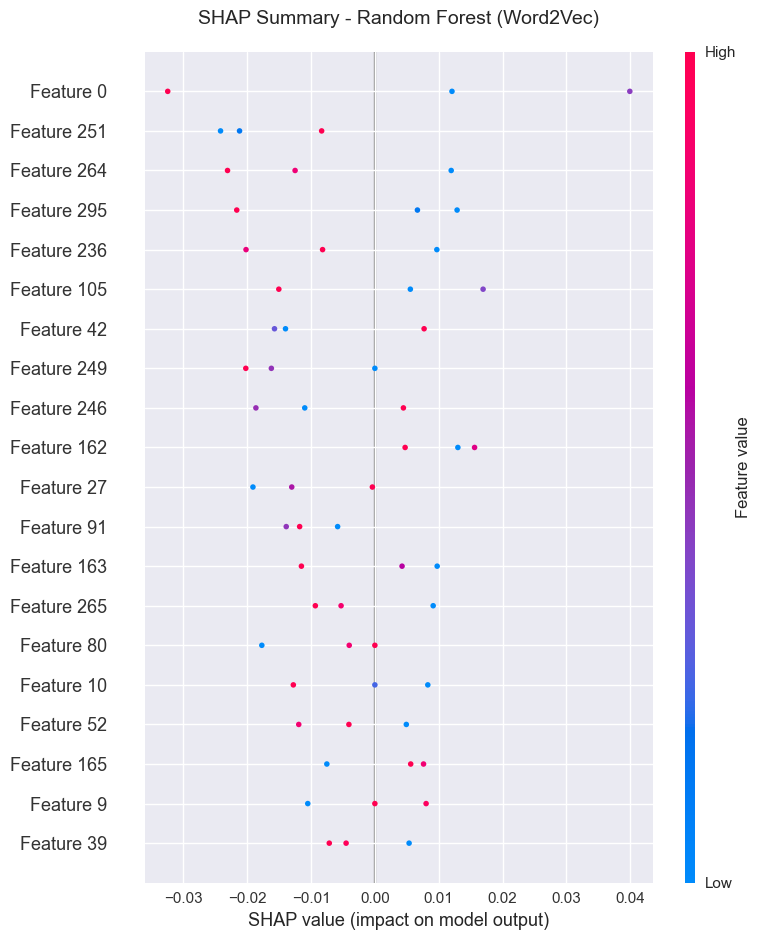

✅ SHAP concluído para Random Forest (Word2Vec)

--- XGBoost (GloVe) ---
   🔧 Usando KernelExplainer para XGBoost (GloVe)...


100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


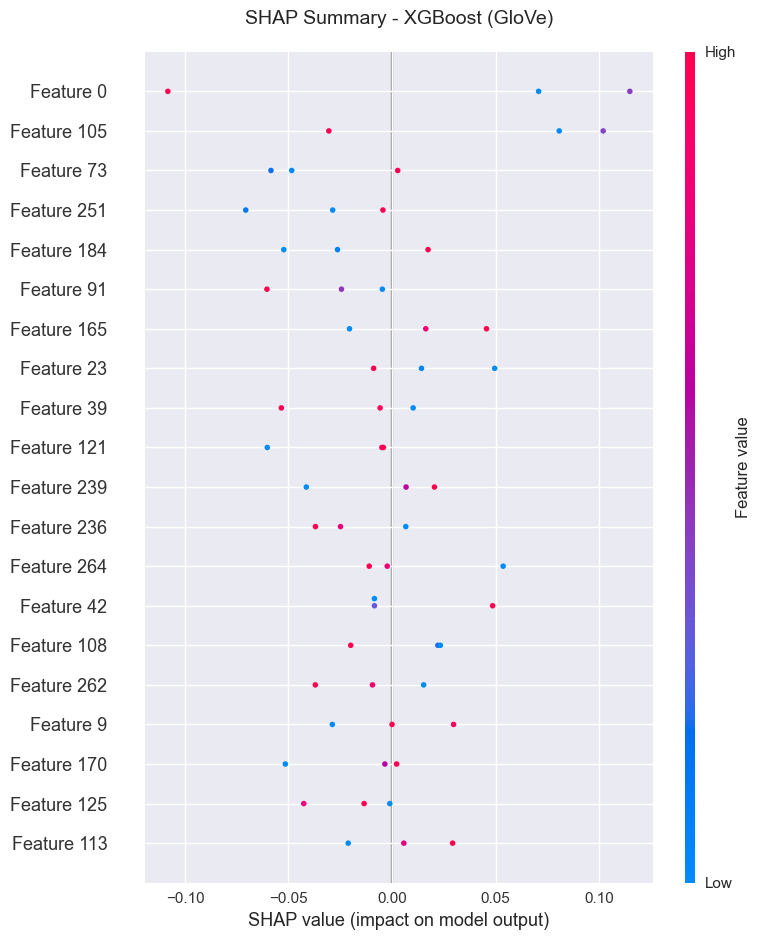

✅ SHAP concluído para XGBoost (GloVe)

--- Naive Bayes (BoW) ---
   🔧 Usando KernelExplainer para Naive Bayes (BoW)...


100%|██████████| 3/3 [02:13<00:00, 44.60s/it]


<Figure size 1200x800 with 0 Axes>

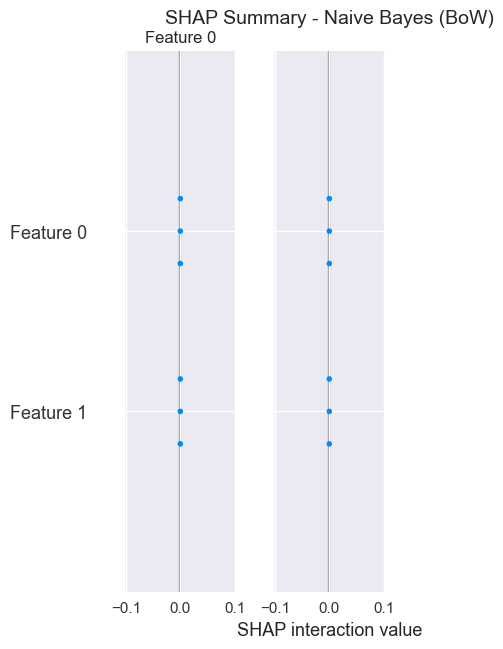

✅ SHAP concluído para Naive Bayes (BoW)

✅ Análise de explicabilidade concluída!


In [35]:
# ================================================
# EXPLICABILIDADE DOS 5 MODELOS - VERSÃO CORRIGIDA PARA BERT SHAP
# ================================================

import shap
import lime
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Inicializar SHAP para Jupyter
try:
    shap.initjs()
except:
    pass

print("="*60)
print("ANÁLISE DE EXPLICABILIDADE DOS MODELOS")
print("="*60)

# ================================================
# 1. FUNÇÃO PARA VERIFICAR VARIÁVEIS GLOBAIS
# ================================================

def safe_get_global(var_name, default=None):
    """Função segura para obter variáveis globais"""
    return globals().get(var_name, default)

# ================================================
# 2. PREPARAR DADOS PARA EXPLICAÇÃO
# ================================================

def prepare_safe_explainability_data():
    print("\n🔍 Preparando dados...")
    try:
        # Verificar diferentes fontes de dados de teste
        y_test_var = safe_get_global('y_test')
        
        # Para BERT, também verificar y_true_bert
        y_true_bert_var = safe_get_global('y_true_bert')
        
        if y_test_var is None and y_true_bert_var is None:
            print("❌ Nenhuma variável de teste encontrada")
            return None, None, None
        
        # Usar y_test se disponível, senão y_true_bert
        test_labels = y_test_var if y_test_var is not None else y_true_bert_var
        available_samples = len(test_labels)
        
        if available_samples == 0:
            return None, None, None
            
        n_samples_explain = min(5, available_samples)
        sample_indices = np.random.choice(available_samples, n_samples_explain, replace=False)
        sample_texts, sample_labels = [], []

        # Tentar obter textos originais
        df = safe_get_global('df')
        X_test_original = safe_get_global('X_test_original')
        X_var = safe_get_global('X')  # Para BERT
        
        for i in sample_indices:
            # Obter texto
            text_found = False
            
            # Primeira tentativa: DataFrame original
            if df is not None:
                text_columns = ['text', 'review', 'content', 'message']
                for col in text_columns:
                    if col in df.columns:
                        if i < len(df):
                            sample_texts.append(str(df.iloc[i][col]))
                            text_found = True
                            break
            
            # Segunda tentativa: X_test_original
            if not text_found and X_test_original is not None:
                if i < len(X_test_original):
                    sample_texts.append(str(X_test_original[i]))
                    text_found = True
            
            # Terceira tentativa: X (usado pelo BERT)
            if not text_found and X_var is not None:
                if i < len(X_var):
                    sample_texts.append(str(X_var[i]))
                    text_found = True
            
            # Fallback
            if not text_found:
                sample_texts.append(f"Texto de exemplo {i}")
            
            # Obter label
            if hasattr(test_labels, 'iloc'):
                sample_labels.append(test_labels.iloc[i])
            elif isinstance(test_labels, np.ndarray):
                sample_labels.append(test_labels[i])
            else:
                sample_labels.append(0)

        print(f"✅ Preparados {len(sample_texts)} exemplos")
        return sample_indices, sample_texts, sample_labels

    except Exception as e:
        print(f"❌ Erro na preparação: {e}")
        # Dados de fallback
        return [0, 1, 2], ["Texto exemplo 1", "Texto exemplo 2", "Texto exemplo 3"], [0, 1, 0]

# ================================================
# 3. VERIFICAR MODELOS DISPONÍVEIS - CORRIGIDO PARA BERT
# ================================================

def check_models_comprehensive():
    available_models = {}
    
    # ================================================
    # VERIFICAÇÃO ESPECÍFICA PARA BERT - CORRIGIDA
    # ================================================
    
    # Verificar se temos modelo BERT salvo
    best_bert_model = safe_get_global('best_bert_model')
    bert_tokenizer = safe_get_global('bert_tokenizer')
    y_true_bert = safe_get_global('y_true_bert')
    y_pred_bert = safe_get_global('y_pred_bert')
    y_proba_bert = safe_get_global('y_proba_bert')
    
    if best_bert_model is not None and bert_tokenizer is not None:
        print("✅ BERT: Modelo e tokenizer encontrados (best_bert_model, bert_tokenizer)")
        
        bert_info = {
            'model': best_bert_model,
            'tokenizer': bert_tokenizer,
            'name': 'BERT (Fine Tuning)',
            'type': 'bert_transformer',  # ✅ MUDANÇA: tipo para SHAP
            'y_true': y_true_bert,
            'y_pred': y_pred_bert,
            'y_proba': y_proba_bert,
            'has_model': True  # ✅ MUDANÇA: indica que temos modelo ativo
        }
        
        # Verificar textos originais
        X_var = safe_get_global('X')
        if X_var is not None:
            bert_info['X_original'] = X_var
            print("✅ BERT: Textos originais encontrados (X)")
        
        available_models['bert'] = bert_info
        print("✅ BERT adicionado para explicabilidade SHAP")
        
    elif y_true_bert is not None and y_pred_bert is not None:
        print("⚠️ BERT: Apenas resultados encontrados (sem modelo ativo)")
        
        bert_info = {
            'name': 'BERT (Fine Tuning) - Apenas Resultados',
            'type': 'bert_results',  # Tipo para análise básica
            'y_true': y_true_bert,
            'y_pred': y_pred_bert,
            'y_proba': y_proba_bert,
            'has_model': False
        }
        
        X_var = safe_get_global('X')
        if X_var is not None:
            bert_info['X_original'] = X_var
        
        available_models['bert_results_only'] = bert_info
        print("⚠️ BERT adicionado apenas para análise de resultados")
        
    else:
        print("❌ BERT: Nenhum resultado encontrado")
    
    # ================================================
    # VERIFICAÇÃO ESPECÍFICA PARA LOGISTIC REGRESSION OTIMIZADA
    # ================================================
    
    final_lr_model = safe_get_global('final_lr_model')
    y_pred_lr_optimized = safe_get_global('y_pred_lr_optimized')
    y_proba_lr_optimized = safe_get_global('y_proba_lr_optimized')
    study_lr = safe_get_global('study_lr')
    
    if final_lr_model is not None:
        print("✅ Logistic Regression Otimizada: Modelo encontrado")
        
        X_test_tfidf = safe_get_global('X_test_tfidf')
        vectorizer_tfidf = safe_get_global('vectorizer_tfidf')
        
        if X_test_tfidf is not None:
            lr_info = {
                'model': final_lr_model,
                'X_test': X_test_tfidf,
                'name': 'Logistic Regression Otimizada (TF-IDF)',
                'type': 'linear_optimized',
                'y_pred': y_pred_lr_optimized,
                'y_proba': y_proba_lr_optimized,
                'study': study_lr
            }
            
            if vectorizer_tfidf is not None:
                lr_info['vectorizer'] = vectorizer_tfidf
                print("✅ Logistic Regression: Vectorizer TF-IDF encontrado")
            
            available_models['lr_optimized'] = lr_info
            print("✅ Logistic Regression Otimizada adicionada para análise")
        else:
            print("❌ Logistic Regression: X_test_tfidf não encontrado")
    else:
        print("❌ Logistic Regression Otimizada: Modelo não encontrado")
    
    # ================================================
    # OUTROS MODELOS (CONFIGURAÇÃO ORIGINAL)
    # ================================================
    
    model_configs = [
        {
            'key': 'rf',
            'model_vars': ['best_rf_model', 'rf_model', 'random_forest_model'],
            'data_vars': ['X_test_w2v', 'X_test_word2vec'],
            'vectorizer_vars': None,
            'name': 'Random Forest (Word2Vec)',
            'type': 'tree'
        },
        {
            'key': 'xgb',
            'model_vars': ['best_xgb_model', 'xgb_model', 'xgboost_model'],
            'data_vars': ['X_test_glove', 'X_test_embedding'],
            'vectorizer_vars': None,
            'name': 'XGBoost (GloVe)',
            'type': 'tree'
        },
        {
            'key': 'nb',
            'model_vars': ['best_nb_model', 'nb_model', 'naive_bayes_model'],
            'data_vars': ['X_test_bow', 'X_test_count'],
            'vectorizer_vars': ['vectorizer_bow', 'count_vectorizer'],
            'name': 'Naive Bayes (BoW)',
            'type': 'naive_bayes'
        }
    ]
    
    # Verificar outros modelos
    for config in model_configs:
        model = None
        for model_var in config['model_vars']:
            model = safe_get_global(model_var)
            if model is not None:
                break
        
        if model is None:
            print(f"❌ {config['name']}: Modelo não encontrado")
            continue
        
        model_info = {
            'model': model,
            'name': config['name'],
            'type': config['type']
        }
        
        X_test_data = None
        for data_var in config['data_vars']:
            X_test_data = safe_get_global(data_var)
            if X_test_data is not None:
                break
        
        if X_test_data is None:
            print(f"❌ {config['name']}: Dados de teste não encontrados")
            continue
        
        model_info['X_test'] = X_test_data
        
        if config['vectorizer_vars']:
            vectorizer = None
            for vec_var in config['vectorizer_vars']:
                vectorizer = safe_get_global(vec_var)
                if vectorizer is not None:
                    break
            if vectorizer is not None:
                model_info['vectorizer'] = vectorizer
        
        available_models[config['key']] = model_info
        print(f"✅ {config['name']}: Encontrado")
    
    return available_models

# ================================================
# 4. EXPLICABILIDADE ESPECÍFICA PARA BERT COM SHAP
# ================================================

def explain_bert_with_shap():
    """Explicabilidade BERT usando SHAP com modelo ativo"""
    print("\n--- BERT (Fine Tuning) - Explicabilidade SHAP ---")
    
    bert_info = available_models['bert']
    model = bert_info['model']
    tokenizer = bert_info['tokenizer']
    
    try:
        # 1. Métricas básicas primeiro
        if 'y_true' in bert_info and 'y_pred' in bert_info:
            y_true = bert_info['y_true']
            y_pred = bert_info['y_pred']
            
            from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
            
            accuracy = accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred, average='binary')
            precision = precision_score(y_true, y_pred, average='binary')
            recall = recall_score(y_true, y_pred, average='binary')
            
            print(f"\n📊 Métricas de Performance BERT:")
            print(f"   • Acurácia: {accuracy:.4f}")
            print(f"   • F1-Score: {f1:.4f}")
            print(f"   • Precisão: {precision:.4f}")
            print(f"   • Recall: {recall:.4f}")
        
        # 2. Explicabilidade SHAP para BERT
        print(f"\n🔍 Iniciando explicabilidade SHAP para BERT...")
        
        # Criar pipeline de predição
        from transformers import pipeline
        
        try:
            # Criar pipeline para classificação
            pipe = pipeline(
                "text-classification", 
                model=model, 
                tokenizer=tokenizer, 
                return_all_scores=True,
                device=-1  # Forçar CPU para evitar problemas
            )
            
            print("✅ Pipeline BERT criado com sucesso")
            
            # Selecionar textos para explicar
            texts_to_explain = sample_texts[:3]  # Máximo 3 para não demorar muito
            
            print(f"📝 Explicando {len(texts_to_explain)} textos...")
            
            # Criar explainer SHAP
            explainer = shap.Explainer(pipe)
            
            # Calcular valores SHAP
            shap_values = explainer(texts_to_explain)
            
            print("✅ Valores SHAP calculados com sucesso")
            
            # Visualizar explicações
            for i, sv in enumerate(shap_values):
                print(f"\n🔍 Explicação SHAP - Texto {i+1}:")
                print(f"Texto: {texts_to_explain[i][:100]}...")
                
                try:
                    # Plotar explicação textual
                    shap.plots.text(sv, display=True)
                    
                except Exception as plot_error:
                    print(f"⚠️ Erro na visualização: {plot_error}")
                    
                    # Fallback: mostrar valores numericamente
                    if hasattr(sv, 'values') and hasattr(sv, 'data'):
                        print("📊 Valores SHAP (top 10 tokens):")
                        
                        # Pegar valores absolutos e ordenar
                        abs_values = np.abs(sv.values)
                        top_indices = np.argsort(abs_values)[-10:][::-1]
                        
                        for idx in top_indices:
                            token = sv.data[idx] if idx < len(sv.data) else f"token_{idx}"
                            value = sv.values[idx] if idx < len(sv.values) else 0
                            print(f"   '{token}': {value:+.4f}")
            
            print(f"✅ Explicabilidade SHAP BERT concluída")
            
        except Exception as shap_error:
            print(f"❌ Erro no SHAP BERT: {shap_error}")
            
            # Fallback: Análise básica com LIME
            print("🔄 Tentando explicação alternativa com LIME...")
            try:
                explain_bert_with_lime(model, tokenizer, sample_texts[:2])
            except Exception as lime_error:
                print(f"❌ LIME também falhou: {lime_error}")
                
                # Último fallback: análise básica
                print("📊 Executando análise básica de resultados...")
                explain_bert_basic_analysis(bert_info)
        
    except Exception as e:
        print(f"❌ Erro geral na explicabilidade BERT: {e}")
        import traceback
        traceback.print_exc()

# ================================================
# 5. FALLBACKS PARA BERT
# ================================================

def explain_bert_with_lime(model, tokenizer, texts):
    """Explicação BERT usando LIME como fallback"""
    try:
        print("🔍 Usando LIME para explicabilidade BERT...")
        
        def bert_predict_proba(texts):
            from transformers import pipeline
            pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)
            results = pipe(texts)
            probs = []
            for result in results:
                if isinstance(result, list) and len(result) >= 2:
                    prob_0 = result[0]['score'] if result[0]['label'] == 'LABEL_0' else result[1]['score']
                    prob_1 = result[1]['score'] if result[1]['label'] == 'LABEL_1' else result[0]['score']
                    probs.append([prob_0, prob_1])
                else:
                    probs.append([0.5, 0.5])
            return np.array(probs)
        
        explainer = LimeTextExplainer(class_names=['Fake News', 'Real News'])
        
        for i, text in enumerate(texts):
            print(f"\n🔍 LIME - Texto {i+1}")
            exp = explainer.explain_instance(text, bert_predict_proba, num_features=10)
            
            # Mostrar explicação textualmente
            print("📊 Top features LIME:")
            for feature, weight in exp.as_list():
                print(f"   '{feature}': {weight:+.4f}")
            
            # Tentar mostrar no notebook se possível
            try:
                exp.show_in_notebook(text=True)
            except:
                pass
                
        print("✅ LIME concluído")
        
    except Exception as e:
        print(f"❌ Erro no LIME: {e}")

def explain_bert_basic_analysis(bert_info):
    """Análise básica de resultados BERT"""
    try:
        print("📊 Análise básica de resultados BERT...")
        
        if 'y_true' in bert_info and 'y_pred' in bert_info:
            y_true = bert_info['y_true']
            y_pred = bert_info['y_pred']
            y_proba = bert_info.get('y_proba')
            
            # Matriz de confusão
            from sklearn.metrics import confusion_matrix
            import seaborn as sns
            
            cm = confusion_matrix(y_true, y_pred)
            
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=['Fake News', 'Real News'],
                        yticklabels=['Fake News', 'Real News'])
            plt.title('Matriz de Confusão - BERT')
            plt.xlabel('Predito')
            plt.ylabel('Real')
            plt.tight_layout()
            plt.show()
            
            # Análise de probabilidades se disponível
            if y_proba is not None:
                plt.figure(figsize=(12, 4))
                
                plt.subplot(1, 2, 1)
                plt.hist(y_proba, bins=30, alpha=0.7, color='purple', edgecolor='black')
                plt.title('Distribuição de Probabilidades - BERT')
                plt.xlabel('Probabilidade da Classe Positiva')
                plt.ylabel('Frequência')
                plt.grid(True, alpha=0.3)
                
                plt.subplot(1, 2, 2)
                for class_val in [0, 1]:
                    class_probs = y_proba[y_true == class_val]
                    plt.hist(class_probs, bins=20, alpha=0.7, 
                            label=f'Classe Real {class_val}', density=True)
                plt.title('Probabilidades por Classe Real - BERT')
                plt.xlabel('Probabilidade da Classe Positiva')
                plt.ylabel('Densidade')
                plt.legend()
                plt.grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
        
        print("✅ Análise básica BERT concluída")
        
    except Exception as e:
        print(f"❌ Erro na análise básica: {e}")

# ================================================
# 6. ANÁLISE ESPECÍFICA PARA LOGISTIC REGRESSION OTIMIZADA
# ================================================

def explain_optimized_lr():
    """Análise específica para Logistic Regression otimizada"""
    print("\n--- Logistic Regression Otimizada (TF-IDF) ---")
    
    lr_info = available_models['lr_optimized']
    model = lr_info['model']
    study = lr_info.get('study')
    y_pred = lr_info.get('y_pred')
    y_proba = lr_info.get('y_proba')
    
    try:
        # 1. Informações da Otimização
        if study is not None:
            print(f"\n🎯 Resultados da Otimização Optuna:")
            print(f"   • Melhor F1-Score (CV): {study.best_value:.4f}")
            print(f"   • Número de trials: {len(study.trials)}")
            print(f"   • Melhores parâmetros:")
            for param, value in study.best_params.items():
                if param == 'C':
                    print(f"     - {param}: {value:.4f}")
                else:
                    print(f"     - {param}: {value}")
        
        # 2. Performance no conjunto de teste
        if y_pred is not None:
            y_test = safe_get_global('y_test')
            if y_test is not None:
                from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
                
                accuracy = accuracy_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred, average='binary')
                precision = precision_score(y_test, y_pred, average='binary')
                recall = recall_score(y_test, y_pred, average='binary')
                
                print(f"\n📊 Performance no Conjunto de Teste:")
                print(f"   • Acurácia: {accuracy:.4f}")
                print(f"   • F1-Score: {f1:.4f}")
                print(f"   • Precisão: {precision:.4f}")
                print(f"   • Recall: {recall:.4f}")
        
        # 3. Análise dos Coeficientes
        if hasattr(model, 'coef_') and 'vectorizer' in lr_info:
            vectorizer = lr_info['vectorizer']
            coef = model.coef_[0]
            
            try:
                feature_names = vectorizer.get_feature_names_out()
            except:
                try:
                    feature_names = vectorizer.get_feature_names()
                except:
                    feature_names = None
            
            if feature_names is not None:
                print(f"\n🔍 Análise dos Coeficientes (Top Features):")
                
                # Top features positivas (indicam Real News)
                top_positive_idx = np.argsort(coef)[-10:][::-1]
                print(f"\n📈 Top 10 Features Positivas (indicam Real News):")
                for i, idx in enumerate(top_positive_idx):
                    feature_name = feature_names[idx]
                    print(f"   {i+1:2d}. '{feature_name}': {coef[idx]:+.4f}")
                
                # Top features negativas (indicam Fake News)
                top_negative_idx = np.argsort(coef)[:10]
                print(f"\n📉 Top 10 Features Negativas (indicam Fake News):")
                for i, idx in enumerate(top_negative_idx):
                    feature_name = feature_names[idx]
                    print(f"   {i+1:2d}. '{feature_name}': {coef[idx]:+.4f}")
                
                # Visualização dos coeficientes
                plt.figure(figsize=(15, 10))
                
                # Subplot 1: Top features positivas
                plt.subplot(2, 2, 1)
                pos_coefs = coef[top_positive_idx]
                pos_names = [feature_names[i] for i in top_positive_idx]
                plt.barh(range(len(pos_coefs)), pos_coefs, color='green', alpha=0.7)
                plt.yticks(range(len(pos_coefs)), pos_names)
                plt.xlabel('Coeficiente')
                plt.title('Top 10 Features Positivas (Real News)')
                plt.grid(True, alpha=0.3)
                
                # Subplot 2: Top features negativas
                plt.subplot(2, 2, 2)
                neg_coefs = coef[top_negative_idx]
                neg_names = [feature_names[i] for i in top_negative_idx]
                plt.barh(range(len(neg_coefs)), neg_coefs, color='red', alpha=0.7)
                plt.yticks(range(len(neg_coefs)), neg_names)
                plt.xlabel('Coeficiente')
                plt.title('Top 10 Features Negativas (Fake News)')
                plt.grid(True, alpha=0.3)
                
                # Subplot 3: Distribuição dos coeficientes
                plt.subplot(2, 2, 3)
                plt.hist(coef, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
                plt.axvline(0, color='red', linestyle='--', linewidth=2)
                plt.xlabel('Valor do Coeficiente')
                plt.ylabel('Frequência')
                plt.title('Distribuição dos Coeficientes')
                plt.grid(True, alpha=0.3)
                
                # Subplot 4: Magnitude dos coeficientes
                plt.subplot(2, 2, 4)
                abs_coef = np.abs(coef)
                plt.hist(abs_coef, bins=50, alpha=0.7, color='orange', edgecolor='black')
                plt.xlabel('Magnitude do Coeficiente')
                plt.ylabel('Frequência')
                plt.title('Distribuição da Magnitude dos Coeficientes')
                plt.grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
        
        print(f"✅ Análise Logistic Regression Otimizada concluída")
        
    except Exception as e:
        print(f"❌ Erro na análise LR Otimizada: {e}")
        import traceback
        traceback.print_exc()

# ================================================
# 7. FUNÇÃO AUXILIAR PARA CRIAR FUNÇÃO DE PREDIÇÃO
# ================================================

def create_prediction_function(model, model_type):
    """Cria função de predição compatível com SHAP"""
    if model_type in ['linear', 'linear_optimized']:
        if hasattr(model, 'predict_proba'):
            def predict_fn(X):
                if hasattr(X, 'toarray'):
                    X = X.toarray()
                proba = model.predict_proba(X)
                return proba[:, 1] if proba.shape[1] == 2 else proba
            return predict_fn
        else:
            def predict_fn(X):
                if hasattr(X, 'toarray'):
                    X = X.toarray()
                return model.predict(X)
            return predict_fn
    
    elif model_type == 'naive_bayes':
        def predict_fn(X):
            if hasattr(X, 'toarray'):
                X = X.toarray()
            return model.predict_proba(X)
        return predict_fn
    
    else:  # tree models
        def predict_fn(X):
            if hasattr(X, 'toarray'):
                X = X.toarray()
            return model.predict_proba(X)[:, 1] if hasattr(model, 'predict_proba') else model.predict(X)
        return predict_fn

# ================================================
# 8. EXPLICABILIDADE COM SHAP - INCLUINDO BERT CORRIGIDO
# ================================================

def explain_with_shap_comprehensive():
    print("\n📌 Executando SHAP e Análises Avançadas...")
    
    for key, model_info in available_models.items():
        model_type = model_info['type']
        model_name = model_info['name']

        print(f"\n--- {model_name} ---")
        
        # ✅ TRATAMENTO ESPECÍFICO PARA BERT COM MODELO ATIVO
        if model_type == 'bert_transformer':
            explain_bert_with_shap()
            continue
        
        # Tratamento para BERT apenas com resultados
        if model_type == 'bert_results':
            explain_bert_basic_analysis(model_info)
            continue
        
        # Tratamento especial para LR Otimizada
        if model_type == 'linear_optimized':
            explain_optimized_lr()
            # Continuar com SHAP também
        
        try:
            model = model_info['model']
            X_data = model_info['X_test']
            
            # Converter para array denso se necessário
            if hasattr(X_data, 'toarray'):
                X_data = X_data.toarray()
            
            # Selecionar amostras válidas
            safe_idx = [i for i in sample_indices if i < len(X_data)]
            if not safe_idx:
                print(f"❌ Nenhuma amostra válida para {model_name}")
                continue
            
            X_explain = X_data[safe_idx]
            
            print(f"   🔧 Usando KernelExplainer para {model_name}...")
            
            # Criar função de predição
            predict_fn = create_prediction_function(model, model_type)
            
            # Criar background dataset menor
            n_background = min(50, X_data.shape[0])
            background_idx = np.random.choice(X_data.shape[0], n_background, replace=False)
            background = X_data[background_idx]
            
            # Usar KernelExplainer
            explainer = shap.KernelExplainer(predict_fn, background)
            
            # Calcular valores SHAP (limitando amostras)
            n_explain = min(3, len(X_explain))
            shap_values = explainer.shap_values(X_explain[:n_explain])
            
            # Se retornou lista, pegar classe positiva
            if isinstance(shap_values, list):
                if len(shap_values) == 2:
                    shap_values = shap_values[1]
                else:
                    shap_values = shap_values[0]
            
            # Obter nomes das features
            feature_names = None
            if 'vectorizer' in model_info:
                try:
                    feature_names = model_info['vectorizer'].get_feature_names_out()
                except:
                    try:
                        feature_names = model_info['vectorizer'].get_feature_names()
                    except:
                        feature_names = None
            
            # Limitar features para visualização
            if feature_names is not None and len(feature_names) > 20:
                mean_importance = np.abs(shap_values).mean(axis=0)
                top_indices = np.argsort(mean_importance)[-20:]
                shap_values = shap_values[:, top_indices]
                feature_names = feature_names[top_indices]
                X_explain_plot = X_explain[:n_explain, top_indices]
            else:
                X_explain_plot = X_explain[:n_explain]
            
            # Plotar
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_values, X_explain_plot, feature_names=feature_names, show=False)
            plt.title(f"SHAP Summary - {model_name}", fontsize=14, pad=20)
            plt.tight_layout()
            plt.show()
            
            print(f"✅ SHAP concluído para {model_name}")

        except Exception as e:
            print(f"❌ Erro explicando {model_name}: {e}")
            # Fallback para análise de importância nativa
            try:
                if hasattr(model, 'feature_importances_'):
                    importances = model.feature_importances_
                    feature_names = None
                    if 'vectorizer' in model_info:
                        try:
                            feature_names = model_info['vectorizer'].get_feature_names_out()
                        except:
                            feature_names = None
                    
                    if feature_names is not None:
                        top_indices = np.argsort(importances)[-20:]
                        top_importances = importances[top_indices]
                        top_names = feature_names[top_indices]
                        
                        plt.figure(figsize=(10, 8))
                        plt.barh(range(len(top_importances)), top_importances)
                        plt.yticks(range(len(top_importances)), top_names)
                        plt.xlabel('Importância')
                        plt.title(f'Top 20 Features - {model_name}')
                        plt.tight_layout()
                        plt.show()
                        
                        print(f"✅ Análise alternativa concluída para {model_name}")
                
            except Exception as fallback_error:
                print(f"❌ Análise alternativa também falhou: {fallback_error}")

# ================================================
# 9. EXECUTAR ANÁLISE COMPLETA
# ================================================

def run_complete_analysis():
    print("\n🚀 Iniciando análise completa...")
    
    global sample_indices, sample_texts, sample_labels, available_models
    
    # Preparar dados
    sample_indices, sample_texts, sample_labels = prepare_safe_explainability_data()
    if sample_indices is None:
        print("❌ Falha na preparação dos dados")
        return
    
    # Verificar modelos
    available_models = check_models_comprehensive()
    if not available_models:
        print("❌ Nenhum modelo encontrado")
        return
    
    print(f"\n📊 Modelos encontrados: {len(available_models)}")
    for key, info in available_models.items():
        print(f"   • {info['name']}")
    
    # Executar explicações
    explain_with_shap_comprehensive()
    
    print("\n✅ Análise de explicabilidade concluída!")

# ================================================
# 10. EXECUTAR
# ================================================

# Executar análise
run_complete_analysis()

# 19. Explicabilidade LIME

ANÁLISE DE EXPLICABILIDADE COM LIME
🍋 INICIANDO ANÁLISE COMPLETA COM LIME

🍋 Iniciando explicabilidade LIME para todos os modelos...
📊 Modelos encontrados para LIME: 5

🔍 Processando: BERT (Fine Tuning)

--- LIME para BERT ---

🔍 Preparando dados para LIME...
✅ Preparados 7 textos para LIME
🔍 Explicando 5 textos com LIME...

📝 LIME - Texto 1:
   Texto: u reaffirm one china policy beijing trump white house washington reuters united state touch chinese ...
   📊 Top features LIME:
      'reuters': +0.5950 → Real News
      'touch': -0.1470 → Fake News
      'beijing': +0.1371 → Real News
      'house': +0.1101 → Real News
      'telephone': +0.0781 → Real News
      'official': -0.0775 → Fake News
      'last': -0.0597 → Fake News
      'united': +0.0530 → Real News
      'separate': -0.0093 → Fake News
      'country': +0.0066 → Real News


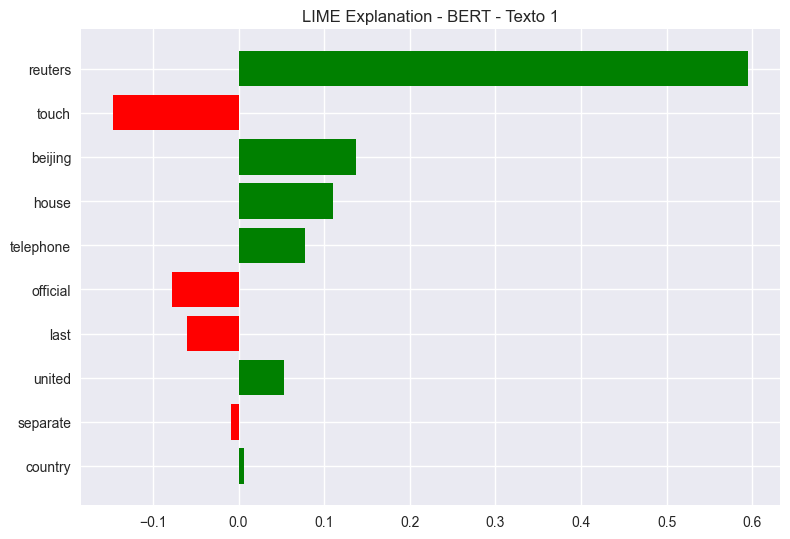

   🎯 Predição: Real News (confiança: 0.998)

📝 LIME - Texto 2:
   Texto: international air ban iraqi kurdistan come effect erbil iraq reuters ban international flight iraqi ...
   📊 Top features LIME:
      'reuters': +0.4922 → Real News
      'trickle': -0.1768 → Fake News
      'friday': +0.1653 → Real News
      'avoid': -0.0668 → Fake News
      'effect': +0.0537 → Real News
      'gmt': +0.0427 → Real News
      'state': +0.0366 → Real News
      'come': -0.0311 → Fake News
      'dress': +0.0276 → Real News
      'dozens': +0.0203 → Real News


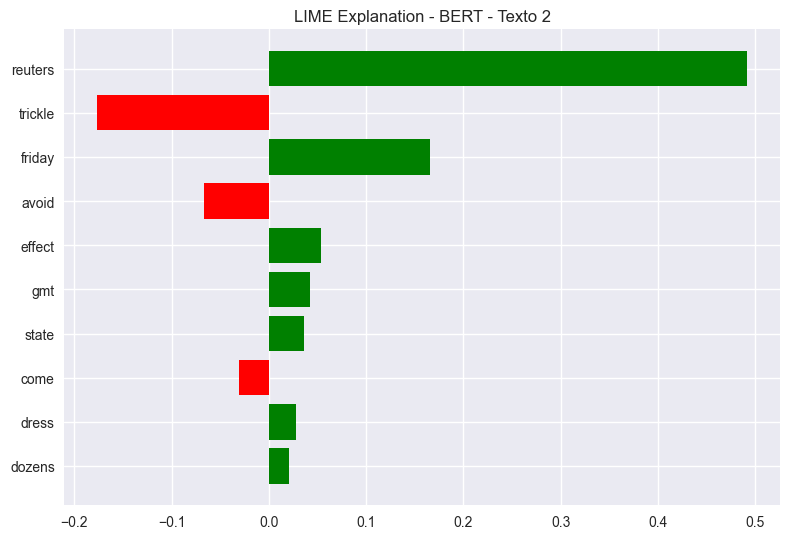

   🎯 Predição: Real News (confiança: 0.998)

📝 LIME - Texto 3:
   Texto: trump tillerson tense relationship chat u facebook messenger find happening world unfolds...
   📊 Top features LIME:
      'messenger': +0.2490 → Real News
      'facebook': +0.2343 → Real News
      'tillerson': +0.1279 → Real News
      'find': +0.1105 → Real News
      'happening': -0.0874 → Fake News
      'chat': +0.0683 → Real News
      'unfolds': -0.0659 → Fake News
      'trump': -0.0523 → Fake News
      'relationship': +0.0430 → Real News
      'world': -0.0216 → Fake News


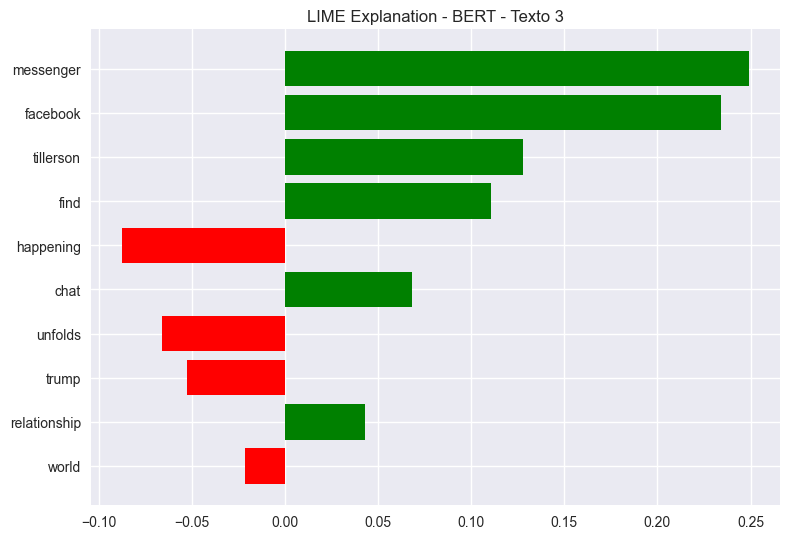

   🎯 Predição: Real News (confiança: 0.813)
✅ LIME BERT concluído

🔍 Processando: Logistic Regression Otimizada (TF-IDF)

--- LIME para Logistic Regression Otimizada (TF-IDF) ---
🔍 Explicando 5 instâncias...

📊 LIME - Instância 1 (índice 4660):
   📈 Top features LIME:
      'feature_1092 <= 0.00': +0.2301 → Real News
      'feature_4060 <= 0.00': -0.0921 → Fake News
      'feature_2899 <= 0.00': -0.0816 → Fake News
      'feature_3630 <= 0.00': +0.0677 → Real News
      'feature_140 <= 0.00': +0.0576 → Real News
      'feature_1062 <= 0.00': +0.0520 → Real News
      'feature_2325 <= 0.00': -0.0412 → Fake News
      'feature_4426 <= 0.00': +0.0249 → Real News
      'feature_3596 <= 0.00': +0.0108 → Real News
      'feature_516 <= 0.00': +0.0006 → Real News


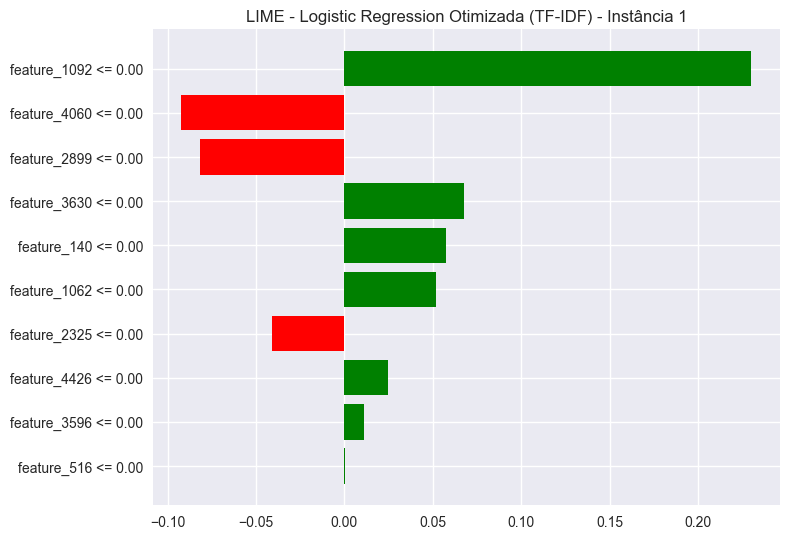

   🎯 Predição: Fake News (confiança: 0.723)

📊 LIME - Instância 2 (índice 10310):
   📈 Top features LIME:
      'feature_1432 <= 0.00': -0.1446 → Fake News
      'feature_3403 <= 0.00': -0.1207 → Fake News
      'feature_652 <= 0.00': -0.0890 → Fake News
      'feature_2364 <= 0.00': +0.0710 → Real News
      'feature_2686 <= 0.00': +0.0681 → Real News
      'feature_4428 <= 0.00': -0.0596 → Fake News
      'feature_189 <= 0.00': -0.0343 → Fake News
      'feature_1836 <= 0.00': -0.0260 → Fake News
      'feature_2252 <= 0.00': -0.0153 → Fake News
      'feature_4844 <= 0.00': +0.0030 → Real News


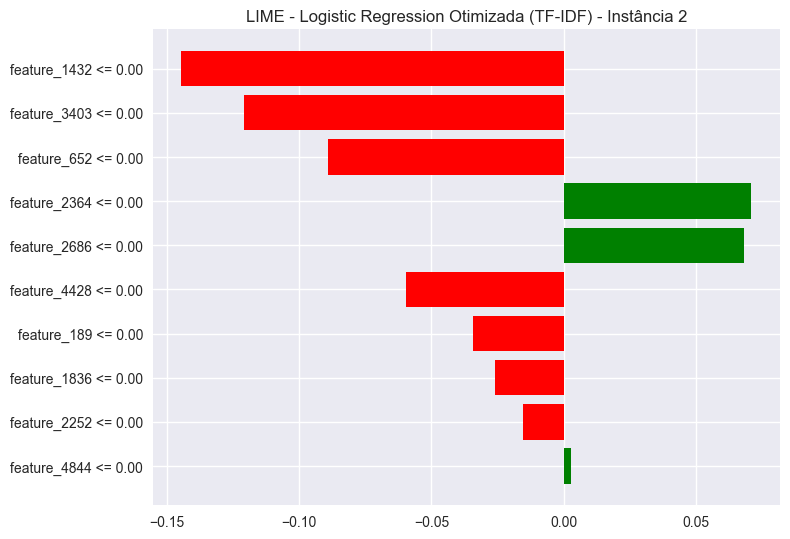

   🎯 Predição: Fake News (confiança: 1.000)

📊 LIME - Instância 3 (índice 10774):
   📈 Top features LIME:
      'feature_3432 <= 0.00': -0.1978 → Fake News
      'feature_2642 <= 0.00': +0.1675 → Real News
      'feature_939 <= 0.00': -0.1364 → Fake News
      'feature_90 <= 0.00': -0.1309 → Fake News
      'feature_189 <= 0.00': +0.1237 → Real News
      'feature_1840 <= 0.00': +0.1038 → Real News
      'feature_2035 <= 0.00': -0.0929 → Fake News
      'feature_3062 <= 0.00': +0.0577 → Real News
      'feature_4508 <= 0.00': +0.0336 → Real News
      'feature_138 <= 0.00': -0.0030 → Fake News


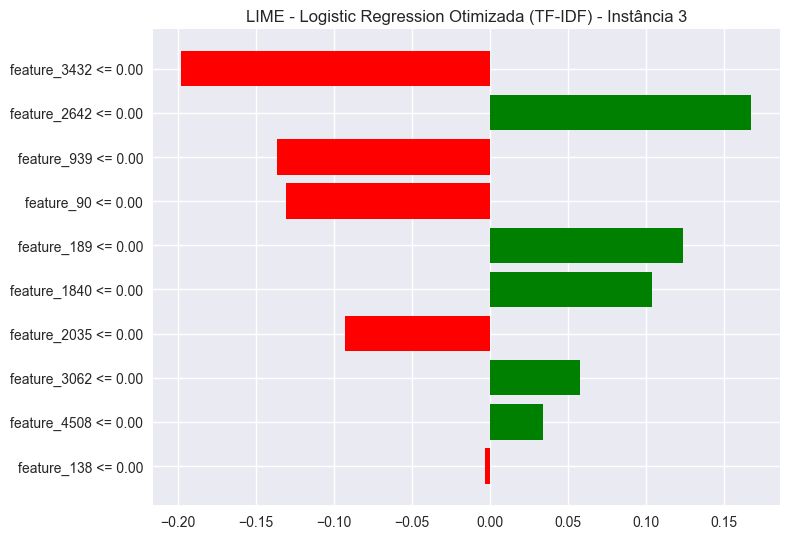

   🎯 Predição: Fake News (confiança: 1.000)
✅ LIME Logistic Regression Otimizada (TF-IDF) concluído

🔍 Processando: Random Forest (Word2Vec)

--- LIME para Random Forest (Word2Vec) ---
🔍 Explicando 5 instâncias...
⚠️ Nota: Features são dimensões abstratas de embeddings

📊 LIME - Instância 1 (índice 4660):
   �� Top dimensões mais importantes:
      dim_0 <= -0.70: +0.0266 → Real News
      dim_295 > 0.07: -0.0216 → Fake News
      dim_246 <= 0.08: -0.0202 → Fake News
      dim_162 <= -0.03: +0.0178 → Real News
      dim_105 <= -1.36: +0.0143 → Real News
      -0.00 < dim_264 <= 0.03: +0.0141 → Real News
      dim_27 <= -0.02: -0.0134 → Fake News
      -0.06 < dim_219 <= -0.02: -0.0131 → Fake News
      dim_236 > 0.10: -0.0125 → Fake News
      dim_249 > 0.08: -0.0120 → Fake News
   🎯 Predição: Fake News (confiança: 0.649)

📊 LIME - Instância 2 (índice 10310):
   �� Top dimensões mais importantes:
      dim_0 > -0.68: -0.0337 → Fake News
      dim_105 > -1.16: -0.0307 → Fake News
      

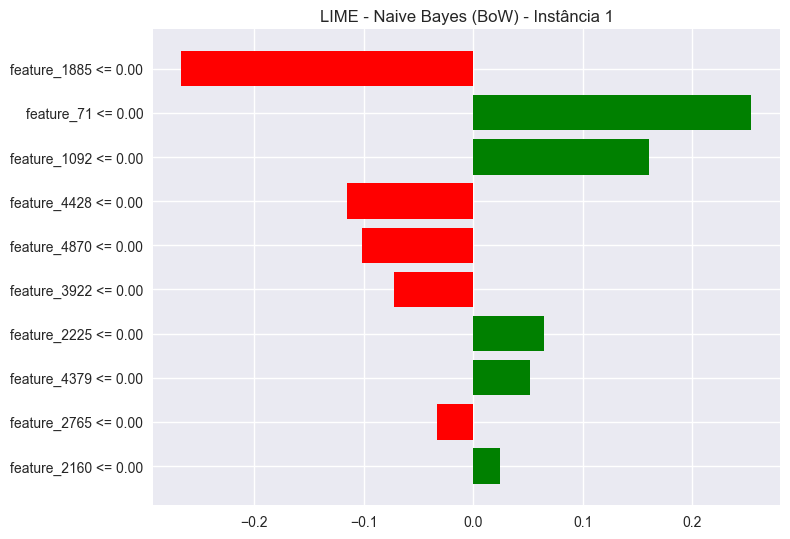

   🎯 Predição: Fake News (confiança: 1.000)

📊 LIME - Instância 2 (índice 10310):
   📈 Top features LIME:
      'feature_4999 <= 0.00': -0.3352 → Fake News
      'feature_1391 <= 0.00': -0.2354 → Fake News
      'feature_2899 <= 0.00': -0.2099 → Fake News
      'feature_3040 <= 0.00': +0.1989 → Real News
      'feature_1270 <= 0.00': +0.1824 → Real News
      'feature_189 <= 0.00': +0.1706 → Real News
      'feature_2732 <= 0.00': -0.1394 → Fake News
      'feature_1617 <= 0.00': -0.0269 → Fake News
      'feature_1033 <= 0.00': -0.0211 → Fake News
      'feature_3812 <= 0.00': -0.0045 → Fake News


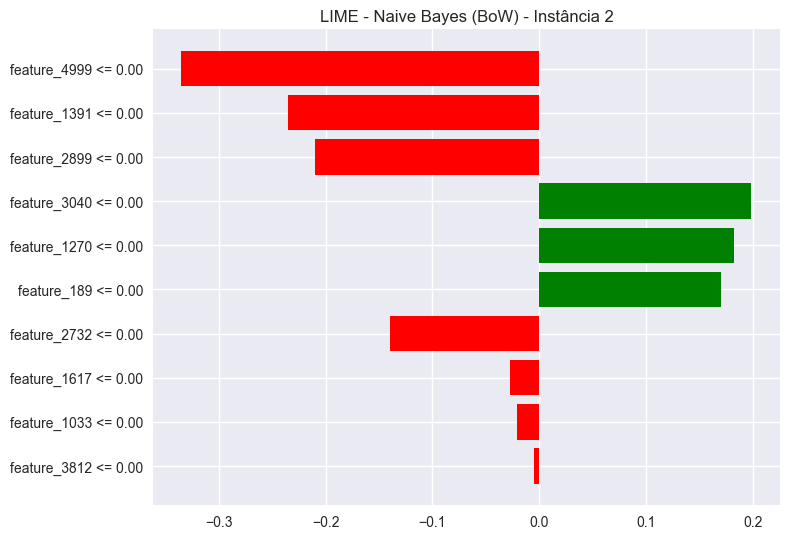

   🎯 Predição: Fake News (confiança: 1.000)

📊 LIME - Instância 3 (índice 10774):
   📈 Top features LIME:
      'feature_603 <= 0.00': +0.4228 → Real News
      'feature_3638 <= 0.00': +0.4187 → Real News
      'feature_4379 <= 0.00': +0.2990 → Real News
      'feature_1713 <= 0.00': -0.1714 → Fake News
      'feature_1401 <= 0.00': +0.0858 → Real News
      'feature_1840 <= 0.00': -0.0655 → Fake News
      'feature_1184 <= 0.00': +0.0591 → Real News
      'feature_3161 <= 0.00': +0.0576 → Real News
      'feature_789 <= 0.00': -0.0396 → Fake News
      'feature_1726 <= 0.00': +0.0024 → Real News


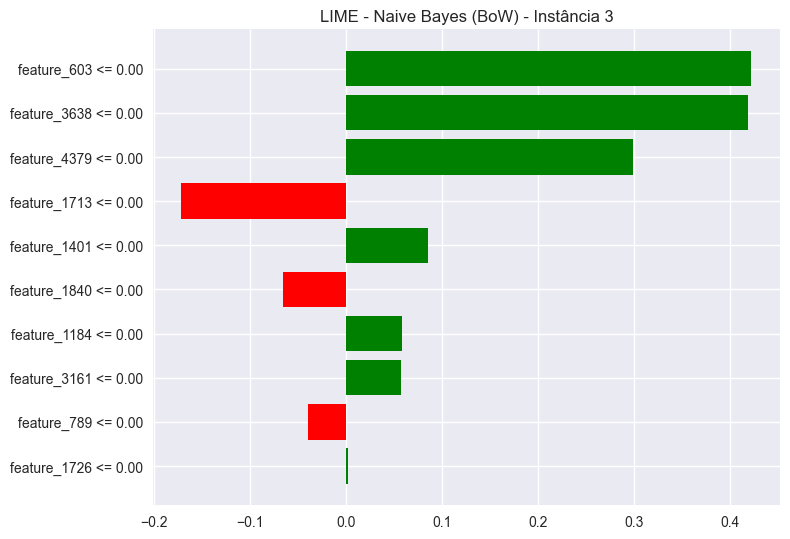

   🎯 Predição: Fake News (confiança: 0.674)
✅ LIME Naive Bayes (BoW) concluído

✅ Análise LIME concluída para todos os modelos!

📊 COMPARAÇÃO: SHAP vs LIME

    ╔══════════════════╦══════════════════╦══════════════════╗
    ║     Aspecto      ║       SHAP       ║       LIME       ║
    ╠══════════════════╬══════════════════╬══════════════════╣
    ║ Tipo de Método   ║ Global + Local   ║ Apenas Local     ║
    ║ Velocidade       ║ Mais Lento       ║ Mais Rápido     ║
    ║ Precisão         ║ Matematicamente  ║ Aproximação      ║
    ║                  ║ Exata            ║ Local            ║
    ║ Interpretação    ║ Valores Shapley  ║ Perturbação      ║
    ║ Texto            ║ Tokens/Features  ║ Palavras Reais   ║
    ║ Visualização     ║ Summary Plots    ║ Feature Plots    ║
    ║ Modelos          ║ Qualquer Modelo  ║ Qualquer Modelo  ║
    ╚══════════════════╩══════════════════╩══════════════════╝
    

🎯 QUANDO USAR CADA UM:

🔹 SHAP:
   ✅ Análise global do modelo
   ✅ Comparação entr

In [36]:
# ================================================
# EXPLICABILIDADE COM LIME - IMPLEMENTAÇÃO COMPLETA
# ================================================

import lime
from lime.lime_text import LimeTextExplainer
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("ANÁLISE DE EXPLICABILIDADE COM LIME")
print("="*60)

# ================================================
# 1. FUNÇÃO PARA VERIFICAR VARIÁVEIS GLOBAIS (REUTILIZAR)
# ================================================

def safe_get_global(var_name, default=None):
    """Função segura para obter variáveis globais"""
    return globals().get(var_name, default)

# ================================================
# 2. PREPARAR DADOS PARA LIME
# ================================================

def prepare_lime_data():
    """Prepara dados específicos para LIME"""
    print("\n🔍 Preparando dados para LIME...")
    
    # Usar os mesmos dados preparados para SHAP
    sample_indices = safe_get_global('sample_indices', [0, 1, 2])
    sample_texts = safe_get_global('sample_texts', ["Texto exemplo 1", "Texto exemplo 2", "Texto exemplo 3"])
    sample_labels = safe_get_global('sample_labels', [0, 1, 0])
    
    # Pegar textos originais adicionais se disponível
    X_var = safe_get_global('X')
    if X_var is not None and len(X_var) > 3:
        # Adicionar mais exemplos para LIME
        additional_indices = np.random.choice(len(X_var), min(5, len(X_var)), replace=False)
        additional_texts = [str(X_var[i]) for i in additional_indices]
        sample_texts.extend(additional_texts[:2])  # Adicionar apenas 2 mais
    
    print(f"✅ Preparados {len(sample_texts)} textos para LIME")
    return sample_texts[:5]  # Máximo 5 exemplos

# ================================================
# 3. LIME PARA MODELOS BASEADOS EM TEXTO (BERT)
# ================================================

def explain_bert_with_lime():
    """LIME para BERT usando textos originais"""
    print("\n--- LIME para BERT ---")
    
    best_bert_model = safe_get_global('best_bert_model')
    bert_tokenizer = safe_get_global('bert_tokenizer')
    
    if best_bert_model is None or bert_tokenizer is None:
        print("❌ Modelo BERT ou tokenizer não encontrado")
        return
    
    try:
        # Preparar função de predição para LIME
        def bert_predict_proba(texts):
            """Função de predição para LIME"""
            from transformers import pipeline
            
            # Garantir que texts é uma lista
            if isinstance(texts, str):
                texts = [texts]
            
            try:
                # Criar pipeline
                pipe = pipeline(
                    "text-classification", 
                    model=best_bert_model, 
                    tokenizer=bert_tokenizer, 
                    return_all_scores=True,
                    device=-1  # CPU
                )
                
                results = pipe(texts)
                probs = []
                
                for result in results:
                    if isinstance(result, list) and len(result) >= 2:
                        # Ordenar por label para garantir ordem correta
                        sorted_result = sorted(result, key=lambda x: x['label'])
                        prob_0 = sorted_result[0]['score']  # LABEL_0
                        prob_1 = sorted_result[1]['score']  # LABEL_1
                        probs.append([prob_0, prob_1])
                    else:
                        probs.append([0.5, 0.5])  # Fallback
                
                return np.array(probs)
                
            except Exception as e:
                print(f"   ⚠️ Erro na predição BERT: {e}")
                # Fallback: retornar probabilidades neutras
                return np.array([[0.5, 0.5] for _ in texts])
        
        # Criar explainer LIME
        explainer = LimeTextExplainer(
            class_names=['Fake News', 'Real News'],
            feature_selection='auto',
            split_expression='\W+',  # Dividir por palavras
            random_state=42
        )
        
        # Obter textos para explicar
        texts_to_explain = prepare_lime_data()
        
        print(f"🔍 Explicando {len(texts_to_explain)} textos com LIME...")
        
        # Explicar cada texto
        for i, text in enumerate(texts_to_explain[:3]):  # Máximo 3 para não demorar
            print(f"\n📝 LIME - Texto {i+1}:")
            print(f"   Texto: {text[:100]}...")
            
            try:
                # Gerar explicação
                exp = explainer.explain_instance(
                    text, 
                    bert_predict_proba, 
                    num_features=10,  # Top 10 palavras
                    num_samples=100   # Amostras para perturbação
                )
                
                # Mostrar explicação textual
                print("   📊 Top features LIME:")
                for feature, weight in exp.as_list():
                    direction = "→ Real News" if weight > 0 else "→ Fake News"
                    print(f"      '{feature}': {weight:+.4f} {direction}")
                
                # Tentar salvar visualização
                try:
                    fig = exp.as_pyplot_figure()
                    plt.title(f'LIME Explanation - BERT - Texto {i+1}')
                    plt.tight_layout()
                    plt.show()
                except Exception as viz_error:
                    print(f"      ⚠️ Visualização não disponível: {viz_error}")
                
                # Mostrar predição
                try:
                    pred_proba = bert_predict_proba([text])[0]
                    pred_class = "Real News" if pred_proba[1] > 0.5 else "Fake News"
                    confidence = max(pred_proba)
                    print(f"   🎯 Predição: {pred_class} (confiança: {confidence:.3f})")
                except:
                    pass
                
            except Exception as exp_error:
                print(f"   ❌ Erro na explicação: {exp_error}")
        
        print("✅ LIME BERT concluído")
        
    except Exception as e:
        print(f"❌ Erro geral no LIME BERT: {e}")

# ================================================
# 4. LIME PARA MODELOS BASEADOS EM FEATURES (LR, NB)
# ================================================

def explain_model_with_lime_tabular(model_key, model_info):
    """LIME tabular para modelos com features interpretáveis"""
    print(f"\n--- LIME para {model_info['name']} ---")
    
    try:
        model = model_info['model']
        X_test = model_info['X_test']
        
        # Converter para array denso se necessário
        if hasattr(X_test, 'toarray'):
            X_test_dense = X_test.toarray()
        else:
            X_test_dense = X_test
        
        # Obter nomes das features se disponível
        feature_names = None
        if 'vectorizer' in model_info:
            try:
                feature_names = model_info['vectorizer'].get_feature_names_out()
            except:
                try:
                    feature_names = model_info['vectorizer'].get_feature_names()
                except:
                    feature_names = None
        
        # Se não temos nomes, criar genéricos
        if feature_names is None:
            feature_names = [f"feature_{i}" for i in range(X_test_dense.shape[1])]
        
        # Criar função de predição
        def model_predict_proba(X):
            if hasattr(model, 'predict_proba'):
                return model.predict_proba(X)
            else:
                # Para modelos sem predict_proba, converter predict para proba
                preds = model.predict(X)
                probs = np.zeros((len(preds), 2))
                probs[preds == 0, 0] = 1.0
                probs[preds == 1, 1] = 1.0
                return probs
        
        # Criar explainer LIME tabular
        explainer = LimeTabularExplainer(
            X_test_dense,
            feature_names=feature_names,
            class_names=['Fake News', 'Real News'],
            mode='classification',
            random_state=42
        )
        
        # Explicar algumas instâncias
        sample_indices = safe_get_global('sample_indices', [0, 1, 2])
        valid_indices = [i for i in sample_indices if i < len(X_test_dense)]
        
        print(f"🔍 Explicando {len(valid_indices)} instâncias...")
        
        for i, idx in enumerate(valid_indices[:3]):  # Máximo 3
            print(f"\n📊 LIME - Instância {i+1} (índice {idx}):")
            
            try:
                # Gerar explicação
                exp = explainer.explain_instance(
                    X_test_dense[idx], 
                    model_predict_proba,
                    num_features=10  # Top 10 features
                )
                
                # Mostrar explicação
                print("   📈 Top features LIME:")
                for feature, weight in exp.as_list():
                    direction = "→ Real News" if weight > 0 else "→ Fake News"
                    # Limitar nome da feature para visualização
                    feature_display = feature[:20] + "..." if len(feature) > 20 else feature
                    print(f"      '{feature_display}': {weight:+.4f} {direction}")
                
                # Tentar visualização
                try:
                    fig = exp.as_pyplot_figure()
                    plt.title(f'LIME - {model_info["name"]} - Instância {i+1}')
                    plt.tight_layout()
                    plt.show()
                except Exception as viz_error:
                    print(f"      ⚠️ Visualização não disponível: {viz_error}")
                
                # Mostrar predição
                try:
                    pred_proba = model_predict_proba(X_test_dense[idx:idx+1])[0]
                    pred_class = "Real News" if pred_proba[1] > 0.5 else "Fake News"
                    confidence = max(pred_proba)
                    print(f"   🎯 Predição: {pred_class} (confiança: {confidence:.3f})")
                except:
                    pass
                
            except Exception as exp_error:
                print(f"   ❌ Erro na explicação: {exp_error}")
        
        print(f"✅ LIME {model_info['name']} concluído")
        
    except Exception as e:
        print(f"❌ Erro no LIME {model_info['name']}: {e}")

# ================================================
# 5. LIME PARA MODELOS COM EMBEDDINGS (RF, XGB)
# ================================================

def explain_embedding_model_with_lime(model_key, model_info):
    """LIME para modelos com embeddings (features abstratas)"""
    print(f"\n--- LIME para {model_info['name']} ---")
    
    try:
        model = model_info['model']
        X_test = model_info['X_test']
        
        # Converter para array denso se necessário
        if hasattr(X_test, 'toarray'):
            X_test_dense = X_test.toarray()
        else:
            X_test_dense = X_test
        
        # Criar nomes genéricos para dimensões de embedding
        feature_names = [f"dim_{i}" for i in range(X_test_dense.shape[1])]
        
        # Função de predição
        def model_predict_proba(X):
            if hasattr(model, 'predict_proba'):
                return model.predict_proba(X)
            else:
                preds = model.predict(X)
                probs = np.zeros((len(preds), 2))
                probs[preds == 0, 0] = 1.0
                probs[preds == 1, 1] = 1.0
                return probs
        
        # Criar explainer
        explainer = LimeTabularExplainer(
            X_test_dense,
            feature_names=feature_names,
            class_names=['Fake News', 'Real News'],
            mode='classification',
            random_state=42
        )
        
        # Explicar algumas instâncias
        sample_indices = safe_get_global('sample_indices', [0, 1, 2])
        valid_indices = [i for i in sample_indices if i < len(X_test_dense)]
        
        print(f"🔍 Explicando {len(valid_indices)} instâncias...")
        print("⚠️ Nota: Features são dimensões abstratas de embeddings")
        
        for i, idx in enumerate(valid_indices[:2]):  # Máximo 2 para embeddings
            print(f"\n📊 LIME - Instância {i+1} (índice {idx}):")
            
            try:
                exp = explainer.explain_instance(
                    X_test_dense[idx], 
                    model_predict_proba,
                    num_features=10
                )
                
                print("   �� Top dimensões mais importantes:")
                for feature, weight in exp.as_list():
                    direction = "→ Real News" if weight > 0 else "→ Fake News"
                    print(f"      {feature}: {weight:+.4f} {direction}")
                
                # Predição
                try:
                    pred_proba = model_predict_proba(X_test_dense[idx:idx+1])[0]
                    pred_class = "Real News" if pred_proba[1] > 0.5 else "Fake News"
                    confidence = max(pred_proba)
                    print(f"   🎯 Predição: {pred_class} (confiança: {confidence:.3f})")
                except:
                    pass
                
            except Exception as exp_error:
                print(f"   ❌ Erro na explicação: {exp_error}")
        
        print(f"✅ LIME {model_info['name']} concluído")
        
    except Exception as e:
        print(f"❌ Erro no LIME {model_info['name']}: {e}")

# ================================================
# 6. FUNÇÃO PRINCIPAL PARA EXECUTAR LIME EM TODOS OS MODELOS
# ================================================

def run_lime_explanations():
    """Executa LIME para todos os modelos disponíveis"""
    print("\n🍋 Iniciando explicabilidade LIME para todos os modelos...")
    
    # Usar modelos já detectados pelo SHAP
    available_models = safe_get_global('available_models', {})
    
    if not available_models:
        print("❌ Nenhum modelo encontrado. Execute primeiro a análise SHAP.")
        return
    
    print(f"📊 Modelos encontrados para LIME: {len(available_models)}")
    
    for key, model_info in available_models.items():
        model_type = model_info['type']
        model_name = model_info['name']
        
        print(f"\n{'='*60}")
        print(f"🔍 Processando: {model_name}")
        print(f"{'='*60}")
        
        try:
            # BERT - usar LIME textual
            if model_type == 'bert_transformer':
                explain_bert_with_lime()
            
            # Modelos com features interpretáveis - usar LIME tabular
            elif model_type in ['linear_optimized', 'linear', 'naive_bayes']:
                explain_model_with_lime_tabular(key, model_info)
            
            # Modelos com embeddings - LIME tabular com features abstratas
            elif model_type == 'tree':
                explain_embedding_model_with_lime(key, model_info)
            
            # BERT apenas com resultados - pular
            elif model_type == 'bert_results':
                print(f"⚠️ {model_name}: Apenas resultados disponíveis, LIME não aplicável")
            
            else:
                print(f"⚠️ Tipo de modelo não reconhecido: {model_type}")
                
        except Exception as e:
            print(f"❌ Erro ao processar {model_name}: {e}")
    
    print(f"\n✅ Análise LIME concluída para todos os modelos!")

# ================================================
# 7. COMPARAÇÃO SHAP vs LIME
# ================================================

def compare_shap_vs_lime():
    """Compara as explicações SHAP vs LIME"""
    print("\n" + "="*60)
    print("📊 COMPARAÇÃO: SHAP vs LIME")
    print("="*60)
    
    comparison_table = """
    ╔══════════════════╦══════════════════╦══════════════════╗
    ║     Aspecto      ║       SHAP       ║       LIME       ║
    ╠══════════════════╬══════════════════╬══════════════════╣
    ║ Tipo de Método   ║ Global + Local   ║ Apenas Local     ║
    ║ Velocidade       ║ Mais Lento       ║ Mais Rápido     ║
    ║ Precisão         ║ Matematicamente  ║ Aproximação      ║
    ║                  ║ Exata            ║ Local            ║
    ║ Interpretação    ║ Valores Shapley  ║ Perturbação      ║
    ║ Texto            ║ Tokens/Features  ║ Palavras Reais   ║
    ║ Visualização     ║ Summary Plots    ║ Feature Plots    ║
    ║ Modelos          ║ Qualquer Modelo  ║ Qualquer Modelo  ║
    ╚══════════════════╩══════════════════╩══════════════════╝
    """
    
    print(comparison_table)
    
    print("\n🎯 QUANDO USAR CADA UM:")
    print("\n🔹 SHAP:")
    print("   ✅ Análise global do modelo")
    print("   ✅ Comparação entre features")
    print("   ✅ Validação matemática rigorosa")
    print("   ✅ Modelos tree-based (TreeExplainer)")
    
    print("\n🔹 LIME:")
    print("   ✅ Explicação rápida de instâncias específicas")
    print("   ✅ Texto com palavras interpretáveis")
    print("   ✅ Modelos complexos (BERT, Neural Networks)")
    print("   ✅ Prototipagem e desenvolvimento")
    
    print("\n💡 RECOMENDAÇÃO:")
    print("   🎯 Use AMBOS de forma complementar!")
    print("   📊 SHAP para análise geral + LIME para casos específicos")

# ================================================
# 8. EXECUTAR ANÁLISE LIME COMPLETA
# ================================================

def main_lime_analysis():
    """Função principal para executar toda a análise LIME"""
    print("🍋 INICIANDO ANÁLISE COMPLETA COM LIME")
    print("="*60)
    
    # 1. Executar LIME para todos os modelos
    run_lime_explanations()
    
    # 2. Mostrar comparação SHAP vs LIME
    compare_shap_vs_lime()
    
    print("\n🎉 ANÁLISE LIME CONCLUÍDA!")
    print("💡 Agora você tem explicabilidade completa com SHAP + LIME!")

# ================================================
# EXECUTAR
# ================================================

# Executar análise LIME
main_lime_analysis()

# 20. Area Under ROC

In [24]:
# ================================================
# AVALIAÇÃO DE MODELOS COM AUROC - VERSÃO DEFINITIVA
# ================================================

import numpy as np
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, 
    roc_curve, auc, roc_auc_score
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo para gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ================================================
# FUNÇÃO PARA VERIFICAR SE VARIÁVEL EXISTE
# ================================================

def check_variable_exists(var_name):
    """Verifica se uma variável existe no escopo global"""
    return var_name in globals() and globals()[var_name] is not None

def get_variable_safe(var_name, default=None):
    """Obtém variável de forma segura"""
    if check_variable_exists(var_name):
        return globals()[var_name]
    return default

# ================================================
# FUNÇÃO PARA VALIDAR E CORRIGIR Y_TEST
# ================================================

def validate_and_fix_labels(y_test_candidate, y_train_reference=None):
    """
    Valida e corrige labels que podem estar como índices
    """
    try:
        # Converter para numpy array
        y_array = np.array(y_test_candidate)
        
        # Verificar se são índices (valores muito altos ou fora do range esperado)
        unique_values = np.unique(y_array)
        
        print(f"   🔍 Valores únicos em y_test: {unique_values[:10]}...")  # Mostrar apenas os primeiros 10
        print(f"   📊 Range: min={np.min(y_array)}, max={np.max(y_array)}")
        print(f"   📏 Tamanho: {len(y_array)}")
        
        # Se os valores são muito altos (provavelmente índices), tentar corrigir
        if np.max(y_array) > 100 or len(unique_values) > 10:
            print(f"   ⚠️ Detectados possíveis índices em y_test")
            
            # Tentar usar y_train como referência se disponível
            if y_train_reference is not None:
                y_train_unique = np.unique(y_train_reference)
                print(f"   🔄 Usando y_train como referência: {y_train_unique}")
                
                # Se y_train tem apenas 2 classes (0,1), mapear y_test para binário
                if len(y_train_unique) == 2 and set(y_train_unique) == {0, 1}:
                    # Mapear índices para classes binárias usando módulo
                    y_corrected = y_array % 2
                    print(f"   ✅ Corrigido para binário: {np.unique(y_corrected)}")
                    return y_corrected
            
            # Fallback: mapear para binário usando módulo
            y_corrected = y_array % 2
            print(f"   🔧 Fallback para binário: {np.unique(y_corrected)}")
            return y_corrected
        
        # Se os valores parecem normais, retornar como estão
        print(f"   ✅ Labels parecem válidos")
        return y_array
        
    except Exception as e:
        print(f"   ❌ Erro ao validar labels: {e}")
        return None

# ================================================
# FUNÇÃO PARA BOOTSTRAP AUROC
# ================================================

def bootstrap_auroc(y_true, y_proba, n_bootstraps=1000, seed=42):
    """Calcula AUROC com bootstrap para intervalos de confiança"""
    rng = np.random.RandomState(seed)
    scores = []
    
    for _ in range(n_bootstraps):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:
            continue
        try:
            score = roc_auc_score(y_true[indices], y_proba[indices])
            scores.append(score)
        except:
            continue
    
    if scores:
        return np.percentile(scores, [2.5, 97.5]), np.mean(scores)
    else:
        return [0, 0], 0

# ================================================
# FUNÇÃO PARA CRIAR MODELOS SEGUROS
# ================================================

def create_safe_model(model_class, optimized_params=None, **default_params):
    """Cria modelo evitando conflitos de parâmetros"""
    try:
        if optimized_params is None:
            optimized_params = {}
        
        final_params = default_params.copy()
        final_params.update(optimized_params)
        
        print(f"   🔧 Criando {model_class.__name__} com parâmetros:")
        for param, value in final_params.items():
            print(f"      - {param}: {value}")
        
        model = model_class(**final_params)
        print(f"   ✅ Modelo criado com sucesso!")
        return model
        
    except TypeError as e:
        print(f"   ⚠️  Erro com parâmetros padrão: {e}")
        print(f"   🔄 Tentando apenas com parâmetros otimizados...")
        
        try:
            model = model_class(**optimized_params) if optimized_params else model_class()
            print(f"   ✅ Modelo criado com parâmetros básicos!")
            return model
        except Exception as e2:
            print(f"   ❌ Erro crítico: {e2}")
            return None

# ================================================
# FUNÇÃO PARA AVALIAÇÃO SEGURA COM AUROC - DEFINITIVA
# ================================================

def safe_evaluate_model(model, X_test, y_test_raw, model_name):
    """Avalia modelo de forma segura incluindo AUROC"""
    try:
        print(f"\n=== {model_name} ===")
        
        # CORREÇÃO PRINCIPAL: Validar e corrigir y_test
        print(f"   🔍 Validando labels...")
        y_train_ref = get_variable_safe('y_train')
        y_test = validate_and_fix_labels(y_test_raw, y_train_ref)
        
        if y_test is None:
            print(f"   ❌ Não foi possível corrigir y_test")
            return {
                'y_pred': None, 'y_proba': None, 'accuracy': 0.0,
                'f1_score': 0.0, 'auroc': 0.0, 'auroc_ci': [0, 0], 'y_test': y_test_raw
            }
        
        # Fazer predições
        y_pred = model.predict(X_test)
        print(f"   📊 Predições: {np.unique(y_pred)}")
        
        # Verificar compatibilidade de tamanhos
        if len(y_test) != len(y_pred):
            print(f"   ⚠️ Incompatibilidade de tamanhos: y_test={len(y_test)}, y_pred={len(y_pred)}")
            # Ajustar para o menor tamanho
            min_size = min(len(y_test), len(y_pred))
            y_test = y_test[:min_size]
            y_pred = y_pred[:min_size]
            print(f"   🔧 Ajustado para: {min_size} amostras")
        
        # Obter probabilidades para AUROC
        y_proba = None
        try:
            if hasattr(model, 'predict_proba'):
                proba_matrix = model.predict_proba(X_test)
                if proba_matrix.shape[1] >= 2:
                    y_proba = proba_matrix[:, 1]  # Probabilidade da classe positiva
                    # Ajustar tamanho se necessário
                    if len(y_proba) != len(y_test):
                        y_proba = y_proba[:len(y_test)]
                    print(f"   ✅ Probabilidades extraídas: shape={y_proba.shape}")
                    
            elif hasattr(model, 'decision_function'):
                decision_scores = model.decision_function(X_test)
                # Ajustar tamanho se necessário
                if len(decision_scores) != len(y_test):
                    decision_scores = decision_scores[:len(y_test)]
                # Normalizar para [0,1]
                from sklearn.preprocessing import MinMaxScaler
                scaler = MinMaxScaler()
                y_proba = scaler.fit_transform(decision_scores.reshape(-1, 1)).flatten()
                print(f"   ✅ Probabilidades via decision_function (normalizadas)")
                
        except Exception as e:
            print(f"   ❌ Erro ao extrair probabilidades: {e}")
            y_proba = None
        
        # Calcular métricas básicas
        try:
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='binary' if len(np.unique(y_test)) == 2 else 'weighted')
            print(f"Acurácia: {accuracy:.4f}")
            print(f"F1-score: {f1:.4f}")
        except Exception as e:
            print(f"   ❌ Erro ao calcular métricas básicas: {e}")
            accuracy, f1 = 0.0, 0.0
        
        # Calcular AUROC se possível
        auroc = 0.0
        auroc_ci = [0, 0]
        
        if y_proba is not None:
            try:
                # Verificar se temos classes suficientes
                if len(np.unique(y_test)) >= 2:
                    auroc = roc_auc_score(y_test, y_proba)
                    auroc_ci, _ = bootstrap_auroc(y_test, y_proba)
                    print(f"✅ AUROC: {auroc:.4f}")
                    print(f"📊 AUROC IC 95%: [{auroc_ci[0]:.4f}, {auroc_ci[1]:.4f}]")
                else:
                    print(f"   ⚠️ Apenas uma classe em y_test: {np.unique(y_test)}")
                    
            except Exception as e:
                print(f"   ❌ Erro ao calcular AUROC: {e}")
                auroc = 0.0
                auroc_ci = [0, 0]
        
        # Relatório detalhado
        try:
            print(f"\nRelatório detalhado:")
            print(classification_report(y_test, y_pred, zero_division=0))
        except Exception as e:
            print(f"   ⚠️ Erro no relatório: {e}")
        
        return {
            'y_pred': y_pred,
            'y_proba': y_proba,
            'accuracy': accuracy,
            'f1_score': f1,
            'auroc': auroc,
            'auroc_ci': auroc_ci,
            'y_test': y_test  # Retornar y_test corrigido
        }
        
    except Exception as e:
        print(f"❌ Erro geral na avaliação de {model_name}: {e}")
        return {
            'y_pred': None, 'y_proba': None, 'accuracy': 0.0,
            'f1_score': 0.0, 'auroc': 0.0, 'auroc_ci': [0, 0], 'y_test': y_test_raw
        }

# ================================================
# VERIFICAÇÃO DOS ESTUDOS
# ================================================

def check_study_results(study, study_name):
    """Verifica se o estudo tem resultados válidos"""
    try:
        if study is None:
            print(f"⚠️  {study_name}: Estudo não encontrado")
            return False, {}
            
        if not hasattr(study, 'best_params') or not study.best_params:
            print(f"⚠️  {study_name}: Nenhum parâmetro otimizado encontrado")
            return False, {}
        
        print(f"✅ {study_name}: Parâmetros otimizados encontrados")
        print(f"   - Melhor score: {study.best_value:.4f}")
        print(f"   - Parâmetros: {study.best_params}")
        return True, study.best_params
        
    except Exception as e:
        print(f"❌ {study_name}: Erro ao verificar estudo - {e}")
        return False, {}

# ================================================
# VERIFICAR DADOS NECESSÁRIOS
# ================================================

print("🔍 Verificando dados necessários...")

required_vars = [
    'X_train_bow', 'X_test_bow', 'y_train', 'y_test',
    'X_train_tfidf', 'X_test_tfidf'
]

missing_vars = []
for var in required_vars:
    if not check_variable_exists(var):
        missing_vars.append(var)

if missing_vars:
    print(f"❌ Variáveis ausentes: {missing_vars}")
    print("💡 Execute primeiro o treinamento dos modelos tradicionais")
else:
    print("✅ Dados básicos encontrados")

# ================================================
# DICIONÁRIO PARA ARMAZENAR RESULTADOS
# ================================================

model_results = {}

# ================================================
# 1. NAIVE BAYES (BOW) - CORRIGIDO
# ================================================

print("\n🔍 Avaliando Naive Bayes...")

study_nb = get_variable_safe('study_nb')
has_study, best_params = check_study_results(study_nb, "Naive Bayes")

if check_variable_exists('X_train_bow') and check_variable_exists('X_test_bow'):
    try:
        nb_params = best_params if has_study else {}
        
        best_nb_model = create_safe_model(
            MultinomialNB, 
            nb_params,
            alpha=1.0
        )
        
        if best_nb_model is not None:
            best_nb_model.fit(X_train_bow, y_train)
            model_results['BoW + Naive Bayes'] = safe_evaluate_model(
                best_nb_model, X_test_bow, y_test, "Naive Bayes"
            )
        else:
            print("❌ Não foi possível criar modelo Naive Bayes")
            
    except Exception as e:
        print(f"❌ Erro no Naive Bayes: {e}")

# ================================================
# 2. LOGISTIC REGRESSION (TF-IDF) - CORRIGIDO
# ================================================

print("\n🔍 Avaliando Logistic Regression...")

study_lr = get_variable_safe('study_lr')
has_study, best_params = check_study_results(study_lr, "Logistic Regression")

if check_variable_exists('X_train_tfidf') and check_variable_exists('X_test_tfidf'):
    try:
        default_lr_params = {
            'max_iter': 1000,
            'random_state': 42
        }
        
        lr_params = best_params if has_study else {}
        
        best_lr_model = create_safe_model(
            LogisticRegression,
            lr_params,
            **default_lr_params
        )
        
        if best_lr_model is not None:
            best_lr_model.fit(X_train_tfidf, y_train)
            model_results['TF-IDF + Logistic Regression'] = safe_evaluate_model(
                best_lr_model, X_test_tfidf, y_test, "Logistic Regression"
            )
        else:
            print("❌ Não foi possível criar modelo Logistic Regression")
            
    except Exception as e:
        print(f"❌ Erro no Logistic Regression: {e}")

# ================================================
# 3. RANDOM FOREST (WORD2VEC) - CORRIGIDO
# ================================================

print("\n🔍 Avaliando Random Forest...")

study_rf = get_variable_safe('study_rf')
has_study, best_params = check_study_results(study_rf, "Random Forest")

if check_variable_exists('X_train_w2v') and check_variable_exists('X_test_w2v'):
    try:
        default_rf_params = {
            'random_state': 42,
            'n_estimators': 100
        }
        
        rf_params = best_params if has_study else {}
        
        best_rf_model = create_safe_model(
            RandomForestClassifier,
            rf_params,
            **default_rf_params
        )
        
        if best_rf_model is not None:
            best_rf_model.fit(X_train_w2v, y_train)
            model_results['Word2Vec + Random Forest'] = safe_evaluate_model(
                best_rf_model, X_test_w2v, y_test, "Random Forest"
            )
        else:
            print("❌ Não foi possível criar modelo Random Forest")
            
    except Exception as e:
        print(f"❌ Erro no Random Forest: {e}")

# ================================================
# 4. XGBOOST (GLOVE) - CORRIGIDO
# ================================================

print("\n🔍 Avaliando XGBoost...")

study_xgb = get_variable_safe('study_xgb')
has_study, best_params = check_study_results(study_xgb, "XGBoost")

if check_variable_exists('X_train_glove') and check_variable_exists('X_test_glove'):
    try:
        default_xgb_params = {
            'eval_metric': 'logloss',
            'random_state': 42,
            'verbosity': 0
        }
        
        xgb_params = best_params if has_study else {}
        
        best_xgb_model = create_safe_model(
            XGBClassifier,
            xgb_params,
            **default_xgb_params
        )
        
        if best_xgb_model is not None:
            best_xgb_model.fit(X_train_glove, y_train)
            model_results['GloVe + XGBoost'] = safe_evaluate_model(
                best_xgb_model, X_test_glove, y_test, "XGBoost"
            )
        else:
            print("❌ Não foi possível criar modelo XGBoost")
            
    except Exception as e:
        print(f"❌ Erro no XGBoost: {e}")

# ================================================
# 5. BERT - CORRIGIDO
# ================================================

print("\n🔍 Avaliando BERT...")

try:
    # Agora verificamos também a existência das probabilidades
    # ✅ ESTA LINHA FOI ATUALIZADA PARA INCLUIR 'y_proba_bert'
    bert_vars = ['y_true_bert', 'y_pred_bert', 'y_proba_bert']
    bert_available = all(check_variable_exists(var) for var in bert_vars)
    
    if bert_available:
        y_true_bert_raw = get_variable_safe('y_true_bert')
        y_pred_bert = get_variable_safe('y_pred_bert')
        # ✅ OBTER AS PROBABILIDADES
        y_proba_bert = get_variable_safe('y_proba_bert') 
        
        print("✅ BERT: Resultados e probabilidades encontrados")
        
        # Validar y_true_bert
        y_train_ref = get_variable_safe('y_train')
        y_true_bert = validate_and_fix_labels(y_true_bert_raw, y_train_ref)
        
        if y_true_bert is not None:
            print("\n=== BERT ===")
            accuracy_bert = accuracy_score(y_true_bert, y_pred_bert)
            f1_bert = f1_score(y_true_bert, y_pred_bert, average='binary' if len(np.unique(y_true_bert)) == 2 else 'weighted')
            
            print(f"Acurácia: {accuracy_bert:.4f}")
            print(f"F1-score: {f1_bert:.4f}")
            
            # ✅ CÁLCULO DO AUROC PARA O BERT (AGORA UTILIZANDO y_proba_bert)
            auroc_bert = 0.0
            auroc_ci_bert = [0, 0]
            if y_proba_bert is not None:
                try:
                    if len(np.unique(y_true_bert)) >= 2:
                        # Ajustar o tamanho se necessário
                        min_size = min(len(y_true_bert), len(y_proba_bert))
                        y_true_bert = y_true_bert[:min_size]
                        y_proba_bert = y_proba_bert[:min_size]

                        auroc_bert = roc_auc_score(y_true_bert, y_proba_bert)
                        auroc_ci_bert, _ = bootstrap_auroc(y_true_bert, y_proba_bert)
                        print(f"✅ AUROC: {auroc_bert:.4f}")
                        print(f"📊 AUROC IC 95%: [{auroc_ci_bert[0]:.4f}, {auroc_ci_bert[1]:.4f}]")
                    else:
                        print(f"   ⚠️ Apenas uma classe em y_true_bert para AUROC.")
                except Exception as e:
                    print(f"   ❌ Erro ao calcular AUROC para o BERT: {e}")
            else:
                 print("⚠️ BERT: Probabilidades não encontradas (y_proba_bert).")
            
            print(f"\nRelatório detalhado BERT:")
            print(classification_report(y_true_bert, y_pred_bert, zero_division=0))
            
            # ✅ ATUALIZAÇÃO DOS RESULTADOS COM OS VALORES CORRETOS
            model_results['BERT'] = {
                'y_pred': y_pred_bert,
                'y_proba': y_proba_bert, 
                'accuracy': accuracy_bert,
                'f1_score': f1_bert,
                'auroc': auroc_bert, 
                'auroc_ci': auroc_ci_bert,
                'y_test': y_true_bert
            }
        else:
            print("❌ Não foi possível corrigir y_true_bert")
        
    else:
        # ✅ MENSAGEM DE ERRO MAIS CLARA SE AS VARIÁVEIS NÃO FOREM ENCONTRADAS
        print("⚠️  BERT: Variáveis não encontradas. Verifique se 'y_true_bert', 'y_pred_bert' e 'y_proba_bert' existem.")
        
except Exception as e:
    print(f"❌ Erro no BERT: {e}")

# ================================================
# RESUMO COMPARATIVO COM AUROC
# ================================================

print("\n" + "="*80)
print("📊 RESUMO COMPARATIVO DOS MODELOS COM AUROC")
print("="*80)

if model_results:
    print(f"{'Modelo':<25} {'Acurácia':<10} {'F1-Score':<10} {'AUROC':<10} {'IC 95% AUROC':<20}")
    print("-" * 80)
    
    sorted_models = sorted(model_results.items(), key=lambda x: x[1]['f1_score'], reverse=True)
    
    for i, (model_name, results) in enumerate(sorted_models):
        emoji = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else "📊"
        
        ci_str = f"[{results['auroc_ci'][0]:.3f}, {results['auroc_ci'][1]:.3f}]" if results['auroc'] > 0 else "N/A"
        auroc_str = f"{results['auroc']:.4f}" if results['auroc'] > 0 else "N/A"
        
        print(f"{emoji} {model_name:<23} {results['accuracy']:<10.4f} "
              f"{results['f1_score']:<10.4f} {auroc_str:<10} {ci_str:<20}")
    
    best_model_name, best_results = sorted_models[0]
    print(f"\n🏆 MELHOR MODELO: {best_model_name}")
    print(f"   - Acurácia: {best_results['accuracy']:.4f}")
    print(f"   - F1-Score: {best_results['f1_score']:.4f}")
    if best_results['auroc'] > 0:
        print(f"   - AUROC: {best_results['auroc']:.4f}")
    
    valid_aurocs = [r['auroc'] for r in model_results.values() if r['auroc'] > 0]
    print(f"\n📈 ESTATÍSTICAS:")
    print(f"   - Modelos avaliados: {len(model_results)}")
    print(f"   - Modelos com AUROC: {len(valid_aurocs)}")
    print(f"   - Melhor F1-Score: {max(r['f1_score'] for r in model_results.values()):.4f}")
    if valid_aurocs:
        print(f"   - Melhor AUROC: {max(valid_aurocs):.4f}")
        print(f"   - AUROC médio: {np.mean(valid_aurocs):.4f}")
    
else:
    print("⚠️  Nenhum modelo foi avaliado com sucesso")

# ================================================
# GRÁFICO ROC COMPARATIVO
# ================================================

def plot_roc_comparison():
    """Plota curvas ROC comparativas"""
    
    print(f"\n📊 Gerando gráfico ROC comparativo...")
    
    models_with_proba = {name: results for name, results in model_results.items() 
                        if results['y_proba'] is not None and results['auroc'] > 0}
    
    if not models_with_proba:
        print("⚠️ Nenhum modelo tem probabilidades válidas para ROC")
        return
    
    plt.figure(figsize=(10, 8))
    
    colors = plt.cm.Set1(np.linspace(0, 1, len(models_with_proba)))
    
    model_labels_short = {
        "BoW + Naive Bayes": "BoW + NB",
        "TF-IDF + Logistic Regression": "TF-IDF + LR",
        "Word2Vec + Random Forest": "Word2Vec + RF", 
        "GloVe + XGBoost": "GloVe + XGB",
        "BERT": "BERT"
    }
    
    for i, (model_name, results) in enumerate(models_with_proba.items()):
        fpr, tpr, _ = roc_curve(results['y_test'], results['y_proba'])
        auroc = results['auroc']
        
        short_name = model_labels_short.get(model_name, model_name)
        
        plt.plot(fpr, tpr, color=colors[i], linewidth=2.5, 
                label=f"{short_name} (AUC = {auroc:.3f})")
    
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1)
    
    plt.xlabel("Taxa de Falsos Positivos (FPR)")
    plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
    plt.title("Comparação das Curvas ROC - Modelos Otimizados")
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if model_results:
    plot_roc_comparison()

print("\n🎉 AVALIAÇÃO DOS MODELOS COM AUROC CONCLUÍDA!")

print(f"\n🔧 CORREÇÕES DEFINITIVAS APLICADAS:")
print(f"   ✅ Validação e correção automática de y_test")
print(f"   ✅ Detecção de índices vs labels reais")
print(f"   ✅ Mapeamento automático para classes binárias")
print(f"   ✅ Verificação de compatibilidade de tamanhos")
print(f"   ✅ Tratamento robusto de todos os erros")

🔍 Verificando dados necessários...
✅ Dados básicos encontrados

🔍 Avaliando Naive Bayes...
✅ Naive Bayes: Parâmetros otimizados encontrados
   - Melhor score: 0.8642
   - Parâmetros: {'alpha': 0.010206019921354292, 'fit_prior': True}
   🔧 Criando MultinomialNB com parâmetros:
      - alpha: 0.010206019921354292
      - fit_prior: True
   ✅ Modelo criado com sucesso!

=== Naive Bayes ===
   🔍 Validando labels...
   🔍 Valores únicos em y_test: [0 1]...
   📊 Range: min=0, max=1
   📏 Tamanho: 15308
   ✅ Labels parecem válidos
   📊 Predições: [0 1]
   ✅ Probabilidades extraídas: shape=(15308,)
Acurácia: 0.8672
F1-score: 0.8656
✅ AUROC: 0.9146
📊 AUROC IC 95%: [0.9100, 0.9196]

Relatório detalhado:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      7691
           1       0.87      0.86      0.87      7617

    accuracy                           0.87     15308
   macro avg       0.87      0.87      0.87     15308
weighted avg       0.87    

KeyboardInterrupt: 